In [1]:
#Some installations will be needed in order to run this code

import numpy as np
import matplotlib.pyplot as plt
import json


import pandas as pd      #Package for handling large data structures
import geopandas as gpd  #http://localhost:8888/notebooks/KTH/GitHub/DF23_cycle/M_stat_all.ipynb#Package for handling geospatial data
from shapely.geometry import shape
from shapely import wkt  #If the geo_data is in wkt-format, this package is needed to "read" that (wtk - well known text)
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import MultiPoint
from shapely.geometry import MultiLineString
from shapely.geometry import Polygon

import requests
import geojson
from pyproj import CRS
from owslib.wms import WebMapService
from owslib.wcs import WebCoverageService

import scipy.stats as stats
from scipy.signal import lfilter

import random

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.spatial import cKDTree
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator

from mycolorpy import colorlist as mcp

import matplotlib.colors as colors
from mycolorpy import colorlist as mcp

ModuleNotFoundError: No module named 'mycolorpy'

## Welcome to my attempt at statistics
We start with reading in, and processing, the data from Montreal

In [3]:
#Read data into panda
df = pd.read_json(r"trip5000.json")

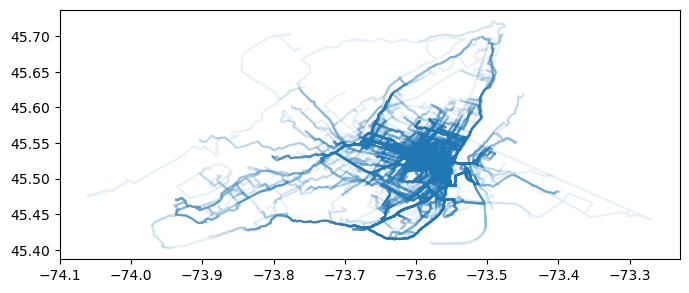

In [4]:
#Read the data as a geodataframe
gdf = gpd.GeoDataFrame.from_features(df["features"])
gdf = gdf.set_crs('epsg:3979') 
gdf.plot(alpha=0.1,figsize=(8, 8))

#Create a list of points from linestring
gdf['points'] = gdf.apply(lambda x: [y for y in x['geometry'].coords], axis=1)

In [5]:
gdf["duration"] = (gdf['stop'].apply(pd.to_datetime) - gdf['start'].apply(pd.to_datetime)) / pd.Timedelta(seconds=1)

In [7]:
gdf.head(3)

geometry                 stop  \
0  LINESTRING (-73.577 45.507, -73.578 45.507, -7...  2013-06-25 16:34:16   
1  LINESTRING (-73.629 45.464, -73.629 45.464, -7...  2013-07-25 14:40:06   
2  LINESTRING (-73.585 45.568, -73.582 45.566, -7...  2013-07-25 14:43:12   

   id_origine                start  length  purpose  \
0          52  2013-06-25 16:21:21    3163  Commute   
1        2325  2013-07-25 14:37:42    1066  Courses   
2        2326  2013-07-25 14:19:15    5619  Courses   

                                liste_segments_jsonb  n_coord    id  \
0  [{'source': 'GEOBASE', 'id': 1260962}, {'sourc...      511    52   
1  [{'source': 'GEOBASE', 'id': 1310311}, {'sourc...      196  2325   
2  [{'source': 'GEOBASE', 'id': 1170061}, {'sourc...     1036  2326   

                                              points  duration  
0  [(-73.577476909289, 45.5069002299392), (-73.57...     775.0  
1  [(-73.62896982707571, 45.4637247074939), (-73....     144.0  
2  [(-73.5848059077338, 45.5678560254651), (-73.5...    1437.0

In [ ]:
#SeriesGroupBy.shift([periods, freq, axis, ...])

In [8]:
R_earth = 6371*1000   # earth radius [m]
d2r = np.pi/180


time = [] # time_per_segment for each segment
A = [] # (long1, lat1)
B = [] # (long2, lat2)
og_trip = [] #which trip does the segment belong to

for i in range(len(gdf)):
    trip = i #index of trip

    #create two lists with coordinates shifted one idx in second list,
    #so that they line up and instead of having points ((x1,y1), (x2,y2), (x3,y3)) 
    #we will have line segments:    a          b
    #                            (x1,y1) -> (x2,y2)
    #                            (x2,y2) -> (x3,y3)
    k = len(gdf["points"][trip])
    a = gdf["points"][trip][0:k-1]
    b = gdf["points"][trip][1:k]
    time_per_segment = gdf["duration"][trip]/k #again want og data w/ time-stamps, also check if n_coord == # of coord
    t = [time_per_segment for x in range(k-1)]
    og = [trip for x in range(k-1)]
    
    A += a
    B += b
    time += t
    og_trip += og

In [9]:
df_a = pd.DataFrame(A, columns=["long1", "lat1"])
df_b = pd.DataFrame(B, columns=["long2", "lat2"])
test_df = pd.concat([df_a, df_b], axis=1)

#create linestrings of the lines a -> b
series = test_df.apply(
    lambda r: LineString([
         (r['long1'], r['lat1']),
         (r['long2'], r['lat2'])
    ]),
    axis=1
)

In [10]:
#convert from df to geo-df
GM = gpd.GeoDataFrame(pd.Series(series, name="geo"), geometry='geo')


#Add columns
GM["time"] = time
GM["trip_id"] = og_trip
GM["length"] = GM["geo"].length* d2r * R_earth
GM["vel_ind"] = GM["length"]/GM["time"]

In [13]:
GM.rename(columns = {"time":"ind_time"},inplace=True) #but first, keep the other time

mean_timestep = round(GM["ind_time"].mean(),2)
GM["time"] = [round(mean_timestep,1) for x in range(len(GM["vel_ind"]))]
GM["vel_og"] = GM["length"]/GM["time"]

In [14]:
GM.dropna(inplace=True) #remove NaN-values (in this case it is one trip that is deleted (i think like trip or smth 938))

In [761]:
gm= GM[["trip_id", "vel_og"]].copy()

In [762]:
gm.set_index(["trip_id"], inplace=True,
             append=True, drop=False)

In [763]:
gm.drop("trip_id", axis=1, inplace=True)

# Done

Meet your dataframe:
Currently it consists of 
* index
* geo; two coordinates denoting a linesegment
* ind_time; [s/1] calculated average time between readings (total time of trip/number of readings in trip)
* trip_id; to keep track of what trip it belongs to
* length; [m] length of linesegment
* vel_ind; [m/s] velocity as calculated based on ind_time
* time; mean time between GPS readings (set to 1.51 seconds for all readings)
* vel_og; [m/s] velocity as calculated based on time


In [764]:
gm.head(3) #print dataframe

vel_og
  trip_id           
0 0         2.776631
1 0         8.253211
2 0        13.042027

We will use the same assumed time-step for all

# Let's do some statistics 
First we need to get rid of some infeasible velocities

In [765]:
#The 5 highest velocities
gm.nlargest(5, "vel_og")

vel_og
        trip_id              
868392  826      20949.587442
2020498 1876     11773.681119
186618  203      10961.734421
3865628 3742      7033.249158
802073  774       5443.924493

## Z-score
We want to use z-score to exclude some data-points (based on how much the velocity in that point deviates from the mean velocity of that trip). 
The question is which points to include when calculating the mean

We exclude the points which we consider "standing still" (v<1m/s)
we also exclude all velocities over 20m/s
for comparison we can also choose m_v to something else, to see how much effect the choice of 20m/s as cutoff has (very little).

In [766]:
m_v = 20 #exclude velocities over m_v 

gm["Z_val_"+str(m_v)] = np.nan #create new "empty" column

#calculate z-val for all velocities v: 1 < v < 20
gm["Z_val_"+str(m_v)] = gm.loc[(gm["vel_og"] <= m_v) & (gm["vel_og"] >= 1)].groupby(level=1)["vel_og"].apply(stats.zscore)

gm["Z_val_"+str(m_v)].fillna(1000, inplace=True)
gm.loc[gm["vel_og"] < 1, "Z_val_"+str(m_v)] = 0

So the idea is to take away all datapoints where z-val > some value

Why not the ones below -(some value)? 

Well... how slow you might cycle (at some point) is not related to your average speed, but probably how fast you are likely to go is

https://ilovebicycling.com/average-bike-speed/

## Replace infeasible velocities with interpolation of neighboring velocities
We copy the original velocity (vel_og) but set all velocities where z > 2 to NaN, and then use pandas.interpolate to (linear) interpolate new velocities for those points.

In [767]:
gm["vel"] = gm["vel_og"].copy()
gm.loc[gm['Z_val_20'] >= 2, 'vel'] = np.nan
gm["vel"].interpolate(method='linear', inplace=True)

In [768]:
gm.head(3)

vel_og  Z_val_20        vel
  trip_id                                
0 0         2.776631 -0.986791   2.776631
1 0         8.253211  0.092033   8.253211
2 0        13.042027  1.035374  13.042027

# Implement Kalman-filter

# Smoothing

Testing some different smoothing options
* Moving average
* exponential moving average
* lfilter

https://www.geeksforgeeks.org/how-to-calculate-moving-average-in-a-pandas-dataframe/

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html

(these functions will behave wrong in the transition between trips, but applying them separately to each trip vs applying them to the entire dataframe is sooo much faster. So don't bother with that until you have decided on a specific smoothing function)

# Fake implementation of Kalman
"vel_smooth"
make sure to deal with different trips separately

In [769]:
gm["vel_smooth"] = np.nan #create new "empty" column

#calculate z-val for all velocities v: 1 < v < 20
gm["vel_smooth"] = gm.groupby(level=1, group_keys=False)["vel"].apply(lambda x: x.rolling(window=5).mean())



In [770]:
gm.head()

vel_og  Z_val_20        vel  vel_smooth
  trip_id                                            
0 0         2.776631 -0.986791   2.776631         NaN
1 0         8.253211  0.092033   8.253211         NaN
2 0        13.042027  1.035374  13.042027         NaN
3 0        16.901791  1.795704  16.901791         NaN
4 0        15.072462  1.435347  15.072462   11.209224

In [771]:
gm.dropna(inplace=True)

In [772]:
gm

vel_og     Z_val_20        vel  vel_smooth
        trip_id                                                
4       0         15.072462     1.435347  15.072462   11.209224
5       0         14.907679     1.402886  14.907679   13.635434
6       0          7.429656    -0.070198   7.429656   13.470723
7       0          5.835586    -0.384212   5.835586   12.029435
8       0          4.149291    -0.716392   4.149291    9.478935
...                     ...          ...        ...         ...
4327028 4880       5.576722    -0.208084   5.576722    4.615067
4327029 4880       6.043106     0.078583   6.043106    4.858339
4327030 4880       5.721542    -0.119069   5.721542    5.246239
4327031 4880       2.686475    -1.984600   2.686475    5.007974
4327032 4880     156.220831  1000.000000   2.686475    4.542864

[4307510 rows x 4 columns]

# This might change but I will now drop vel and rename vel_smooth to vel

In [773]:
gm.drop("vel",axis=1, inplace=True)
gm.drop("vel_og", axis=1, inplace=True)
gm.drop("Z_val_20", axis=1, inplace=True)
gm.rename({"vel_smooth":"vel"}, axis=1, inplace=True)

In [774]:
gm.head(2)

vel
  trip_id           
4 0        11.209224
5 0        13.635434

In [775]:
#here we assign a time to each reading
gm["time"] = 1.5
gm["time_sum"] = np.nan #create new "empty" column

#calculate z-val for all velocities v: 1 < v < 20
gm["time_sum"] = gm.groupby(level=1, group_keys=False)["time"].apply(lambda x: x.cumsum())


In [776]:
gm.head(2)

vel  time  time_sum
  trip_id                           
4 0        11.209224   1.5       1.5
5 0        13.635434   1.5       3.0

In [777]:
#last time in each trip - i.e., length of trip
gm.groupby(level=1)["time_sum"].tail(1).head(2)

     trip_id
406  0          604.5
482  1          108.0
Name: time_sum, dtype: float64

In [778]:
#we only want to keep trips longer than five minutes
gm = gm.groupby(level=1).filter(lambda x:(x.time_sum.tail(1) >= 300)).copy()

In [779]:
#I will also delete all trips longer than one hour
gm = gm.groupby(level=1).filter(lambda x:(x.time_sum.tail(1) <= 3600)).copy()

# The idea is to compare 5 minute increments (300 steps) to the whole data-set. 

Things to compare:
* Mean acceleration
* Mean velocity
* Idling time/minute
* Idling time specifically around mean velocity/minute
* number of stops/minute
* time spent "stopping"/minute

In [780]:
v_use = "vel"
acc_name = "acc"

gm[acc_name] = -gm.groupby(level=1, group_keys=False)[v_use].apply(lambda x: x.diff(periods=-1))
gm[acc_name] = gm.loc[:, (acc_name)]/gm.loc[:, ("time")]

In [781]:
#just changing the order of the columns
gm = gm.iloc[:,[2,1,0,3]].copy()

In [782]:
#the last elem in each trip is NaN so we drop it
gm.dropna(inplace=True)

In [783]:
gm.head(2)

time_sum  time        vel       acc
  trip_id                                     
4 0             1.5   1.5  11.209224  1.617473
5 0             3.0   1.5  13.635434 -0.109807

I was hoping we could do this for each five minute increment, the besto would be to create the five minutes increments dynamicly. But that is soo computationally heavy that I decided to do it statically. i.e., just split up all trips in five minute increments and then cut the end of each trip (the part that is not neccessarily 5 minutes)

In [784]:
#create new columns w/ only zeros
gm["idx"] = 0 

#set every first row in a five min span to 1
gm.loc[gm["time_sum"] % 300 == 1.5, "idx"] = 1

# Now cumsum the rows so that everything in the first five minutes has a one, in the second five minutes has a two etc.
gm["idx"] = gm["idx"].cumsum()

In [785]:
gm.head(202)

time_sum  time        vel       acc  idx
    trip_id                                          
4   0             1.5   1.5  11.209224  1.617473    1
5   0             3.0   1.5  13.635434 -0.109807    1
6   0             4.5   1.5  13.470723 -0.960859    1
7   0             6.0   1.5  12.029435 -1.700333    1
8   0             7.5   1.5   9.478935 -1.261345    1
...               ...   ...        ...       ...  ...
201 0           297.0   1.5   1.597682  0.220349    1
202 0           298.5   1.5   1.928206  0.049266    1
203 0           300.0   1.5   2.002105  0.552429    1
204 0           301.5   1.5   2.830748  0.211825    2
205 0           303.0   1.5   3.148485  0.507872    2

[202 rows x 5 columns]

In [786]:
#we let this new column be an index-col
gm.set_index(["idx"], inplace=True,
             append=True, drop=False)

#drop the OG idx column (just a duplicate)
gm.drop("idx", axis=1, inplace=True)

# take away trip_id as an index, but keep (as regular column) for reference
gm.reset_index(level=1, inplace=True)

In [787]:
gm.head(2)

trip_id  time_sum  time        vel       acc
  idx                                              
4 1          0       1.5   1.5  11.209224  1.617473
5 1          0       3.0   1.5  13.635434 -0.109807

In [788]:
# recalc the time-sum column for the new five-min segments
gm["time_sum"] = gm.groupby(level=1, group_keys=False)["time"].apply(lambda x: x.cumsum())

In [789]:
gm.head(3)

trip_id  time_sum  time        vel       acc
  idx                                              
4 1          0       1.5   1.5  11.209224  1.617473
5 1          0       3.0   1.5  13.635434 -0.109807
6 1          0       4.5   1.5  13.470723 -0.960859

In [790]:
#cut all that are shorter than five minutes
gm = gm.groupby(level=1).filter(lambda x:(x.time_sum.tail(1) >= 300)).copy()

In [791]:
#create dataframe to keep track of all data
gm_idx = pd.DataFrame(index=gm.index.unique(level=1).tolist())

In [792]:
#add mean vel, mean acc, mean dec to each MT
gm_idx["vel_mean"] = gm.groupby(level=1)["vel"].mean()

gm["pos_acc"] = gm["acc"]
gm.loc[gm["pos_acc"] < 0 , "pos_acc"] = np.nan
gm_idx["acc_mean"] = gm.groupby(level=1)["pos_acc"].mean()


gm["neg_acc"] = gm["acc"]
gm.loc[gm["neg_acc"] > 0 , "neg_acc"] = np.nan
gm_idx["dec_mean"] = gm.groupby(level=1)["neg_acc"].mean()

In [793]:
#add number of stops to each MT

idx_list = gm.index.unique(level=1).tolist()
av_stops_list = []

for index in idx_list:
    v_s = 2
    frame = gm.xs(index, level=1)

    velocities = frame["vel"].tolist()
    stops = []
    state = 0
    one_stop = []

    for i in range(1, len(velocities)):
        v = velocities[i]
        if state == 0 and v <= v_s:
            one_stop.append(v)
            state = 0
        elif state == 0 and v > v_s:
            one_stop.append(v)
            stops.append(one_stop)
            state = 1
        elif state == 1 and v <=v_s:
            one_stop = [velocities[i-1], v]
            state = 0
        else: #state = 1 v > 1
            state = 1
    av_stops_list.append(len(stops))
    
gm_idx["stops"] = av_stops_list

In [794]:
#add percentage of time spent idling
idle_lim = 2 #[m/s]
gm_idx["idle"] = (gm.loc[gm["vel"]<=idle_lim].groupby(level=1)["vel"].apply(lambda x: x.count())/gm.groupby(level=1)["vel"].apply(lambda x: x.count())).tolist()

#the above will be set to NaN if no time is spent idling, so we just change that to zero
gm_idx["idle"].fillna(0, inplace=True)

In [795]:
# time spent accelerating
# time spend cruising
# vel distribution

In [797]:
#time spent cruising
cruise_lim = 0.1 #[m/s^2]

gm["cruise"] = 1
gm.loc[gm["acc"] < -cruise_lim , "cruise"] = 0
gm.loc[gm["acc"] > cruise_lim , "cruise"] = 0

gm_idx["cruise"] = (gm.groupby(level=1)["cruise"].apply(lambda x: x.sum())/gm.groupby(level=1)["vel"].apply(lambda x: x.count())).tolist()

In [798]:
#time spent accelerating
cruise_lim = 0.1 #[m/s^2]

gm["acc_time"] = 1
gm.loc[gm["acc"] < cruise_lim , "acc_time"] = 0

gm_idx["acc_time"] = (gm.groupby(level=1)["acc_time"].apply(lambda x: x.sum())/gm.groupby(level=1)["vel"].apply(lambda x: x.count())).tolist()

In [802]:
gm_idx["vel_max"] = gm.groupby(level=1)["vel"].max()
gm_idx["acc_max"] = gm.groupby(level=1)["acc"].max()
gm_idx["dec_min"] = gm.groupby(level=1)["acc"].min()

In [803]:
gm_idx.head(3)

vel_mean  acc_mean  dec_mean  stops  idle  cruise  acc_time    vel_max  \
1  1.970399  0.227322 -0.230483      6  0.75   0.520     0.220  13.635434   
2  8.846372  0.511564 -0.543495      3  0.11   0.185     0.445  15.306685   
4  5.696106  0.361524 -0.334978      1  0.00   0.190     0.410   8.947896   

    acc_max   dec_min  
1  1.617473 -1.700333  
2  2.245050 -2.067038  
4  1.037684 -1.218059

# Now we wish to analyse how well these parameters of each trip matches with the overall data

* Scale the data (make it normal)
* use PCA to transform the data (project it onto an n-dimensional space where less parameters are in play)

PCA:
* We currently have 10 parameters
* i.e. our data exists in a 10-dimentional space
* There is correlation between our parameters (in a sense, the 10-dim space is not orthogonal)
* because of this it is hard (impossible) to determine *which* of the parameters are *most* important
* PCA basically finds the 10-dim orthogonal (ON because we scaled it) basis of eigenvectors (to the COV-matrix)
* (COV-matrix is symmetrical = ON exists)
* and then projects the parameters onto this space. 
* It is now easy to see which of the *eigenvectors* are most important
* we choose n eigenvectors as our basis and project the parameters onto it

In [810]:
scaling=StandardScaler()
scaling.fit(gm_idx)

scaled_data=scaling.transform(gm_idx)
pca = PCA(n_components=10)
pca.fit(scaled_data)

print("The 10 ON directions of the eigenvectors explain", [x*100 for x in pca.explained_variance_ratio_.tolist()], "% of the variance in the data respectivly")
print("\nSo by using the 5 first eigenvectors we can explain", sum([x*100 for x in pca.explained_variance_ratio_.tolist()][0:5]), "% of the variance in the data")


The 10 ON directions of the eigenvectors explain [67.30250450548215, 16.970641625210426, 5.894777112218363, 3.745632406632386, 2.7182464880772135, 1.2784269417425138, 1.1614279874697908, 0.5197651620604057, 0.26685691797239247, 0.14172085313433613] % of the variance in the data respectivly

So by using the 5 first eigenvectors we can explain 96.63180213762053 % of the variance in the data


In [850]:
n_c = 5

pca = PCA(n_components=n_c)
pca.fit(scaled_data)
gm_trans = pd.DataFrame(pca.transform(gm_idx), index=gm_idx.index.tolist())

for idx in range(n_c):
    mean = gm_trans[idx].mean()
    col_name = "dev_" + str(idx)
    gm_trans[col_name] = abs(gm_trans[idx]-mean)/abs(mean)

/Users/johannaskantorp/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


We now have a dataframe which tells us what values each 10 components for each trip is in the new 5-dim basis of eigenvectors, and how much that value deviates from the mean of the value for all trips in that particular direction abs((val-mean)/mean)

In [851]:
gm_trans.head(3)

0         1         2         3         4     dev_0     dev_1  \
1  6.129253  2.465817  2.763877  8.261596  5.505360  0.213327  4.919875   
2  9.928670 -2.190896  5.109766  9.066609  7.720919  0.965448  2.482837   
4  5.991004 -2.026724  3.240799  4.933803  4.695588  0.185960  2.221855   

      dev_2     dev_3     dev_4  
1  0.162341  0.453187  0.141471  
2  1.148897  0.594786  0.600840  
4  0.362909  0.132161  0.026426

In [852]:
#We copy only the rows where all deviations are within 10%of the mean (i.e. dev_ <=0.1)

gm_pass = gm_trans.loc[(gm_trans["dev_0"] <= 0.1) & (gm_trans["dev_1"] <= 0.1) & (gm_trans["dev_2"] <= 0.1) & (gm_trans["dev_3"] <= 0.1) & (gm_trans["dev_4"] <= 0.1)]

In [853]:
print("there are", len(gm_pass), "trips which pass the test")

there are 58 trips which pass the test


In [866]:
test = gm.swaplevel().loc[gm_pass.index.unique().tolist()]
test_idx = gm_idx.loc[gm_pass.index.unique().tolist()]


print(test["vel"].mean(), gm["vel"].mean())
print(test["pos_acc"].mean(), gm["pos_acc"].mean())
print(test["neg_acc"].mean(), gm["neg_acc"].mean())
print(test_idx["idle"].mean(), gm_idx["idle"].mean())
print(test_idx["cruise"].mean(), gm_idx["cruise"].mean())
print(test_idx["vel_max"].mean(), gm_idx["vel_max"].mean())
print(test_idx["acc_max"].mean(), gm_idx["acc_max"].mean())
print(test_idx["dec_min"].mean(), gm_idx["dec_min"].mean())

5.313368086049961 5.089337223891314
0.22385775466750546 0.24367671146102438
-0.21611138554531317 -0.23926266219196637
0.05939655172413793 0.0775776119402961
0.39456896551724135 0.40405932835821085
8.413721491402999 8.20538000367966
0.9087806390068047 0.9015603663158216
-0.857083142512426 -0.8806050065284727


In [869]:
print("these", len(gm_pass.index.unique().tolist()), "trips are the best:", gm_pass.index.unique().tolist())

these 58 trips are the best: [263, 351, 352, 400, 640, 821, 1131, 1315, 1454, 1664, 1754, 1881, 1928, 2258, 2481, 2608, 2667, 3324, 3741, 5030, 5392, 5407, 5747, 5922, 6027, 6132, 6210, 6226, 6591, 6803, 6997, 7303, 7320, 7321, 7490, 7764, 7809, 8051, 8910, 9395, 9584, 9827, 10423, 11139, 11326, 11761, 11908, 12398, 12923, 14040, 14764, 15109, 15125, 15795, 15911, 15925, 16349, 16746]


In [878]:
first_vel = gm.swaplevel().loc[gm_pass.index.unique().tolist()].groupby(level=0).head(1)["vel"].tolist()
last_vel = gm.swaplevel().loc[gm_pass.index.unique().tolist()].groupby(level=0).tail(1)["vel"].tolist()

In [903]:
print(first_vel[last_vel.index(min(last_vel))])

3.553713910502867


In [894]:
trip_idx = gm.swaplevel().loc[gm_pass.index.unique().tolist()].index.unique(level=0).tolist()

trips_dic = {}
for i in range(len(trip_idx)):
    trips_dic[trip_idx[i]] = [first_vel[i], last_vel[i]]

construct_trip = []

end_vel = 0
while len(construct_trip) <5:
    trip = []
    first = []
    last = []
    for key, val in trips_dic.items():
        trip.append(key)
        first.append(val[0])
        last.append(val[0])
    
    start_vel = min(first, key=lambda x:abs(x-end_vel))
    seg_idx = first.index(start_vel)
    construct_trip.append(trip[seg_idx])
    end_vel = last[seg_idx]
    trips_dic.pop(trip[seg_idx])

In [895]:
print(construct_trip)

[15109, 640, 1928, 8051, 5392]


In [897]:
gm_25 = gm.swaplevel().loc[construct_trip]

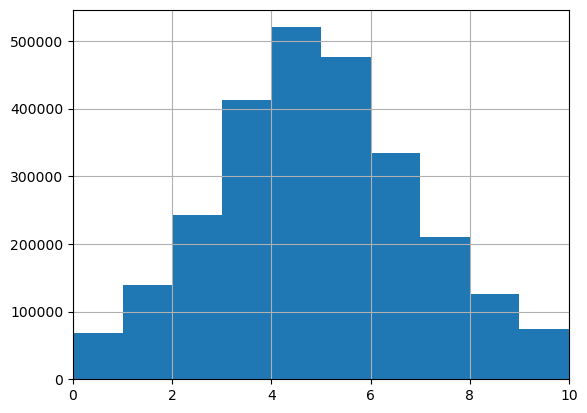

In [907]:
gm["vel"].hist(bins=[x for x in range(21)])
plt.xlim([0,10])
plt.show()

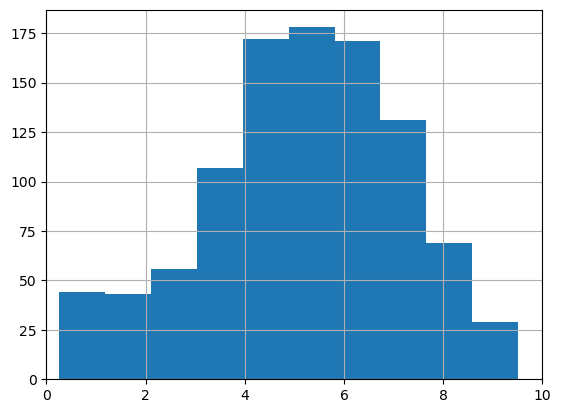

In [908]:
gm_25["vel"].hist()
plt.xlim([0,10])
plt.show()

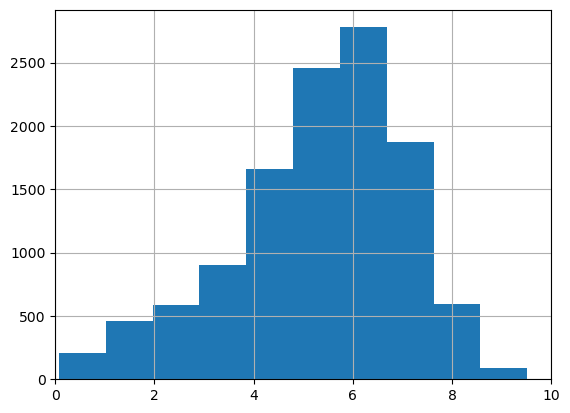

In [909]:
test["vel"].hist()
plt.xlim([0,10])
plt.show()

In [915]:
gm_25.index.unique(level=1).tolist()

Int64Index([3892563, 3892564, 3892565, 3892566, 3892567, 3892568, 3892569,
            3892570, 3892571, 3892572,
            ...
            1313556, 1313557, 1313558, 1313559, 1313560, 1313561, 1313562,
            1313563, 1313564, 1313565],
           dtype='int64', length=1000)

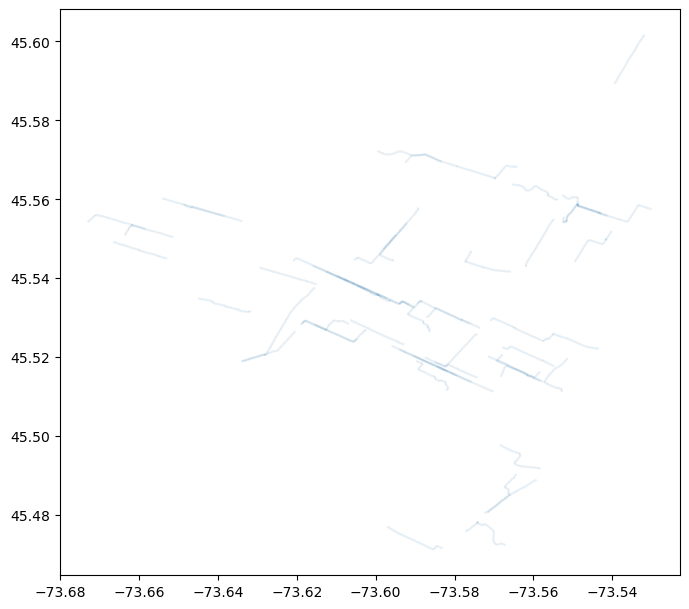

In [920]:
GM.loc[test.index.unique(level=1).tolist()].plot(alpha=0.1,figsize=(8, 8))
plt.show()

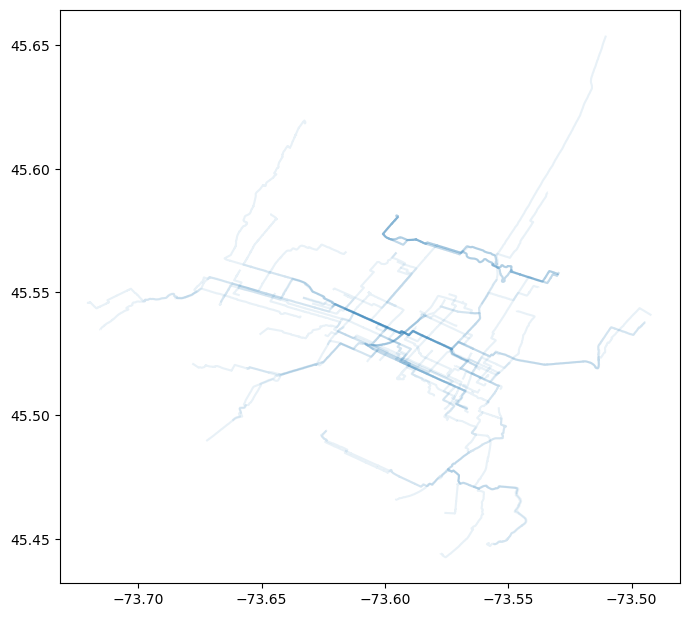

In [913]:
trip_ids = test["trip_id"].unique().tolist()

gdf.iloc[trip_ids].plot(alpha=0.1,figsize=(8, 8))
plt.show()

# loren ipsum

In [922]:
gm_trans["dev"] = gm_trans["dev_0"] + gm_trans["dev_1"] + gm_trans["dev_2"] + gm_trans["dev_3"] + gm_trans["dev_4"] 

In [927]:
gm_idx["dev"] = gm_trans["dev"]

In [940]:
li = []
old = gm_idx["dev"].tolist()
for val in old:
    li += [val for x in range(200)]


gm["dev"] = li

In [962]:
GM["dev"] = 0

GM.loc[gm.index.unique(level=0).tolist(), "dev"] =li
#print(len(GM.loc[gm.index.unique(level=1).tolist()]), len(gm))

In [968]:
GM.set_index(["trip_id"], inplace=True,
             append=True, drop=False)
GM.drop("trip_id", axis=1, inplace=True)

In [983]:
GM["geo"][1].tolist()

[<LINESTRING (-73.578 45.507, -73.578 45.507)>]

In [1032]:
idx_list = gm.index.unique(level=0).tolist()

#GM.loc[idx_list].plot(alpha=0.1,figsize=(8, 8))

In [1034]:
GM2 = GM.loc[idx_list].copy().explode(index_parts=True)
GM2["geo"] = GM2["geo"].apply(lambda x: x.boundary)
GM2 = GM2.explode(index_parts=True)

GM2.index.unique(level=2)


#testlist = GM.loc[idx_list].groupby(level=1)['geo'].apply(lambda x: x.boundary[0].tolist()).tolist()

#print(testlist[0])



#from shapely.geometry import MultiPoint


#print(GM.loc[idx_list].groupby(level=1)['geo'].apply(lambda x: Point(x.coords[0])).tolist()[1])


#first = Point(line.coords[0])

Int64Index([0], dtype='int64')

In [1038]:
GM2.drop(1, level=3, inplace=True)

In [1041]:
testlist = GM2.head(1000).groupby(level=1)['geo'].apply(lambda x: LineString(x.tolist())).tolist()

In [1133]:
print(len(GM2.groupby(level=1)['geo']))
print(testlist)

3456
[<LINESTRING (-73.578 45.507, -73.578 45.507, -73.578 45.507, -73.578 45.507,...>, <LINESTRING (-73.582 45.566, -73.582 45.566, -73.582 45.566, -73.582 45.566,...>]


In [1068]:
gm.reset_index(level=1, inplace=True)
gm.set_index(["idx"], inplace=True,
             append=True, drop=False)


In [1074]:
GM2["idx"] = gm["idx"].tolist()

In [1075]:
GM2.set_index(["idx"], inplace=True,
             append=True, drop=False)
GM2.drop("idx", axis=1, inplace=True)

In [1078]:
geo_list = GM2.groupby(level=5)['geo'].apply(lambda x: LineString(x.tolist())).tolist()

In [ ]:
this list should be the geometry for gm_idx

In [1082]:
print(len(geo_list))
print(geo_list[0:2])

13400
[<LINESTRING (-73.578 45.507, -73.578 45.507, -73.578 45.507, -73.578 45.507,...>, <LINESTRING (-73.576 45.51, -73.576 45.51, -73.576 45.51, -73.576 45.511, -7...>]


In [1084]:
gm_idx["geo"] = geo_list

In [1086]:
type(gm_idx)

pandas.core.frame.DataFrame

In [ ]:
#Read the data as a geodataframe
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326"
)


gdf = gpd.GeoDataFrame.from_features(df["features"])
gdf = gdf.set_crs('epsg:3979') 
gdf.plot(alpha=0.1,figsize=(8, 8))

In [1088]:
gm_geo = gpd.GeoDataFrame(gm_idx, geometry="geo", crs='epsg:3979')

In [1090]:
gm_geo.head()

vel_mean  acc_mean  dec_mean  stops  idle  cruise  acc_time    vel_max  \
1  1.970399  0.227322 -0.230483      6  0.75   0.520     0.220  13.635434   
2  8.846372  0.511564 -0.543495      3  0.11   0.185     0.445  15.306685   
4  5.696106  0.361524 -0.334978      1  0.00   0.190     0.410   8.947896   
5  4.932631  0.298873 -0.338802      5  0.05   0.210     0.420   8.578514   
6  3.411573  0.273659 -0.278053      9  0.21   0.290     0.350   6.626301   

    acc_max   dec_min       dev  \
1  1.617473 -1.700333  5.890200   
2  2.245050 -2.067038  5.792808   
4  1.037684 -1.218059  2.929310   
5  0.918806 -0.922013  3.132221   
6  0.923591 -1.282654  9.972903   

                                                 geo  
1  LINESTRING (-73.578 45.507, -73.578 45.507, -7...  
2  LINESTRING (-73.576 45.510, -73.576 45.510, -7...  
4  LINESTRING (-73.582 45.566, -73.582 45.566, -7...  
5  LINESTRING (-73.589 45.555, -73.589 45.555, -7...  
6  LINESTRING (-73.575 45.551, -73.575 45.551, -7...

In [1093]:
#gm_pass.index.unique().tolist())

gm_geo.head(2)

vel_mean  acc_mean  dec_mean  stops  idle  cruise  acc_time    vel_max  \
1  1.970399  0.227322 -0.230483      6  0.75   0.520     0.220  13.635434   
2  8.846372  0.511564 -0.543495      3  0.11   0.185     0.445  15.306685   

    acc_max   dec_min       dev  \
1  1.617473 -1.700333  5.890200   
2  2.245050 -2.067038  5.792808   

                                                 geo  
1  LINESTRING (-73.578 45.507, -73.578 45.507, -7...  
2  LINESTRING (-73.576 45.510, -73.576 45.510, -7...

In [1097]:
gm_geo["dev_max"] = gm_geo["dev"]
gm_geo.loc[gm_geo["dev_max"]>10, "dev_max"] = 10

In [1111]:
#gm_geo.plot(column="dev_max", alpha=0.1, cmap="Spectral", linewidth=1, figsize=(8, 8), legend=True)

In [1130]:
TMs = gm_pass.index.unique().tolist()
gm_plot = gm_geo.loc[gm_geo.loc[TMs]["dev"].nsmallest(30).index.tolist()]

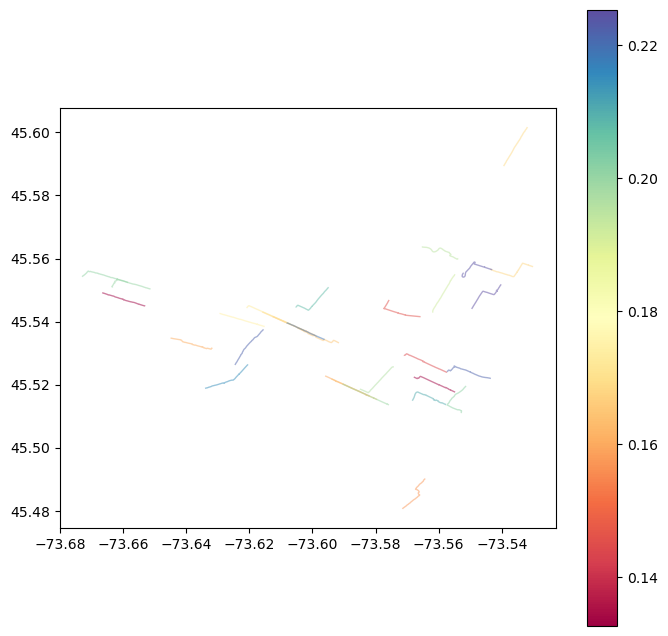

In [1131]:
#band = [0,1]
#gm_geo.loc[(gm_geo["dev"]>= band[0]) & (gm_geo["dev"]<= band[1])].plot(alpha=0.1,figsize=(8, 8))
#plt.title("0-2")

#band = [2,4]
#gm_geo.loc[(gm_geo["dev"]>= band[0]) & (gm_geo["dev"]<= band[1])].plot(alpha=0.1,figsize=(8, 8))
#plt.title("2-4")

#band = [10,20]
#gm_geo.loc[(gm_geo["dev"]>= band[0]) & (gm_geo["dev"]<= band[1])].plot(alpha=0.1,figsize=(8, 8))
gm_plot.plot(column="dev", alpha=0.5, cmap="Spectral", linewidth=1, figsize=(8, 8), legend=True)
plt.show()

In [1127]:
gm_geo.loc[gm_geo.loc[TMs]["dev"].nsmallest(1).index.tolist()]["geo"].length* d2r * R_earth

7764    1628.945189
dtype: float64

geo  ind_time  \
        trip_id                                                                
0       0        LINESTRING (-73.57748 45.50690, -73.57751 45.5...   1.89951   
1       0        LINESTRING (-73.57751 45.50692, -73.57757 45.5...   1.89951   
2       0        LINESTRING (-73.57757 45.50701, -73.57774 45.5...   1.89951   
3       0        LINESTRING (-73.57774 45.50705, -73.57792 45.5...   1.89951   
4       0        LINESTRING (-73.57792 45.50718, -73.57810 45.5...   1.89951   
...                                                            ...       ...   
4327028 4880     LINESTRING (-73.54475 45.54151, -73.54478 45.5...   1.70000   
4327029 4880     LINESTRING (-73.54478 45.54145, -73.54482 45.5...   1.70000   
4327030 4880     LINESTRING (-73.54482 45.54137, -73.54486 45.5...   1.70000   
4327031 4880     LINESTRING (-73.54486 45.54131, -73.54490 45.5...   1.70000   
4327032 4880     LINESTRING (-73.54490 45.54130, -73.54697 45.5...   1.70000   

                     length     vel_ind  time      vel_og     dev  
        trip_id                                                    
0       0          4.164946    2.192643   1.5    2.776631  0.0000  
1       0         12.379816    6.517374   1.5    8.253211  0.0000  
2       0         19.563040   10.298994   1.5   13.042027  0.0000  
3       0         25.352687   13.346963   1.5   16.901791  0.0000  
4       0         22.608693   11.902383   1.5   15.072462  5.8902  
...                     ...         ...   ...         ...     ...  
4327028 4880       8.365083    4.920637   1.5    5.576722  0.0000  
4327029 4880       9.064658    5.332152   1.5    6.043106  0.0000  
4327030 4880       8.582314    5.048420   1.5    5.721542  0.0000  
4327031 4880       4.029712    2.370419   1.5    2.686475  0.0000  
4327032 4880     234.331246  137.841910   1.5  156.220831  0.0000  

[4327030 rows x 7 columns]

# now we start to sort the MTs based on how well they coincide with the general data

we create a column of ones, and change the one to a zero if it does not pass the test


In [734]:
gm_idx["pass"] = 1
q_u = 0.55
q_l = 0.45
print("we currently have", gm_idx["pass"].sum(), "trips left")
#pass_idx = gm_idx.loc[gm_idx["pass"]==1].index.unique().tolist()
#gm.swaplevel().loc[pass_idx]["vel"].hist(bins=[x for x in range(20)])
#plt.xlim([0,10])
#plt.show()

we currently have 13400 trips left


In [735]:
vel_mean_up = gm["vel"].quantile(q_u)
vel_mean_lo = gm["vel"].quantile(q_l)

gm_idx.loc[(gm_idx["vel_mean"] <= vel_mean_lo), "pass"] += -1
gm_idx.loc[(gm_idx["vel_mean"] >= vel_mean_up), "pass"] += -1

print("we currently have",gm_idx.loc[gm_idx["pass"]==1]["pass"].count(), "trips left")
#pass_idx = gm_idx.loc[gm_idx["pass"]==1].index.unique().tolist()
#gm.swaplevel().loc[pass_idx]["vel"].hist()
#plt.xlim([0,10])
#plt.show()

we currently have 1774 trips left


In [736]:
acc_mean_up = gm["pos_acc"].quantile(q_u)
acc_mean_lo = gm["pos_acc"].quantile(q_l)

gm_idx.loc[(gm_idx["acc_mean"] <= acc_mean_lo), "pass"] += -1
gm_idx.loc[(gm_idx["acc_mean"] >= acc_mean_up), "pass"] += -1


print("we currently have", gm_idx.loc[gm_idx["pass"]==1]["pass"].count(), "trips left")
#pass_idx = gm_idx.loc[gm_idx["pass"]==1].index.unique().tolist()
#gm.swaplevel().loc[pass_idx]["vel"].hist()
#plt.xlim([0,10])
#plt.show()

we currently have 362 trips left


In [737]:
stops_up = gm_idx["stops"].quantile(q_u)
stops_lo = gm_idx["stops"].quantile(q_l)

gm_idx.loc[(gm_idx["stops"] < stops_lo), "pass"] += -1
gm_idx.loc[(gm_idx["stops"] > stops_up), "pass"] += -1


print("we currently have", gm_idx.loc[gm_idx["pass"]==1]["pass"].count(), "trips left")
#pass_idx = gm_idx.loc[gm_idx["pass"]==1].index.unique().tolist()
#gm.swaplevel().loc[pass_idx]["vel"].hist()
#plt.xlim([0,10])
#plt.show()

we currently have 184 trips left


In [738]:
cruise_up = gm_idx["cruise"].quantile(q_u)
cruise_lo = gm_idx["cruise"].quantile(q_l)

gm_idx.loc[(gm_idx["cruise"] <= cruise_lo), "pass"] += -1
gm_idx.loc[(gm_idx["cruise"] >= cruise_up), "pass"] += -1


print("we currently have", gm_idx.loc[gm_idx["pass"]==1]["pass"].count(), "trips left")
#pass_idx = gm_idx.loc[gm_idx["pass"]==1].index.unique().tolist()
#gm.swaplevel().loc[pass_idx]["vel"].hist()
#plt.xlim([0,10])
#plt.show()

we currently have 4 trips left


In [739]:
acc_time_up = gm_idx["acc_time"].quantile(q_u)
acc_time_lo = gm_idx["acc_time"].quantile(q_l)

gm_idx.loc[(gm_idx["acc_time"] <= acc_time_lo), "pass"] += -1
gm_idx.loc[(gm_idx["acc_time"] >= acc_time_up), "pass"] += -1


print("we currently have", gm_idx.loc[gm_idx["pass"]==1]["pass"].count(), "trips left")
#pass_idx = gm_idx.loc[gm_idx["pass"]==1].index.unique().tolist()
#gm.swaplevel().loc[pass_idx]["vel"].hist()
#plt.xlim([0,10])
#plt.show()

we currently have 1 trips left


In [740]:
dec_mean_up = gm["neg_acc"].quantile(q_u)
dec_mean_lo = gm["neg_acc"].quantile(q_l)

gm_idx.loc[(gm_idx["dec_mean"] <= dec_mean_lo), "pass"] += -1
gm_idx.loc[(gm_idx["dec_mean"] >= dec_mean_up), "pass"] += -1


print("we currently have", gm_idx.loc[gm_idx["pass"]==1]["pass"].count(), "trips left")
#pass_idx = gm_idx.loc[gm_idx["pass"]==1].index.unique().tolist()
#gm.swaplevel().loc[pass_idx]["vel"].hist()
#plt.xlim([0,10])
#plt.show()

we currently have 1 trips left


In [745]:
#idle_up = gm_idx["idle"].quantile(q_u)
#idle_lo = gm_idx["idle"].quantile(q_l)

#gm_idx.loc[(gm_idx["idle"] <= idle_lo), "pass"] += -1
#gm_idx.loc[(gm_idx["idle"] >= idle_up), "pass"] += -1


#print("we currently have", gm_idx.loc[gm_idx["pass"]==1]["pass"].count(), "trips left")
#pass_idx = gm_idx.loc[gm_idx["pass"]==1].index.unique().tolist()
#gm.swaplevel().loc[pass_idx]["vel"].hist()
#plt.xlim([0,10])
#plt.show()

<AxesSubplot:>

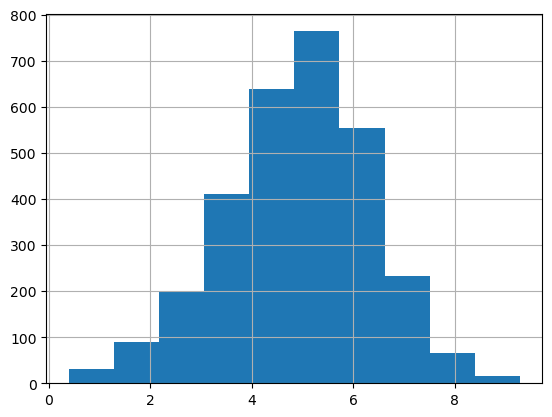

In [746]:
pass_idx = gm_idx.loc[gm_idx["pass"]>=0].index.unique().tolist()
gm.swaplevel().loc[pass_idx]["vel"].hist()

In [747]:
trip_ids = gm.swaplevel().loc[pass_idx]["trip_id"].unique().tolist()
gdf.iloc[trip_ids].head(2)

geometry                 stop  \
87   LINESTRING (-73.539 45.578, -73.540 45.577, -7...  2013-07-30 09:46:40   
690  LINESTRING (-73.575 45.494, -73.575 45.494, -7...  2013-07-15 17:34:39   

     id_origine                start  length           purpose  \
87         3098  2013-07-30 09:29:12    6946  Domicile-travail   
690        1137  2013-07-15 17:11:13    8820           Commute   

                                  liste_segments_jsonb  n_coord    id  \
87   [{'source': 'GEOBASE', 'id': 1420048}, {'sourc...     1245  3098   
690  [{'source': 'GEOBASE', 'id': 1260303}, {'sourc...     1529  1137   

                                                points  duration  
87   [(-73.5390644827741, 45.577738754301), (-73.53...    1048.0  
690  [(-73.5749609413506, 45.4937810120959), (-73.5...    1406.0

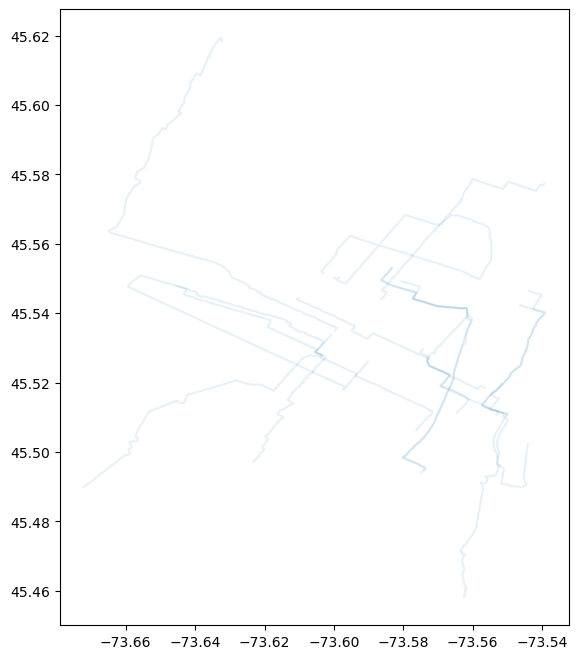

In [748]:
trip_ids = gm.swaplevel().loc[pass_idx]["trip_id"].unique().tolist()

gdf.iloc[trip_ids].plot(alpha=0.1,figsize=(8, 8))
plt.show()

In [756]:
gm_idx.loc[gm_idx["pass"] >=0]

acc_mean  dec_mean  stops   idle  cruise  acc_time   vel_max   acc_max  \
370    0.161463 -0.161326      2  0.005   0.395     0.305  6.909447  0.559252   
2943   0.143991 -0.145906      2  0.015   0.400     0.290  6.502856  0.540422   
4305   0.148013 -0.145422      2  0.025   0.420     0.305  7.777850  0.601510   
6063   0.161273 -0.157942      2  0.020   0.380     0.305  9.281875  0.642144   
6325   0.146413 -0.161623      3  0.015   0.435     0.310  7.887759  0.524008   
6628   0.148608 -0.154728      2  0.025   0.400     0.320  6.883893  0.511307   
6850   0.153888 -0.135157      2  0.025   0.435     0.300  7.408076  0.527173   
8575   0.164316 -0.151965      2  0.070   0.470     0.300  7.948881  0.604553   
8649   0.166721 -0.153126      3  0.120   0.400     0.310  6.183735  0.850447   
10309  0.159965 -0.155479      2  0.015   0.400     0.335  7.714442  0.562255   
10324  0.166641 -0.153799      1  0.000   0.370     0.310  7.777181  0.585582   
11071  0.141600 -0.149028      2  0.040   0.460     0.300  7.272356  0.633574   
11354  0.163546 -0.149636      3  0.060   0.460     0.300  7.499767  0.806610   
11758  0.155694 -0.158946      3  0.070   0.390     0.310  5.969625  0.707443   
11865  0.138901 -0.149954      2  0.020   0.420     0.305  6.568061  0.561090   

        dec_min  vel_mean  pass  
370   -0.645396  4.950296     1  
2943  -0.516325  4.876007     0  
4305  -0.544596  4.912549     0  
6063  -0.543294  6.502049     0  
6325  -0.648767  4.835844     0  
6628  -0.514820  4.750163     0  
6850  -0.516890  5.041273     0  
8575  -0.812091  4.753326     0  
8649  -0.613705  4.310575     0  
10309 -0.597701  4.885585     0  
10324 -0.399822  5.120205     0  
11071 -0.623342  4.928811     0  
11354 -0.793167  5.001462     0  
11758 -0.726076  3.797863     0  
11865 -0.552640  4.761654     0

In [754]:
lk = [[vel_mean_lo,vel_mean_up],[acc_mean_lo,acc_mean_up], [dec_mean_lo,dec_mean_up], [stops_lo,stops_up],[idle_lo,idle_up],[cruise_lo,cruise_up],[acc_time_lo, acc_time_up]]

left_val = [x[0] for x in lk]
right_val = [x[1] for x in lk]

index = gm_idx.columns.tolist()

In [755]:
print([[round(x,2) for x in li] for li in lk])

[[4.66, 5.17], [0.12, 0.17], [-0.16, -0.12], [2.0, 3.0], [0.02, 0.04], [0.35, 0.4], [0.3, 0.32]]


In [752]:
index = gm_idx.columns.tolist()
left = pd.Series(left_val, index=index[0:len(left_val)])
right = pd.Series(right_val, index=index[0:len(left_val)])
gm_idx.loc[gm_idx["pass"] >=-1].style.highlight_between(left=left, right=right, axis=1, props='color:white; background-color:purple;')


In [547]:
from scipy.stats import ks_2samp

In [546]:
gm.head(3)

trip_id  time_sum  time        vel       acc   pos_acc   neg_acc  \
  idx                                                                     
4 1          0       1.5   1.5  11.209224  1.617473  1.617473       NaN   
5 1          0       3.0   1.5  13.635434 -0.109807       NaN -0.109807   
6 1          0       4.5   1.5  13.470723 -0.960859       NaN -0.960859   

       cruise  acc_time vel_bin  is_mean  
  idx                                     
4 1         0         1      12        0  
5 1         0         0      14        0  
6 1         0         0      14        0

In [551]:
data1 = gm.groupby(level=1).get_group(1)["vel"].tolist()
data2 = gm["vel"].tolist()

In [572]:
idx_idx = gm_idx.loc[gm_idx["pass"] >=-1].index.unique().tolist()
idx_idx = gm_idx.index.unique().tolist()
stat_list = []
data1 = gm["vel"].tolist()

for idx in idx_idx[0:100]:
    data2 = gm.groupby(level=1).get_group(idx)["vel"].tolist()
    kres = ks_2samp(data1, data2)
    stat_list.append([kres[0],kres[1]])

In [570]:
#gm_idx["KS_vel"] = 0

#gm_idx.loc[gm_idx["pass"]>=-1, "KS_vel"] = [x[1] for x in stat_list]

In [578]:
print([x[1] for x in stat_list if x[1] >= 0.0005])

[0.051328462060779345, 0.03445595361088938, 0.011146433259852276, 0.045651195972224334, 0.003430745266889152, 0.005244941168135948, 0.0013991423564200635, 0.003335643013600578, 0.02227215222793208]


In [579]:
KS_list = [x[1] for x in stat_list] + [0 for x in range(len(gm_idx)-len(stat_list))]
gm_idx["KS_vel"] = KS_list
gm_idx.loc[idx_idx[0:100]].style.highlight_between(left=left, right=right, axis=1, props='color:white; background-color:purple;')


In [ ]:
idx_idx = gm_idx.index.unique().tolist()
stat_list = []

for idx in idx_idx:
    data1 = gm.groupby(level=1).get_group(idx)["acc"].tolist()
    data2 = gm["acc"].tolist()
    kres = ks_2samp(data1, data2)
    stat_list.append([kres[0],kres[1]])
gm_idx["KS_acc"] = [x[1] for x in stat_list]

In [571]:
index = gm_idx.columns.tolist()
left = pd.Series(left_val, index=index[0:len(left_val)])
right = pd.Series(right_val, index=index[0:len(left_val)])
gm_idx.loc[gm_idx["pass"] >=-1].style.highlight_between(left=left, right=right, axis=1, props='color:white; background-color:purple;')


In [501]:
#gm_idx["idle"].mean()

In [284]:
#gm_idx["idle"].quantile(0.75)

0.095

In [606]:
gm_idx["vel_max"] = gm.groupby(level=1)["vel"].max()
gm_idx["acc_max"] = gm.groupby(level=1)["acc"].max()
gm_idx["dec_min"] = gm.groupby(level=1)["acc"].min()

In [648]:
gm_idx["vel_mean2"] = gm_idx["vel_mean"]
gm_idx.drop("vel_mean", axis=1, inplace=True)

In [609]:
gm_idx.drop("KS_vel", axis=1, inplace=True)
gm_idx.drop("pass", axis=1, inplace=True)

acc_mean  dec_mean  stops   idle  cruise  acc_time    vel_max  \
1      0.227322 -0.230483      6  0.750   0.520     0.220  13.635434   
2      0.511564 -0.543495      3  0.110   0.185     0.445  15.306685   
4      0.361524 -0.334978      1  0.000   0.190     0.410   8.947896   
5      0.298873 -0.338802      5  0.050   0.210     0.420   8.578514   
6      0.273659 -0.278053      9  0.210   0.290     0.350   6.626301   
...         ...       ...    ...    ...     ...       ...        ...   
16828  0.175684 -0.175374      1  0.000   0.375     0.310  10.813612   
16830  0.178292 -0.157177      1  0.000   0.405     0.290   7.474655   
16832  0.181955 -0.173943      1  0.000   0.370     0.330   8.554596   
16834  0.221815 -0.210582     14  0.230   0.315     0.350   5.985555   
16836  0.185021 -0.168079      8  0.235   0.455     0.250   6.198620   

        acc_max   dec_min  vel_mean  
1      1.617473 -1.700333  1.970399  
2      2.245050 -2.067038  8.846372  
4      1.037684 -1.218059  5.696106  
5      0.918806 -0.922013  4.932631  
6      0.923591 -1.282654  3.411573  
...         ...       ...       ...  
16828  0.774676 -0.866299  6.391034  
16830  0.542237 -0.485849  5.665111  
16832  0.541928 -0.620705  5.419971  
16834  0.745055 -0.720901  2.936436  
16836  0.574483 -0.684902  2.884262  

[13400 rows x 10 columns]

In [666]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaling=StandardScaler()
 
# Use fit and transform method
scaling.fit(gm_idx)

scaled_data=scaling.transform(gm_idx)
pca = PCA(n_components=4)
pca.fit(scaled_data)




PCA(n_components=4)

In [682]:
gm_idx.head(3)

acc_mean  dec_mean  stops  idle  cruise  acc_time    vel_max   acc_max  \
1  0.227322 -0.230483      6  0.75   0.520     0.220  13.635434  1.617473   
2  0.511564 -0.543495      3  0.11   0.185     0.445  15.306685  2.245050   
4  0.361524 -0.334978      1  0.00   0.190     0.410   8.947896  1.037684   

    dec_min  vel_mean2  
1 -1.700333   1.970399  
2 -2.067038   8.846372  
4 -1.218059   5.696106

In [680]:
pd.DataFrame(scaling.transform(gm_idx), columns=gm_idx.columns.tolist(), index = gm_idx.index.tolist())

acc_mean  dec_mean     stops      idle    cruise  acc_time   vel_max  \
1     -0.129004  0.075826  1.619248  5.054413  0.659477 -0.875848  2.077968   
2      2.077352 -2.351797  0.099324  0.243710 -1.246022  1.660927  2.717520   
4      0.912704 -0.734601 -0.913958 -0.583129 -1.217582  1.266318  0.284145   
5      0.426396 -0.764259  1.112607 -0.207293 -1.103821  1.379063  0.142791   
6      0.230677 -0.293110  3.139172  0.995382 -0.648776  0.589844 -0.604281   
...         ...       ...       ...       ...       ...       ...       ...   
16828 -0.529827  0.503234 -0.913958 -0.583129 -0.165291  0.138862  0.998116   
16830 -0.509583  0.644366 -0.913958 -0.583129  0.005351 -0.086629 -0.279633   
16832 -0.481152  0.514337 -0.913958 -0.583129 -0.193731  0.364353  0.133637   
16834 -0.171752  0.230176  5.672378  1.145717 -0.506575  0.589844 -0.849480   
16836 -0.457349  0.559812  2.632531  1.183300  0.289753 -0.537611 -0.767945   

        acc_max   dec_min  vel_mean2  
1      1.966492 -2.280990  -1.887869  
2      3.690339 -3.301387   2.274103  
4      0.373909 -0.939006   0.367272  
5      0.047369 -0.115222  -0.094853  
6      0.060513 -1.118747  -1.015538  
...         ...       ...        ...  
16828 -0.348530  0.039807   0.787907  
16830 -0.987002  1.098454   0.348511  
16832 -0.987849  0.723203   0.200130  
16834 -0.429894  0.444394  -1.303134  
16836 -0.898426  0.544565  -1.334715  

[13400 rows x 10 columns]

In [671]:
[x*100 for x in pca.explained_variance_ratio_.tolist()]

[67.30250450548216, 16.97064162521043, 5.89477711221837, 3.7456324066323856]

In [677]:
scaled_data

array([[-0.12900363,  0.07582591,  1.61924813, ...,  1.96649181,
        -2.28098951, -1.88786879],
       [ 2.07735169, -2.35179696,  0.09932437, ...,  3.69033928,
        -3.30138668,  2.27410349],
       [ 0.91270409, -0.73460135, -0.91395813, ...,  0.37390912,
        -0.93900586,  0.36727232],
       ...,
       [-0.48115207,  0.51433672, -0.91395813, ..., -0.98784933,
         0.72320312,  0.20012972],
       [-0.17175186,  0.23017614,  5.67237815, ..., -0.4298944 ,
         0.44439362, -1.30313388],
       [-0.45734877,  0.55981224,  2.63253063, ..., -0.89842627,
         0.54456536, -1.33471454]])

In [688]:
pca = PCA(n_components=4)
pca.fit(scaled_data)

PCA(n_components=4)

In [690]:
#pca = PCA(n_components=4)
#pca.fit(scaled_data)
gm_trans = pd.DataFrame(pca.transform(gm_idx))#, columns=gm_idx.columns.tolist())

/Users/johannaskantorp/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [713]:
for idx in range(4):
    mean = gm_trans[idx].mean()
    col_name = "dev_" + str(idx)
    gm_trans[col_name] = abs(gm_trans[idx]-mean)/abs(mean)

5.051607612902024
-0.6290550919617145
2.377854785806092
5.685158341160459


In [729]:
string = ""
for idx in range(4):
    string += "(gm_trans[\"dev_" + str(idx) + "\"] <= 0.1) & "
print(string)
#gm_trans.loc[(gm_trans["dev_1"] < 0.1]

(gm_trans["dev_0"] <= 0.1) & (gm_trans["dev_1"] <= 0.1) & (gm_trans["dev_2"] <= 0.1) & (gm_trans["dev_3"] <= 0.1) & 


In [732]:


gm_trans.loc[(gm_trans["dev_0"] <= 0.1) & (gm_trans["dev_1"] <= 0.1) & (gm_trans["dev_2"] <= 0.1) & (gm_trans["dev_3"] <= 0.1)]

0         1         2         3     dev_0     dev_1     dev_2  \
208    5.431398 -0.676882  2.486113  6.051374  0.075182  0.076030  0.045528   
281    4.769215 -0.600502  2.247792  5.787841  0.055902  0.045390  0.054697   
282    4.987497 -0.661996  2.234123  5.796015  0.012691  0.052366  0.060446   
321    5.349254 -0.617748  2.340203  5.911482  0.058921  0.017975  0.015834   
510    5.123697 -0.595435  2.354098  5.893331  0.014271  0.053445  0.009991   
651    4.962730 -0.656135  2.351122  5.934712  0.017594  0.043048  0.011243   
898    4.796725 -0.576763  2.233534  5.798155  0.050456  0.083128  0.060694   
1047   5.434922 -0.603796  2.478676  6.012247  0.075880  0.040155  0.042400   
1164   5.156720 -0.673236  2.457872  6.026461  0.020808  0.070234  0.033651   
1332   5.195158 -0.573164  2.509734  5.962937  0.028417  0.088850  0.055462   
1405   5.011212 -0.581608  2.240546  5.822895  0.007997  0.075425  0.057745   
1510   4.919849 -0.642059  2.404032  5.926421  0.026083  0.020672  0.011009   
1548   5.482083 -0.607119  2.597946  6.093096  0.085216  0.034871  0.092559   
1815   5.359149 -0.655205  2.406163  5.974943  0.060880  0.041571  0.011905   
1998   4.640610 -0.654786  2.183687  5.786018  0.081360  0.040905  0.081657   
2099   5.027525 -0.597625  2.361400  5.924879  0.004767  0.049965  0.006920   
2146   4.856873 -0.609772  2.277008  5.850214  0.038549  0.030654  0.042411   
2649   5.538012 -0.597807  2.614959  6.075582  0.096287  0.049675  0.099714   
2673   4.727694 -0.589329  2.400624  5.894260  0.064121  0.063152  0.009576   
3010   5.449342 -0.663044  2.560601  6.118648  0.078734  0.054032  0.076854   
4052   5.449430 -0.652484  2.398829  5.950759  0.078752  0.037245  0.008821   
4344   5.512379 -0.624683  2.527556  6.083230  0.091213  0.006951  0.062956   
4356   5.114016 -0.620945  2.260665  5.805272  0.012354  0.012893  0.049284   
4635   5.333017 -0.636684  2.398816  6.000845  0.055707  0.012128  0.008815   
4781   5.470003 -0.629848  2.343141  5.927896  0.082824  0.001260  0.014599   
4867   5.540671 -0.620051  2.466225  6.024918  0.096813  0.014314  0.037164   
4951   4.695207 -0.691023  2.320208  5.916982  0.070552  0.098509  0.024243   
5014   5.418094 -0.657164  2.479319  6.091602  0.072548  0.044684  0.042670   
5028   4.948906 -0.599502  2.489014  5.956273  0.020331  0.046980  0.046748   
5325   5.110331 -0.639746  2.188306  5.790570  0.011625  0.016996  0.079714   
5494   5.157735 -0.610407  2.224898  5.798225  0.021009  0.029645  0.064326   
5651   5.396521 -0.591748  2.516592  6.027756  0.068278  0.059306  0.058346   
5894   5.535500 -0.650111  2.594892  6.110940  0.095790  0.033472  0.091275   
5908   5.475964 -0.642958  2.511676  6.045256  0.084004  0.022100  0.056278   
5909   5.402812 -0.567665  2.533098  6.061849  0.069523  0.097591  0.065287   
6045   5.455539 -0.656090  2.451695  6.017578  0.079961  0.042977  0.031053   
6262   5.009479 -0.638137  2.356882  5.852182  0.008340  0.014438  0.008820   
6301   5.017639 -0.582359  2.192495  5.728377  0.006724  0.074231  0.077953   
6498   4.955862 -0.571815  2.359605  5.871045  0.018954  0.090993  0.007675   
7193   5.285288 -0.651795  2.518880  6.045612  0.046259  0.036149  0.059308   
7585   5.345118 -0.593523  2.497936  6.079461  0.058102  0.056485  0.050500   
7739   4.866242 -0.618163  2.314312  5.862154  0.036694  0.017315  0.026723   
7934   4.962791 -0.591546  2.425056  5.940318  0.017582  0.059627  0.019850   
8415   5.464762 -0.571506  2.479296  6.014270  0.081787  0.091485  0.042661   
9001   4.884024 -0.588958  2.366602  5.894967  0.033174  0.063743  0.004732   
9155   4.949061 -0.646609  2.232982  5.804010  0.020300  0.027906  0.060926   
9513   5.315081 -0.683998  2.403478  5.997267  0.052156  0.087343  0.010776   
9638   4.896149 -0.569758  2.302551  5.860424  0.030774  0.094264  0.031669   
10042  4.953092 -0.583245  2.278615  5.821125  0.019502  0.072823  0.041735   
10472  5.237234 -0.593420  2.471907  6.040281  0.036746  0.05664

In [733]:
gm_idx

acc_mean  dec_mean  stops   idle  cruise  acc_time    vel_max  \
1      0.227322 -0.230483      6  0.750   0.520     0.220  13.635434   
2      0.511564 -0.543495      3  0.110   0.185     0.445  15.306685   
4      0.361524 -0.334978      1  0.000   0.190     0.410   8.947896   
5      0.298873 -0.338802      5  0.050   0.210     0.420   8.578514   
6      0.273659 -0.278053      9  0.210   0.290     0.350   6.626301   
...         ...       ...    ...    ...     ...       ...        ...   
16828  0.175684 -0.175374      1  0.000   0.375     0.310  10.813612   
16830  0.178292 -0.157177      1  0.000   0.405     0.290   7.474655   
16832  0.181955 -0.173943      1  0.000   0.370     0.330   8.554596   
16834  0.221815 -0.210582     14  0.230   0.315     0.350   5.985555   
16836  0.185021 -0.168079      8  0.235   0.455     0.250   6.198620   

        acc_max   dec_min  vel_mean  
1      1.617473 -1.700333  1.970399  
2      2.245050 -2.067038  8.846372  
4      1.037684 -1.218059  5.696106  
5      0.918806 -0.922013  4.932631  
6      0.923591 -1.282654  3.411573  
...         ...       ...       ...  
16828  0.774676 -0.866299  6.391034  
16830  0.542237 -0.485849  5.665111  
16832  0.541928 -0.620705  5.419971  
16834  0.745055 -0.720901  2.936436  
16836  0.574483 -0.684902  2.884262  

[13400 rows x 10 columns]

In [223]:
gm["cruise"].sum()/len(gm)

0.40405932835820896

In [226]:
gm["vel"].quantile(0.25)

3.5790408658585595

In [618]:
gm_dic = {"vel":[gm["vel"].mean(), gm["vel"].std()], 
          "acc":[gm.loc[gm["acc"]> 0]["acc"].mean(),gm.loc[gm["acc"]> 0]["acc"].std()],
          "dec":[gm.loc[gm["acc"]<0]["acc"].mean(), gm.loc[gm["acc"]<0]["acc"].std()],
          "stops":[np.mean(gm_idx["stops"].tolist()), np.std(gm_idx["stops"].tolist())],
          "idle":[np.mean(gm_idx["idle"].tolist()), np.std(gm_idx["idle"].tolist())]
         }

In [608]:
gm_idx["keep"] = 1

In [614]:
gm_idx.head(3)

vel       acc       dec  stops   idle  keep
1  1.957350  0.226948 -0.230949      5  0.755     1
2  8.787787  0.539896 -0.508176      3  0.110     1
4  5.658928  0.332759 -0.358411      1  0.000     1

In [619]:
for key, val in gm_dic.items():
    if key == "acc":
        gm_idx
    gm_idx.loc[gm_idc[key]> ]

vel
acc
dec
stops
idle


In [566]:
print("the mean acceleration for all trips is", round(gm.loc[gm["acc"]> 0]["acc"].mean(),3), "with std:", round(gm.loc[gm["acc"]>0]["acc"].std(),3))

print("the 75% quantile for acceleration is", round(gm.loc[gm["acc"]> 0]["acc"].quantile(0.75),3))

the mean acceleration for all trips is 0.238 with std: 0.256
the 75% quantile for acceleration is 0.342


In [567]:
print("the mean velocity of the entire dataset is", round(gm["vel"].mean(),3), "with std", round(gm["vel"].std(),3))

the mean velocity of the entire dataset is 5.055 with std 2.269


In [550]:
# MTs get cut if we demand that their mean vel are within one std of the mean vel of the data

up = gm["vel"].mean() + gm["vel"].std()
lo = gm["vel"].mean() - gm["vel"].std()

#gm = gm.groupby(level=1).filter(lambda x:((x["vel"].mean() <= up) & (x["vel"].mean() >= lo))).copy()

In [577]:
#gm.groupby(level=1).filter(lambda x:((x["vel"].mean() <= up) or (x["vel"].mean() >= lo))).index.unique(level=1).tolist()

In [579]:
# another 1828 MTs get cut when we demand that their mean acc is within the 75%quantile

up = gm.loc[gm["acc"]> 0]["acc"].quantile(0.75)


#gm = gm.groupby(level=1).filter(lambda x:((x["pos_acc"].mean() <= up))).copy()

<AxesSubplot:>

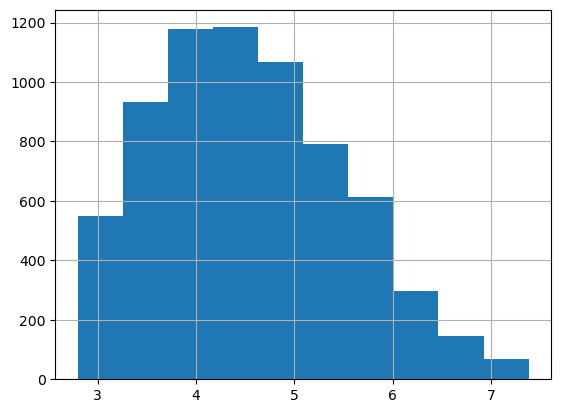

In [350]:
#the mean velocity for all the MTs
#we could obvs still cut some trips and still have enough data, but lets do some other stuff first
gm.groupby(level=1)["vel"].apply(lambda x: x.mean()).hist();

In [477]:
av_stops_all = np.mean(av_stops_list)
std_stops = np.std(av_stops_list)
print("during 5 minutes we stop on average", round(av_stops_all,2), "times")
print("std", std_stops)

during 5 minutes we stop on average 2.92 times
std 1.8308449869774939


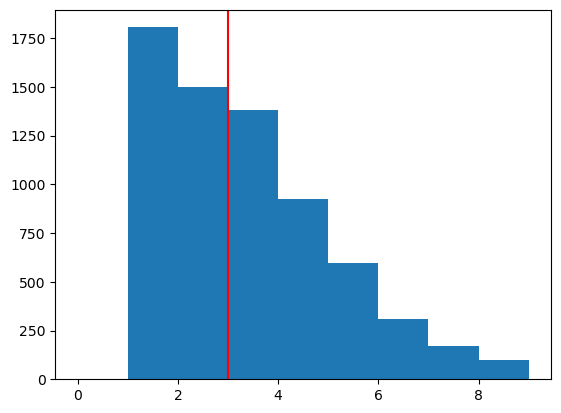

In [466]:
plt.hist(av_stops_list, bins= [x for x in range(10)], width=1)
plt.axvline(x=round(av_stops_all), color="red")
plt.show()

#if in 0

Lets keep all of the TMs which have beteen 2 and 4 stops

In [444]:
gm = gm.loc[(gm["stops"]>=2) & (gm["stops"]<=4)].copy()
print("we have", round(len(gm)/200), "MTs left")

how much time do we generally spend in idling (v<2m/s)?

In [473]:
print(round(len(gm.loc[gm["vel"]<=2])/len(gm),5), " of the time")
print(np.std((gm.loc[gm["vel"]<=2].groupby(level=1)["vel"].apply(lambda x: x.count())/gm.groupby(level=1)["vel"].apply(lambda x: x.count()))))

0.07498  of the time
0.06833205985941344


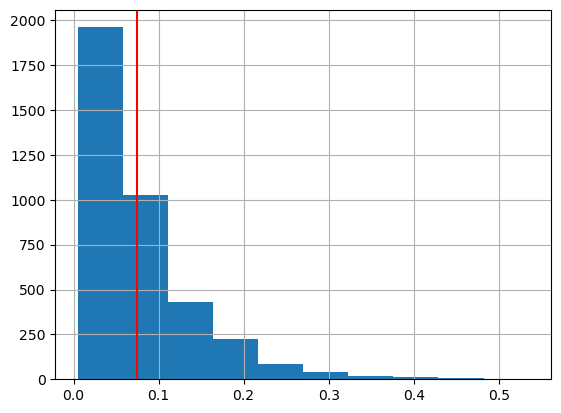

In [467]:
#the mean velocity for all the MTs
(gm.loc[gm["vel"]<=2].groupby(level=1)["vel"].apply(lambda x: x.count())/gm.groupby(level=1)["vel"].apply(lambda x: x.count())).hist()
plt.axvline(x=round(len(gm.loc[gm["vel"]<=2])/len(gm),5), color="red")
plt.show()

In [471]:
idle_list = (gm.loc[gm["vel"]<=2].groupby(level=1)["vel"].apply(lambda x: x.count())/gm.groupby(level=1)["vel"].apply(lambda x: x.count())).tolist()


idle_col = []
for el in idle_list:
    tm = [el for x in range(200)]
    idle_col += tm
gm["idle"] = idle_col

In [479]:
gm.head(2)

trip_id  time_sum  time       vel      acc  pos_acc  stops  idle
     idx                                                                  
1087 7          2       1.5   1.5  2.752607 -0.09813      NaN      4  0.02
1088 7          2       3.0   1.5  2.899803 -0.12902      NaN      4  0.02

In [475]:
mean_idle = len(gm.loc[gm["vel"]<=2])/len(gm)
std_idle = np.std((gm.loc[gm["vel"]<=2].groupby(level=1)["vel"].apply(lambda x: x.count())/gm.groupby(level=1)["vel"].apply(lambda x: x.count())))


gm = gm.loc[(gm["idle"]>=mean_idle - std_idle) & (gm["idle"]<=mean_idle + std_idle)].copy()
print("we have", round(len(gm)/200), "MTs left")

we have 3102 MTs left


<AxesSubplot:>

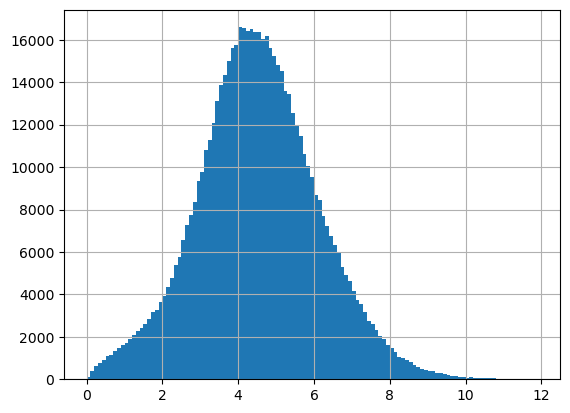

In [481]:
gm["vel"].hist(bins=[x/10 for x in range(120)])

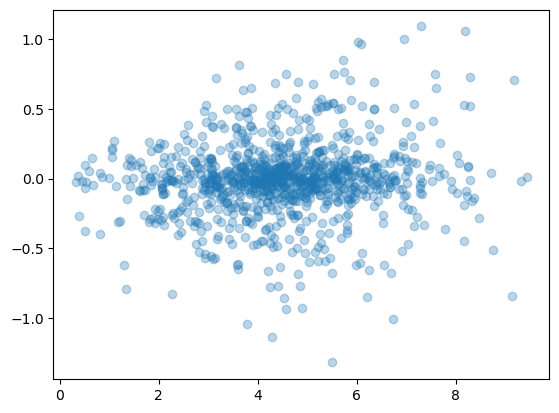

In [486]:
frame = gm.sample(n=1000)

plt.scatter(
            x=frame["vel"],
            y=frame["acc"], alpha=0.3, color='tab:blue')

In [489]:
gm.groupby(level=1)["vel"].apply(lambda x: x.max())

idx
7         7.996975
9        14.008978
13        9.956141
23        9.671067
32        6.319346
           ...    
13035     8.166810
13049    10.153291
13086     5.071651
13089     7.144054
13091     6.712374
Name: vel, Length: 3102, dtype: float64

In [249]:
gm["vel"].quantile(0.25)

3.5790408658585595

In [498]:
#we cut all that contain a velocity higher than 95 quantile
#gm.groupby(level=1).filter(lambda x:(x["vel"].max() <= gm["vel"].quantile(0.95)))

trip_id  time_sum  time       vel       acc   pos_acc  stops  \
        idx                                                                   
9410    32           9       1.5   1.5  4.856215  0.312156  0.312156      3   
9411    32           9       3.0   1.5  4.387980 -0.462377       NaN      3   
9412    32           9       4.5   1.5  5.081546 -0.035958       NaN      3   
9413    32           9       6.0   1.5  5.135483 -0.019869       NaN      3   
9414    32           9       7.5   1.5  5.165286  0.403540  0.403540      3   
...                ...       ...   ...       ...       ...       ...    ...   
4322593 13091     4860     294.0   1.5  2.776738 -0.202414       NaN      3   
4322594 13091     4860     295.5   1.5  3.080359  0.082908  0.082908      3   
4322595 13091     4860     297.0   1.5  2.955997  0.013914  0.013914      3   
4322596 13091     4860     298.5   1.5  2.935127  0.008666  0.008666      3   
4322597 13091     4860     300.0   1.5  2.922128 -0.447041       NaN      3   

               idle  
        idx          
9410    32     0.04  
9411    32     0.04  
9412    32     0.04  
9413    32     0.04  
9414    32     0.04  
...             ...  
4322593 13091  0.01  
4322594 13091  0.01  
4322595 13091  0.01  
4322596 13091  0.01  
4322597 13091  0.01  

[338200 rows x 8 columns]

In [506]:
gm.loc[gm["acc"]<0].groupby(level=1)["acc"].apply(lambda x: x.mean()).head(5)

-0.34418378012269407

In [508]:
print("the mean deceleration is", round(gm.loc[gm["acc"]<0]["acc"].mean(),3), "with std", round(gm.loc[gm["acc"]<0]["acc"].std(),3))

print("the 75% quantile for deceleration is", round(gm.loc[gm["acc"]< 0]["acc"].quantile(0.25),3))



the mean deceleration is -0.191 with std 0.201
the 75% quantile for deceleration is -0.268


In [ ]:
gm.loc[gm["acc"]>0].groupby(level=1)["acc"].apply(lambda x: x.mean()).head(3)

In [ ]:
idx_list = gm.index.get_level_values(1).unique().tolist()
mean_cruise = []


for idx in idx_list[0:100]:
    frame = gm.groupby(level=1).get_group(idx)


    lo = frame["vel"].quantile(0.25)
    up = frame["vel"].quantile(0.75)
    
    q_c = frame.loc[(frame["vel"]<up) & (frame["vel"]>lo)]["cruise"].sum()/len(frame)
    
    c = frame["cruise"].sum()/len(frame)
    mean_cruise.append(q_c/c)
print(mean_cruise)

# Generating an acceleration function
We start by copying over all points where we accelerate to a new dataframe (also skip end and start points)

In [62]:
GM_a = GM.loc[(GM["acc_smooth"] >= 0) & (GM["count"] >= 0)][["vel_smooth", "acc_smooth"]].copy()

We start with binning the velocity in relevant bin-sizes. I have used size 0.1 (m/s) since this is what we use in the model.

The max bin i get from:

In [63]:
print(GM_a["vel_smooth"].nlargest(1))
print(GM_a["acc_smooth"].nlargest(1))

3109430    19.90314
Name: vel_smooth, dtype: float64
1432387    2.529097
Name: acc_smooth, dtype: float64


In [64]:
#Here we simply set the bin-sizes for the average speed
variable = "vel_smooth"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM_a[grouped_variable_name] = pd.cut(
    GM_a[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

#GM_a.fillna(1, inplace=True) #if the vel/accel is denoted as -0 these will not we assigned a bin, so we assign them to 1.
#actually switched the left lim to -inf so not an issue anymore

In [65]:
#Here we simply set the bin-sizes for the average acc
variable = "acc_smooth"  
grouped_variable_name = "acc_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,26):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,26):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM_a[grouped_variable_name] = pd.cut(
    GM_a[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

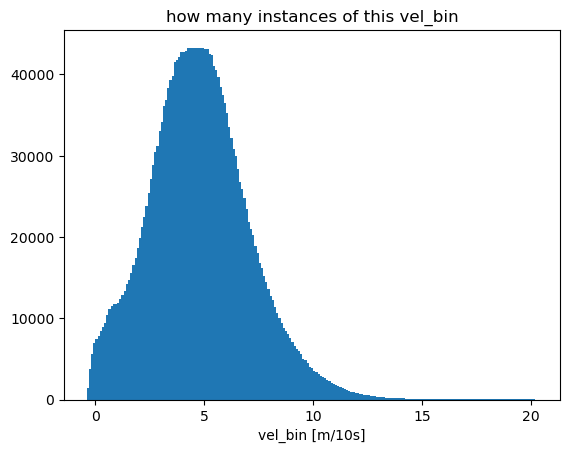

In [82]:
variables = ["vel_bin"] 

GM_count = (
    GM_a
    .groupby(variables)
    .agg("count")
    .reset_index()
)  # Aggregation to tariff cells

plt.xlabel(str(variables[0])+ " [m/10s]")
plt.bar([x/10 for x in GM_count.index.tolist()], GM_count["vel_smooth"])
plt.title("how many instances of this "+ str(variables[0]))
plt.show()

# Reminder -
set GM_a.loc[GM_a["acc_bin"] <= 1]
and find the "slow rolling stops"

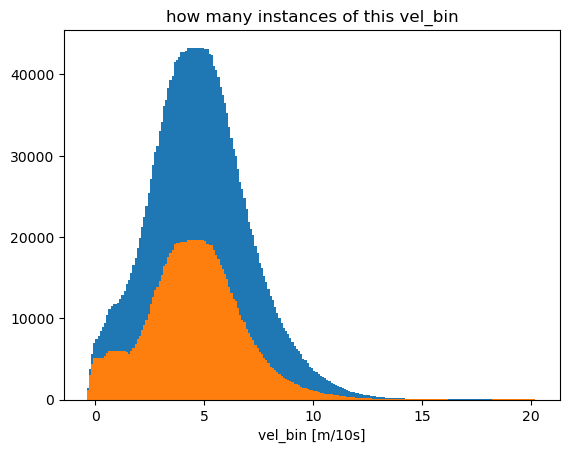

In [97]:
variables = ["vel_bin"] 

GM_agg = (
    GM_a.loc[GM_a["acc_bin"] <= 1]
    .groupby(variables)
    .agg("count")
    .reset_index()
)  # Aggregation to tariff cells

plt.xlabel(str(variables[0])+ " [m/10s]")
plt.bar([x/10 for x in GM_count.index.tolist()], GM_count["vel_smooth"])
plt.bar([x/10 for x in GM_agg.index.tolist()], GM_agg["vel_smooth"])
plt.title("how many instances of this "+ str(variables[0]))
plt.show()

We do the same for the un-processed velocities

In [98]:
GM_OGa = GM.loc[(GM["acc"] >= 0) & (GM["count"] >= 0)][["vel", "acc"]].copy()

#Here we simply set the bin-sizes for the average speed
variable = "vel"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM_OGa[grouped_variable_name] = pd.cut(
    GM_OGa[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [99]:
GM_testa = GM.loc[(GM["acc_smooth_test"] >= 0) & (GM["count"] >= 0)][["vel_smooth_test", "acc_smooth_test"]].copy()

#Here we simply set the bin-sizes for the average speed
variable = "vel_smooth_test"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM_testa[grouped_variable_name] = pd.cut(
    GM_testa[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

For all velocities in a bin, we plot the mean acceleration, the max acceleration and the mean of the top ten accelerations.

In [100]:
#mean_acc = GM_a.groupby("vel_bin")["acc_smooth"].agg(["mean"])
#max_acc = GM_a.groupby("vel_bin")["acc_smooth"].nlargest(1)
#meanmax_acc = GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).mean())


We also want to be able to compare it to the current acceleration function

In [101]:
### Input

m_bike = 18.3 #[kg] mass of bike
m_human = 73.5 #mass of cyclist
mass = m_human+m_bike
level = "fit"

### Parameters
E_output = {"untrained": 1.5, "fit": 3.0, "highP": 5.0} #[W/kg]
P_max = m_human*E_output[level] #[W]

g = 9.81 # [m/s²]
RRcoef = 0.008 # [1]  % Rolling Resistance coefficient #####Changed!!! OK!
cw = 1 # [1]  
A = 0.5 # [m^2] % frontal area bike and cyclist
s = 0 #[rad] degree of slope
 
# Air density 
temp = 20 # [degree]
Temp = 273.15 + temp
rho = (10**(-5))*(Temp**2) - 0.0048*Temp + 1.2926 #which to use?

In [102]:
def acc_fun(v):
    #takes v=velocity as an argument
    #returns acceleration as a function of v
    if v == 0: #to avoid dividing with zero
        acc = 2
    else: 
        P_roll_steady = mass * g * RRcoef * v
        P_air_steady = 0.5 * cw * A * rho * (v**3)
        P_climb_steady = (mass)*g*s
        P_lost = P_roll_steady + P_air_steady + P_climb_steady

        P_acc = P_max - P_lost
        acc = P_acc/(mass*v)
    acc = min(2, acc) #max 2m/s
    acc = max(acc,0) #not negative
    return acc


vel_list = [x/10 for x in range(1,201)]
acc_list = []

for v in vel_list:
    acc_list.append(acc_fun(v))

## Plot and compare potential acceleration function 
* Smoothed data
* OG data
* acceleration function as provided by *physics* ;)

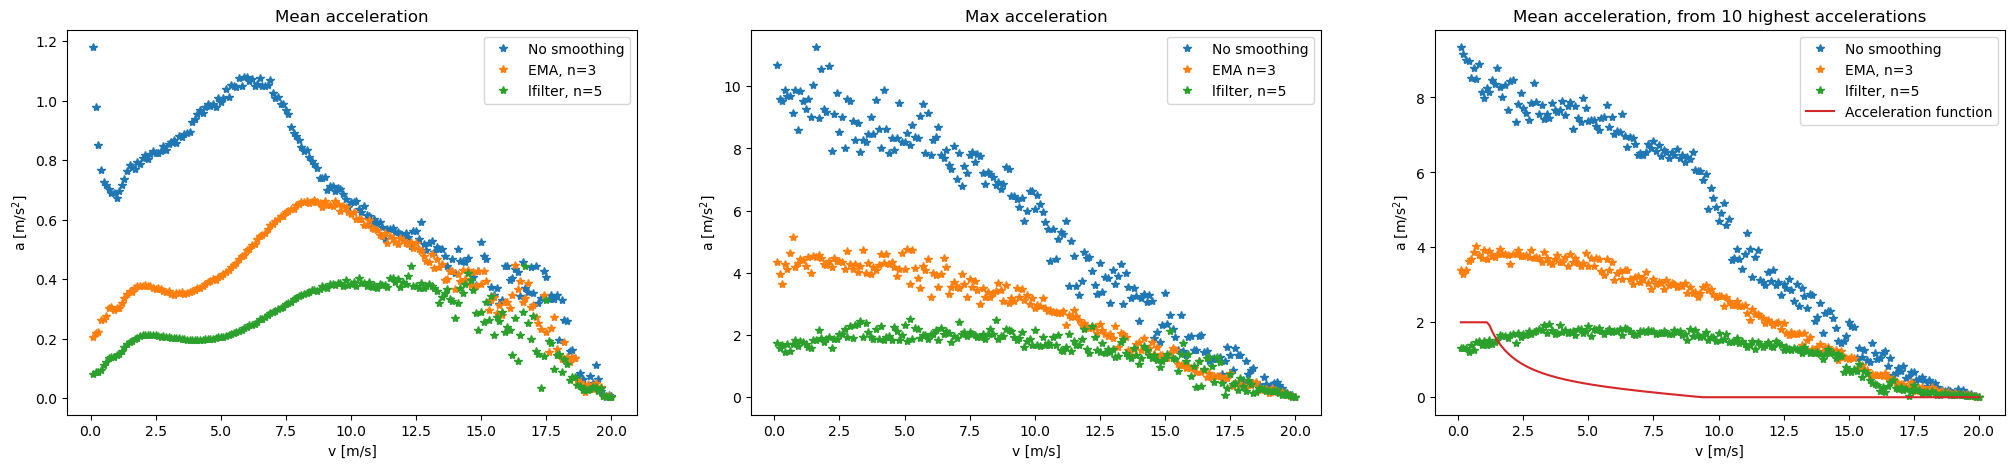

In [103]:
fig = plt.figure(figsize=(25, 5))
    
plt.subplot(1,3,1)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].agg(["mean"]), "*", label="No smoothing")
plt.plot([x/10 for x in range(1,201)], GM_testa.groupby("vel_bin")["acc_smooth_test"].agg(["mean"]), "*", label="EMA, n=3")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="lfilter, n=5")

plt.legend()
plt.plot()
plt.title("Mean acceleration")

plt.subplot(1,3,2)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].nlargest(1), "*", label="No smoothing")
plt.plot([x/10 for x in range(1,201)], GM_testa.groupby("vel_bin")["acc_smooth_test"].nlargest(1), "*", label="EMA n=3")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].nlargest(1), "*", label="lfilter, n=5")
plt.legend()
plt.title("Max acceleration")

plt.subplot(1,3,3)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()), "*", label="No smoothing")
plt.plot([x/10 for x in range(1,201)], GM_testa.groupby("vel_bin")["acc_smooth_test"].apply(lambda x: x.nlargest(10).mean()), "*", label="EMA, n=3")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()), "*", label="lfilter, n=5")

plt.plot(vel_list, acc_list, "-", label="Acceleration function")
plt.legend()
plt.title("Mean acceleration, from 10 highest accelerations")


plt.show()

In [143]:
#GM_testa.rename(columns = {"acc_smooth_test": "acc"}, inplace = True)
#GM_a.rename(columns = {"acc_smooth": "acc"}, inplace = True)


vel_bin
1      9.341640
2      9.152831
3      9.007803
4      8.974601
5      8.518482
         ...   
196    0.151782
197    0.131524
198         NaN
199         NaN
200         NaN
Name: acc, Length: 200, dtype: float64

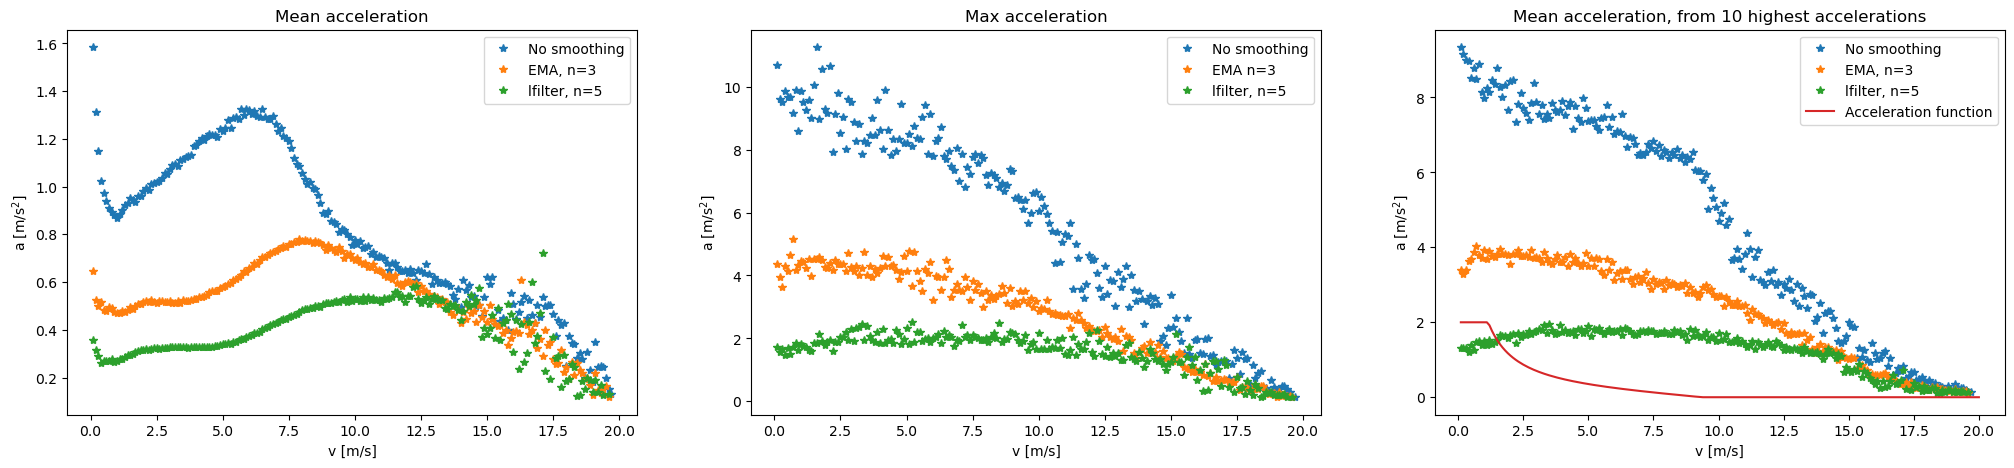

In [144]:
fig = plt.figure(figsize=(25, 5))
    
plt.subplot(1,3,1)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.plot([x/10 for x in range(1,201)], GM_OGa.loc[GM_OGa["acc"] >= 0.1].groupby("vel_bin")["acc"].agg(["mean"]), "*", label="No smoothing")
plt.plot([x/10 for x in range(1,201)], GM_testa.loc[GM_testa["acc_smooth_test"] >= 0.1].groupby("vel_bin")["acc_smooth_test"].agg(["mean"]), "*", label="EMA, n=3")
plt.plot([x/10 for x in range(1,201)], GM_a.loc[GM_a["acc_smooth"] >= 0.1].groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="lfilter, n=5")

plt.legend()
plt.plot()
plt.title("Mean acceleration")

plt.subplot(1,3,2)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.plot([x/10 for x in GM_OGa.loc[GM_OGa["acc"] >= 0.1].groupby("vel_bin")["acc"].nlargest(1).reset_index(level=[0,1])["vel_bin"].tolist()], GM_OGa.loc[GM_OGa["acc"] >= 0.1].groupby("vel_bin")["acc"].nlargest(1), "*", label="No smoothing")
plt.plot([x/10 for x in GM_testa.loc[GM_testa["acc_smooth_test"] >= 0.1].groupby("vel_bin")["acc_smooth_test"].nlargest(1).reset_index(level=[0,1])["vel_bin"].tolist()], GM_testa.loc[GM_testa["acc_smooth_test"] >= 0.1].groupby("vel_bin")["acc_smooth_test"].nlargest(1), "*", label="EMA n=3")
plt.plot([x/10 for x in GM_a.loc[GM_a["acc_smooth"] >= 0.1].groupby("vel_bin")["acc_smooth"].nlargest(1).reset_index(level=[0,1])["vel_bin"].tolist()], GM_a.loc[GM_a["acc_smooth"] >= 0.1].groupby("vel_bin")["acc_smooth"].nlargest(1), "*", label="lfilter, n=5")
plt.legend()
plt.title("Max acceleration")

plt.subplot(1,3,3)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.plot([x/10 for x in GM_OGa.loc[GM_OGa["acc"] >= 0.1].groupby("vel_bin")["acc"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()).index.tolist()], GM_OGa.loc[GM_OGa["acc"] >= 0.1].groupby("vel_bin")["acc"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()), "*", label="No smoothing")
plt.plot([x/10 for x in GM_testa.loc[GM_testa["acc_smooth_test"] >= 0.1].groupby("vel_bin")["acc_smooth_test"].apply(lambda x: x.nlargest(10).mean()).index.tolist()], GM_testa.loc[GM_testa["acc_smooth_test"] >= 0.1].groupby("vel_bin")["acc_smooth_test"].apply(lambda x: x.nlargest(10).mean()), "*", label="EMA, n=3")
plt.plot([x/10 for x in GM_a.loc[GM_a["acc_smooth"] >= 0.1].groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()).index.tolist()], GM_a.loc[GM_a["acc_smooth"] >= 0.1].groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()), "*", label="lfilter, n=5")

plt.plot(vel_list, acc_list, "-", label="Acceleration function")
plt.legend()
plt.title("Mean acceleration, from 10 highest accelerations")


plt.show()

## Plot only smoothed 

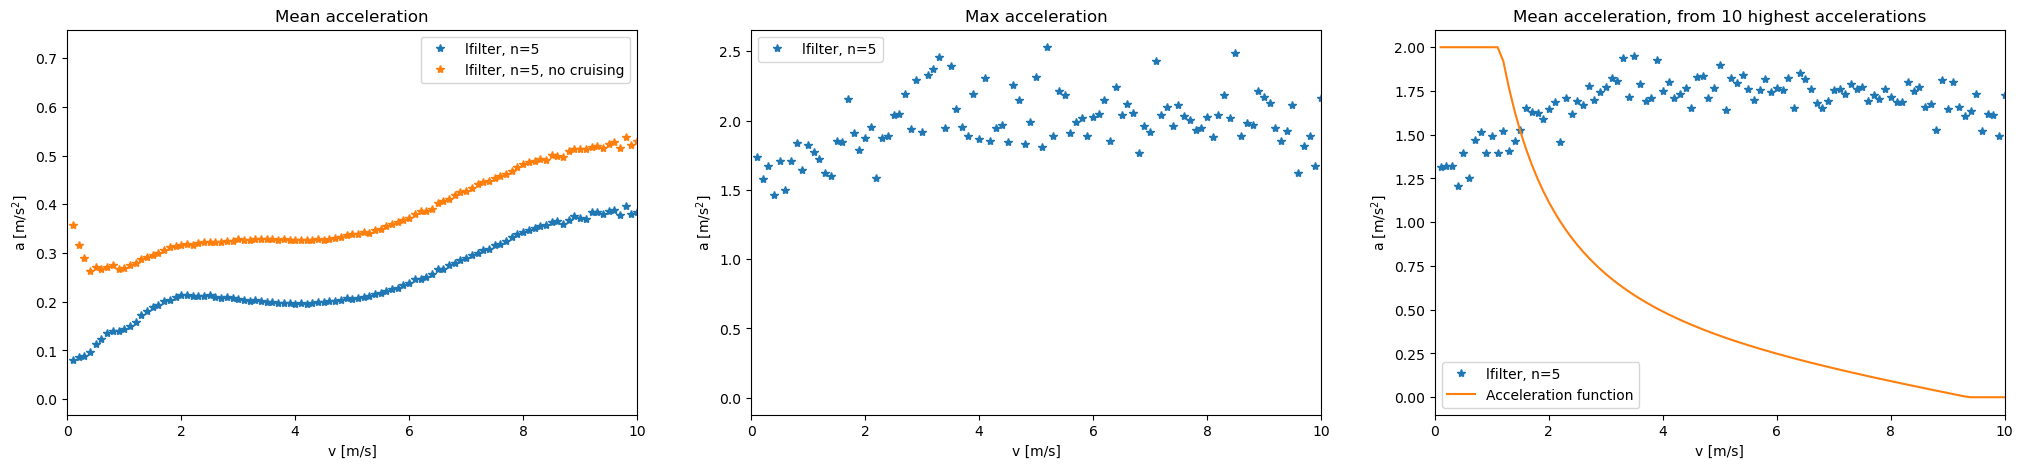

In [146]:
fig = plt.figure(figsize=(25, 5))
    
plt.subplot(1,3,1)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
#plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].agg(["mean"]), "*", label="No smoothing")
#plt.plot([x/10 for x in range(1,201)], GM_testa.groupby("vel_bin")["acc_smooth_test"].agg(["mean"]), "*", label="EMA, n=3")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="lfilter, n=5")
plt.plot([x/10 for x in range(1,201)], GM_a.loc[GM_a["acc_smooth"] >= 0.1].groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="lfilter, n=5, no cruising")


plt.legend()
plt.plot()
plt.xlim([0,10])
plt.title("Mean acceleration")

plt.subplot(1,3,2)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
#plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].nlargest(1), "*", label="No smoothing")
#plt.plot([x/10 for x in range(1,201)], GM_testa.groupby("vel_bin")["acc_smooth_test"].nlargest(1), "*", label="EMA n=3")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].nlargest(1), "*", label="lfilter, n=5")
plt.legend()
plt.xlim([0,10])
plt.title("Max acceleration")

plt.subplot(1,3,3)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
#plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.nlargest(10).mean()), "*", label="No smoothing")
#plt.plot([x/10 for x in range(1,201)], GM_testa.groupby("vel_bin")["acc_smooth_test"].apply(lambda x: x.nlargest(10).mean()), "*", label="EMA, n=3")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).mean()), "*", label="lfilter, n=5")

plt.plot(vel_list, acc_list, "-", label="Acceleration function")
plt.legend()
plt.xlim([0,10])
plt.title("Mean acceleration, from 10 highest accelerations")



plt.show()

We can attempt to polyfit a function to the mean-max acceleration

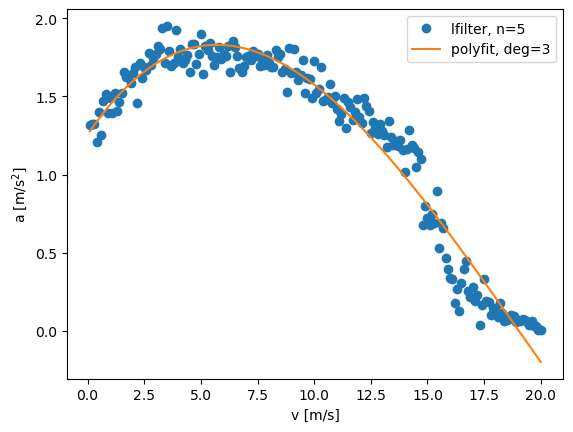

In [147]:
x = [x/10 for x in range(1,201)]

y = GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).nsmallest(10).mean())

coef = np.polyfit(x,y,3)
poly2d_fn = np.poly1d(coef) 
 
plt.plot(x, y, "o", label="lfilter, n=5")
plt.plot(x, poly2d_fn(x), label="polyfit, deg=3")
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.legend()
#plt.xlim(0, 20)
#plt.ylim(-2, 0)
plt.show()

Or to the mean acceleration

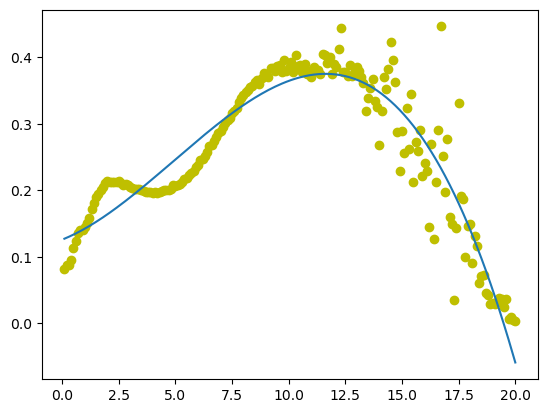

In [148]:
x = [x/10 for x in range(1,201)]

#y = GM_d.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nsmallest(10).mean())
y = GM_a.groupby("vel_bin")["acc_smooth"].agg(["mean"])["mean"]

coef = np.polyfit(x,y,3)
poly2d_fn = np.poly1d(coef) 
 
plt.plot(x,y, 'yo', x, poly2d_fn(x))
#plt.xlim(0, 20)
#plt.ylim(-2, 0)
plt.show()

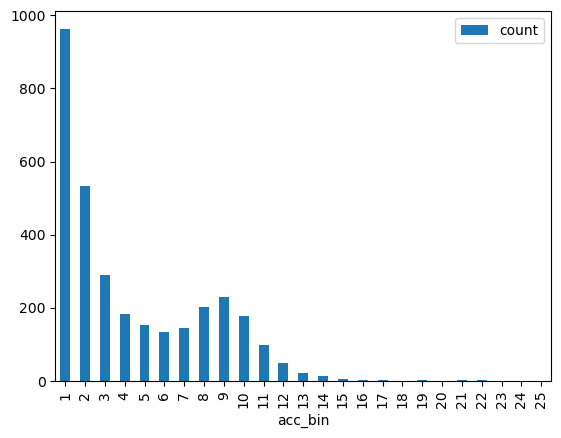

In [68]:
#we can look at the distribution of the acceleration for one specific velocity
vel = 100

GM_a.loc[GM_a["vel_bin"]==vel].groupby("acc_bin")["vel_smooth"].agg(["count"]).plot.bar();


It might be interesting to be able to compare individual trips so we do the same but try to aggregate wrt trip_id as well. It might not work, but let's try...

Since there is so little data (comparatively) for one trip we bin the velocities in 1m/s-bins (as opposed to 0.1 m/s as above).

In [71]:
GM_ind = GM.loc[(GM["acc_smooth"] >= 0) & (GM["count"] >=0)][["trip_id", "vel_smooth", "acc_smooth"]].copy()

In [72]:
#Here we simply set the bin-sizes for the average speed
variable = "vel_smooth"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,21):
    bin_edges.append(i/(1))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,21):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM_ind[grouped_variable_name] = pd.cut(
    GM_ind[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [73]:
GM_ind.head(3)

trip_id  vel_smooth  acc_smooth vel_bin
11        0    5.683668    0.005125       6
12        0    5.691407    0.357779       6
13        0    6.231653    0.138131       7

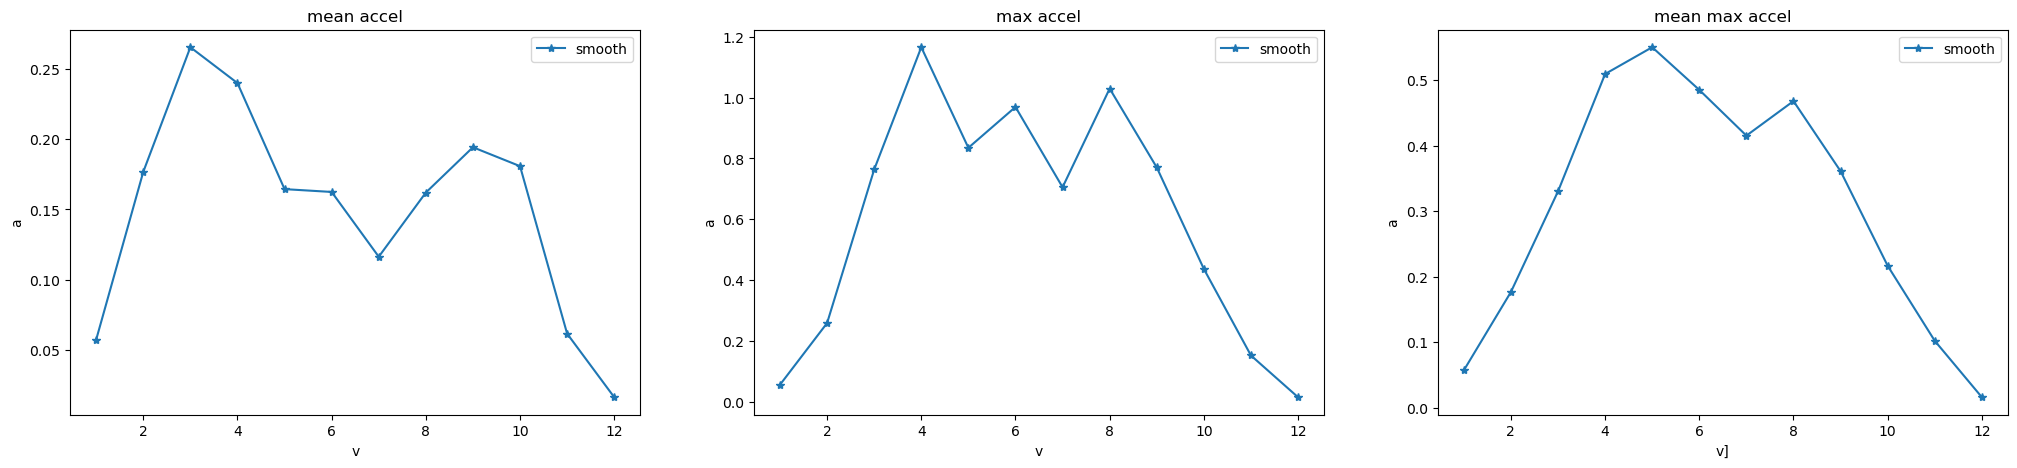

In [74]:
fig = plt.figure(figsize=(25, 5))
    
#mean_acc = GM_a.groupby("vel_bin")["acc_smooth"].agg(["mean"])
#max_acc = GM_a.groupby("vel_bin")["acc_smooth"].nlargest(1)
#meanmax_acc = GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).mean())

trip_id = 4

plt.subplot(1,3,1)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/1 for x in range(1,21)], GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].agg(["mean"]), "-*", label="smooth")
#plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].agg(["mean"]), "*", label="OG")
plt.legend()
plt.plot()
plt.title("mean accel")

plt.subplot(1,3,2)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/1 for x in GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].nlargest(1).reset_index(1).index.tolist()], GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].nlargest(1).reset_index(1)["acc_smooth"], "-*", label="smooth")
#plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].nlargest(1), "*", label="OG")
plt.legend()
plt.title("max accel")

plt.subplot(1,3,3)
plt.xlabel("v]")
plt.ylabel("a")
plt.plot([x/1 for x in GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).mean()).index.tolist()], GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).mean()), "-*", label="smooth")
#plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.nlargest(10).mean()), "*", label="OG")
#plt.plot(vel_list, acc_list, "*", label="function")
plt.legend()
plt.title("mean max accel")



plt.show()

/Users/johannaskantorp/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


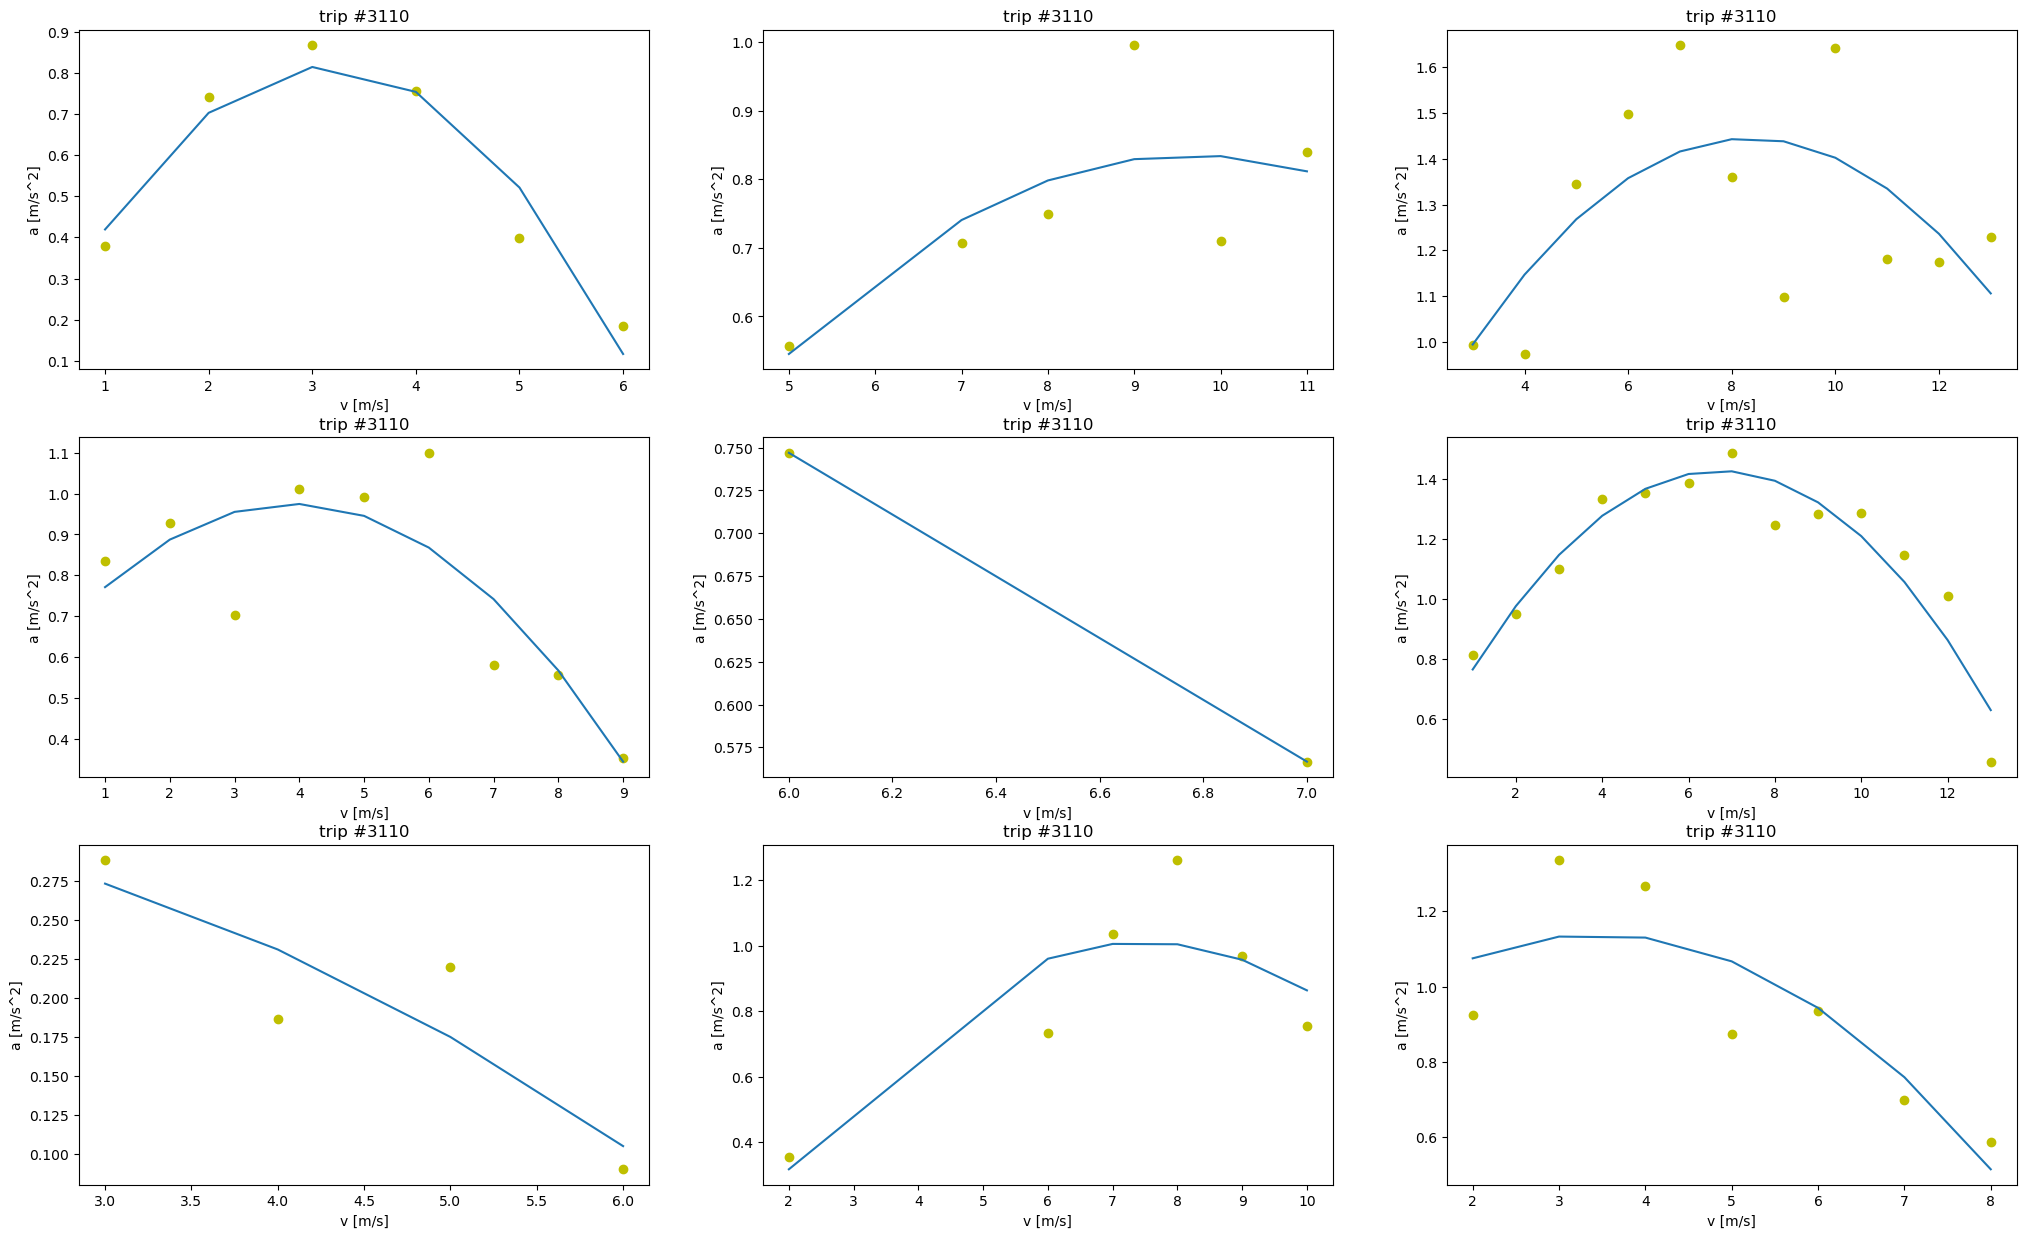

In [75]:
N = 9

min_vals = 5
n = 2

trip_ids = GM.trip_id.unique().tolist()
trips = [random.randint(0,len(trip_ids)) for x in range(N)]

fig = plt.figure(figsize=(25, 5*round(N/3)))


X = [x/10 for x in range(1,201)]
Y = GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).mean())

coef = np.polyfit(x,y,2)
poly_OG = np.poly1d(coef) 




for i in range(N):
    trip_id = trip_ids[trips[i]]
    x = [x/1 for x in GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(n).mean()).loc[GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].agg("count").values >= min_vals].index.tolist()]
    y = GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(n).mean()).loc[GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].agg("count").values >= min_vals]
    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("v [m/s]")
    plt.ylabel("a [m/s^2]")
    coef = np.polyfit(x,y,2)
    poly2d_fn = np.poly1d(coef) 

    plt.plot(x,y, 'yo', x, poly2d_fn(x))
    #plt.plot(X, poly_OG(X))
    #plt.xlim([min(x)-1, max(x)+1])
    #plt.ylim([min(y), max(y)])
    plt.title("trip #"+str(trip))

plt.show()


## Deceleration

We do the same for deceleration

In [149]:
GM_d = GM.loc[(GM["acc_smooth"] <= 0) & (GM["count"]>=0)][["vel_smooth", "acc_smooth"]].copy()
print(GM_d["vel_smooth"].nlargest(1))
print(GM_d["acc_smooth"].nsmallest(1))

3109431    19.908977
Name: vel_smooth, dtype: float64
3109673   -2.435303
Name: acc_smooth, dtype: float64


In [150]:
#Here we simply set the bin-sizes for the average speed
variable = "vel_smooth"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = []
for i in range(201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM_d[grouped_variable_name] = pd.cut(
    GM_d[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

#Here we simply set the bin-sizes for the average speed
variable = "acc_smooth"  
grouped_variable_name = "dec_bin"

#set the edges of the bins
bin_edges = []
k=24
for i in range(25):
    j=k-i
    bin_edges.append(-j/10)

#name the bins (should be one less than bin_edges)
bin_labels = []
k=24
for i in range(1,25):
    j=k-i
    bin_labels.append(-j)

# This part does the grouping based on the input above
GM_d[grouped_variable_name] = pd.cut(
    GM_d[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [151]:
GM_OGd = GM.loc[(GM["acc"] <= 0) & (GM["count"]>=0)][["vel", "acc"]].copy()
print(GM_OGd["vel"].nlargest(1))
print(GM_OGd["acc"].nsmallest(1))

1431624    19.992147
Name: vel, dtype: float64
1808846   -11.335565
Name: acc, dtype: float64


In [152]:
#Here we simply set the bin-sizes for the average speed
variable = "vel"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = []
for i in range(201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM_OGd[grouped_variable_name] = pd.cut(
    GM_OGd[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not


In [153]:
#mean_dec = GM_d.groupby("vel_bin")["acc_smooth"].agg(["mean"])
#max_dec = GM_d.groupby("vel_bin")["acc_smooth"].nsmallest(1)
#meanmax_dec = GM_d.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nsmallest(10).mean())

vel_smooth  acc_smooth vel_bin dec_bin
5         13.545133   -0.108358     136      -1
6         13.381513   -0.948174     134      -9
7         11.949770   -1.677887     120     -16
8          9.416160   -1.244694      95     -12
9          7.536673   -0.918919      76      -9
...             ...         ...     ...     ...
4327020    5.727574   -0.229463      58      -2
4327021    5.381085   -0.311701      54      -3
4327022    4.910416   -0.205625      50      -2
4327024    4.715514   -0.100953      48      -1
4327025    4.563075   -0.152705      46      -1

[2154624 rows x 4 columns]

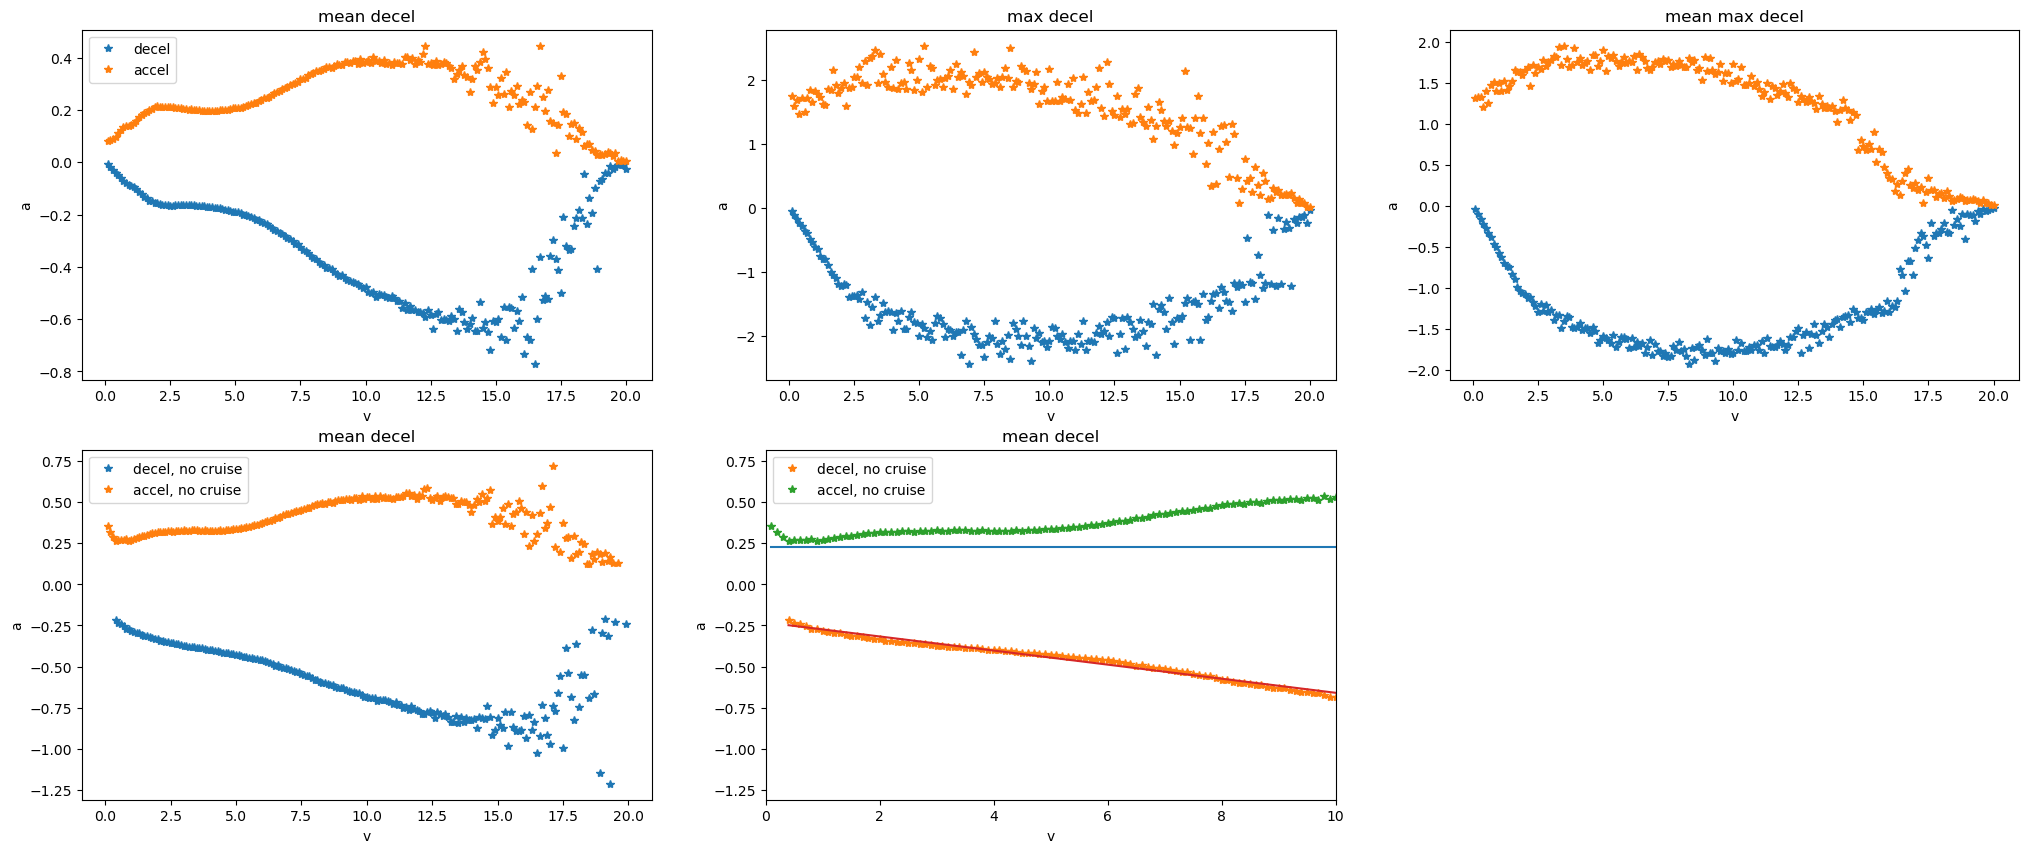

In [180]:
fig = plt.figure(figsize=(25, 10))

plt.subplot(2,3,1)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/10 for x in range(1,201)], GM_d.groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="decel")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="accel")
plt.legend()
plt.title("mean decel")

plt.subplot(2,3,2)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/10 for x in range(1,201)], GM_d.groupby("vel_bin")["acc_smooth"].nsmallest(1), "*")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].nlargest(1), "*", label="smooth")

plt.title("max decel")

plt.subplot(2,3,3)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/10 for x in range(1,201)], GM_d.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nsmallest(10).nlargest(10).mean()), "*")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()), "*", label="smooth")
plt.title("mean max decel")

plt.subplot(2,3,4)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/10 for x in range(1,201)], GM_d.loc[GM_d["dec_bin"] <= -2].groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="decel, no cruise")
plt.plot([x/10 for x in range(1,201)], GM_a.loc[GM_a["acc_bin"] >= 2].groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="accel, no cruise")
plt.legend()
plt.title("mean decel")

plt.subplot(2,3,5)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/10 for x in range(1,201)], [0.23 for x in range(1,201)])
plt.plot([x/10 for x in range(1,201)], GM_d.loc[GM_d["dec_bin"] <= -2].groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="decel, no cruise")
plt.plot([x/10 for x in range(1,201)], GM_a.loc[GM_a["acc_bin"] >= 2].groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="accel, no cruise")

y = GM_d.loc[GM_d["dec_bin"] <= -2].groupby("vel_bin")["acc_smooth"].agg(["mean"]).dropna()["mean"].tolist()[0:97]
x = [k/10 for k in GM_d.loc[GM_d["dec_bin"] <= -2].groupby("vel_bin")["acc_smooth"].agg(["mean"]).dropna()["mean"].index.tolist()][0:97]

coef = np.polyfit(x,y,1)
poly2d_fn = np.poly1d(coef) 

plt.plot(x, poly2d_fn(x))

plt.legend()
plt.xlim([0,10])
plt.title("mean decel")


plt.show()

[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0]


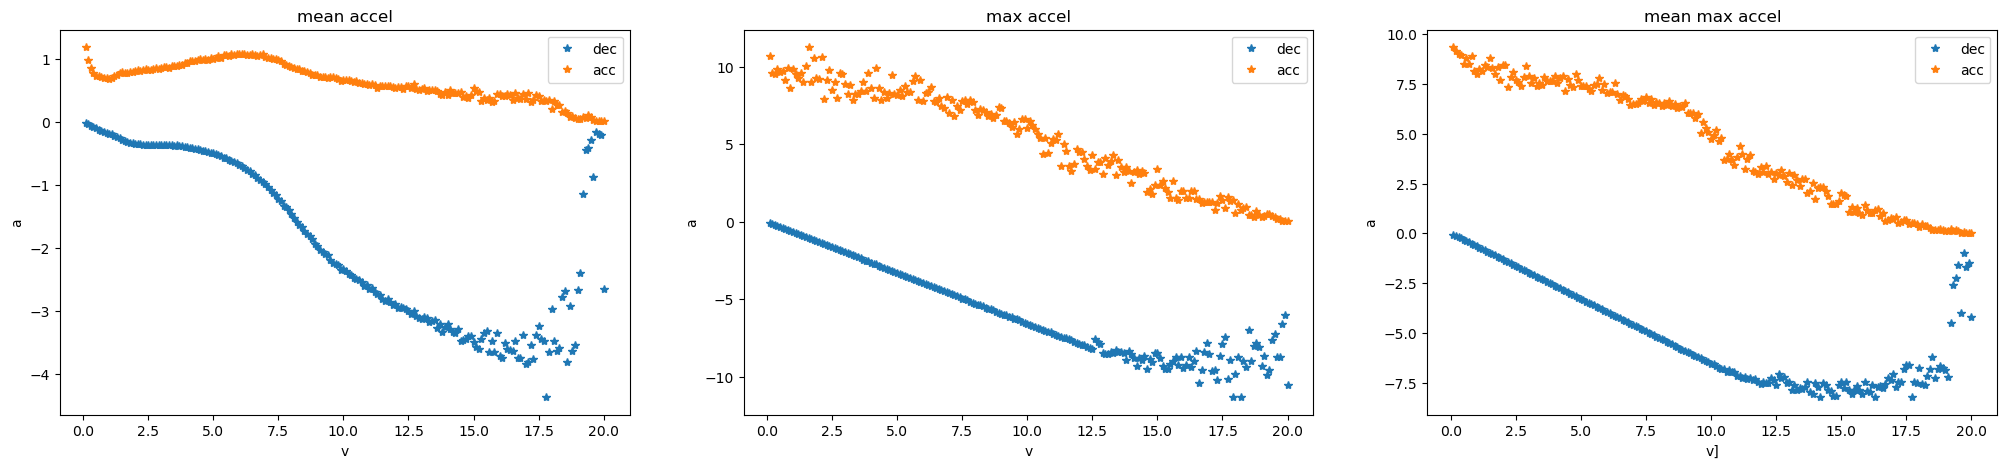

In [92]:
fig = plt.figure(figsize=(25, 5))
    
plt.subplot(1,3,1)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/10 for x in range(1,201)], GM_OGd.groupby("vel_bin")["acc"].agg(["mean"]), "*", label="dec")
plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].agg(["mean"]), "*", label="acc")
plt.legend()
plt.plot()
plt.title("mean accel")

plt.subplot(1,3,2)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/10 for x in range(1,201)], GM_OGd.groupby("vel_bin")["acc"].nsmallest(1), "*", label="dec")
plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].nlargest(1), "*", label="acc")
plt.legend()
plt.title("max accel")

plt.subplot(1,3,3)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/10 for x in range(1,201)], GM_OGd.groupby("vel_bin")["acc"].apply(lambda x: x.nsmallest(10).mean()), "*", label="dec")
plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.nlargest(10).mean()), "*", label="acc")
#plt.plot(vel_list, acc_list, "-", label="function")
plt.legend()
plt.title("mean max accel")


plt.show()

In [174]:
GM_OG = GM.loc[(GM["acc"] >= 0) & (GM["count"] >= 0)][["vel", "acc"]].copy()

#Here we simply set the bin-sizes for the average speed
variable = "vel"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,21):
    bin_edges.append(i/(1))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,21):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM_OG[grouped_variable_name] = pd.cut(
    GM_OG[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [198]:
variables = ["vel_bin"] 

GM_count = (
    GM_OG
    .groupby(variables)
    .agg("count")
    .reset_index()
)  # Aggregation to tariff cells

#plt.xlabel(str(variables[0])+ " [m/10s]")
#plt.bar([x/10 for x in GM_count.index.tolist()], GM_count["vel_smooth"])
#plt.title("how many instances of this "+ str(variables[0]))
#plt.show()
#GM_count

[-0.04624623  1.2117235 ]


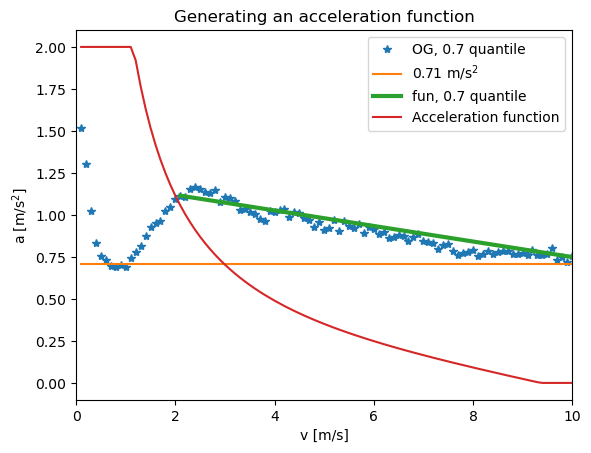

In [849]:

plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
#plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()), "*", label="No smoothing")
plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(0.7)), "*", label="OG, 0.7 quantile")
#plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).mean()), "*", label="smooth, max-mean")

#plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.mean()), "*", label="smooth, mean")

#plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.quantile(0.9)), "*", label="smooth, 0.9 quantile")
plt.plot([x/10 for x in range(1,201)], [0.71 for y in range(1,201)], label="0.71 m/s$^2$")


x = [x/10 for x in range(1,201)][0:25]


y1 = GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(0.7)).tolist()[0:25]
coef1 = np.polyfit(x,y1,3)
poly2d_1 = np.poly1d(coef1) 


#x2 = [[x/10 for x in range(1,201)][20], [x/10 for x in range(1,201)][100]]
#y2 = [GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(0.7)).tolist()[20], GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(0.7)).tolist()[100]]
#coef2 = np.polyfit(x2,y2,1)
#poly2d_2 = np.poly1d(coef2)

x2 = [x/10 for x in range(1,201)][20:101]
y2 = GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(0.7)).tolist()[20:101]
poly2d_2 = np.poly1d(coef2)
print(coef2)

#plt.plot(x, poly2d_1(x), "-", linewidth=3,label="fun, 0.7 quantile")
plt.plot(x2, poly2d_2(x2), "-", linewidth=3,label="fun, 0.7 quantile")



plt.plot(vel_list, acc_list, "-", label="Acceleration function")
plt.xlim([0,10])
plt.legend()
plt.title("Generating an acceleration function")


plt.show()

In [841]:
GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(0.7)).tolist()[23]

1.1670243755903944

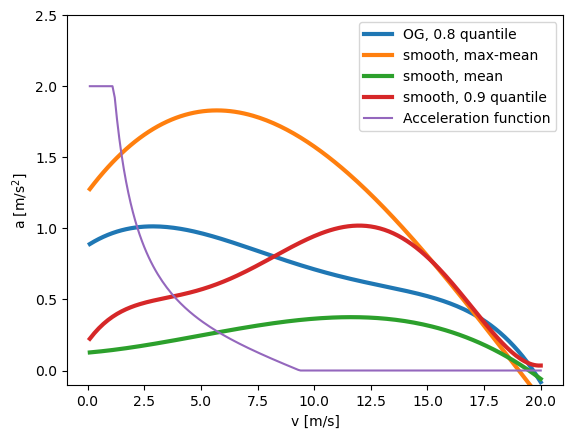

In [821]:
x = [x/10 for x in range(1,201)]

y = GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).nsmallest(10).mean())

y1 = GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(0.7))
y2 = GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).mean())
y3 = GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.mean())
y4 = GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.quantile(0.9))


coef1 = np.polyfit(x,y1,5)
coef2 = np.polyfit(x,y2,3)
coef3 = np.polyfit(x,y3,3)
coef4 = np.polyfit(x,y4,5)

poly2d_1 = np.poly1d(coef1) 
poly2d_2 = np.poly1d(coef2) 
poly2d_3 = np.poly1d(coef3) 
poly2d_4 = np.poly1d(coef4) 
 
plt.plot(x, poly2d_1(x), "-", linewidth=3,label="OG, 0.8 quantile")
plt.plot(x, poly2d_2(x), "-", linewidth=3,label="smooth, max-mean")
plt.plot(x, poly2d_3(x), "-", linewidth=3,label="smooth, mean")
plt.plot(x, poly2d_4(x), "-", linewidth=3,label="smooth, 0.9 quantile")
plt.plot(vel_list, acc_list, "-", label="Acceleration function")
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.legend()
#plt.xlim(0, 20)
plt.ylim(-0.1, 2.5)
plt.show()

In [512]:
print("coef=", coef2)
print("poly2d = np.poly1d(coef)")
print("acc = poly2d(v)")



coef= [ 3.85308393e-04 -2.20331637e-02  2.13837555e-01  1.25533665e+00]
poly2d = np.poly1d(coef)
acc = poly2d(v)


## Conclusion

It honestly bothers me that the smoothed acceleration/deceleration are to some degree mirror images of each other. It's clear that this can't really happen with the unsmoothed since deceleration is just mostly the line y = -x. 
But still, it vexes me *smokes pipe for old-timey reasons*

I do think the smoothing is OK, but would loove the OG time-stamps. Just get me their entire processing-process and we could call it a day. I forgot my ADHD-medicine today so ..

In [112]:
[a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,y,u,v,w,x,y,z] = [".","--","%","+","==","€","/¯","\_","##","_|","<<", "||_", "^", "/|", "0", ")", "Q","(ツ","¯","?",")_", "V", "/\*", "Y","&","r"]

print(s+h+r+u+g)

¯\_(ツ)_/¯


I mean, this happens because we cannot tell the smooting function that drastic drops are more realistic than drastic increases (the mirror images, not my procrastination). 



The smoothing function (rolling mean with n=5) works well *because* we get very similar results as 
Parkin et. al. 

In [338]:
print("  We have mean velocity:", round(GM.loc[GM["count"]>=0]["vel_smooth"].mean(),2), " and mean acceleration:", round(GM.loc[(GM["count"]>=0)&(GM["acc_smooth"]>=0)]["acc_smooth"].mean(),3))

print("They have mean velocity: 5.98 and mean acceleration: 0.247" )

  We have mean velocity: 5.0  and mean acceleration: 0.231
They have mean velocity: 5.98 and mean acceleration: 0.247


Their "proposition for acceleration" is that acceleration is (practically) constant until final speed is reached, Then cruising speed is kept until forced to break. 

## Randomly plot N trips

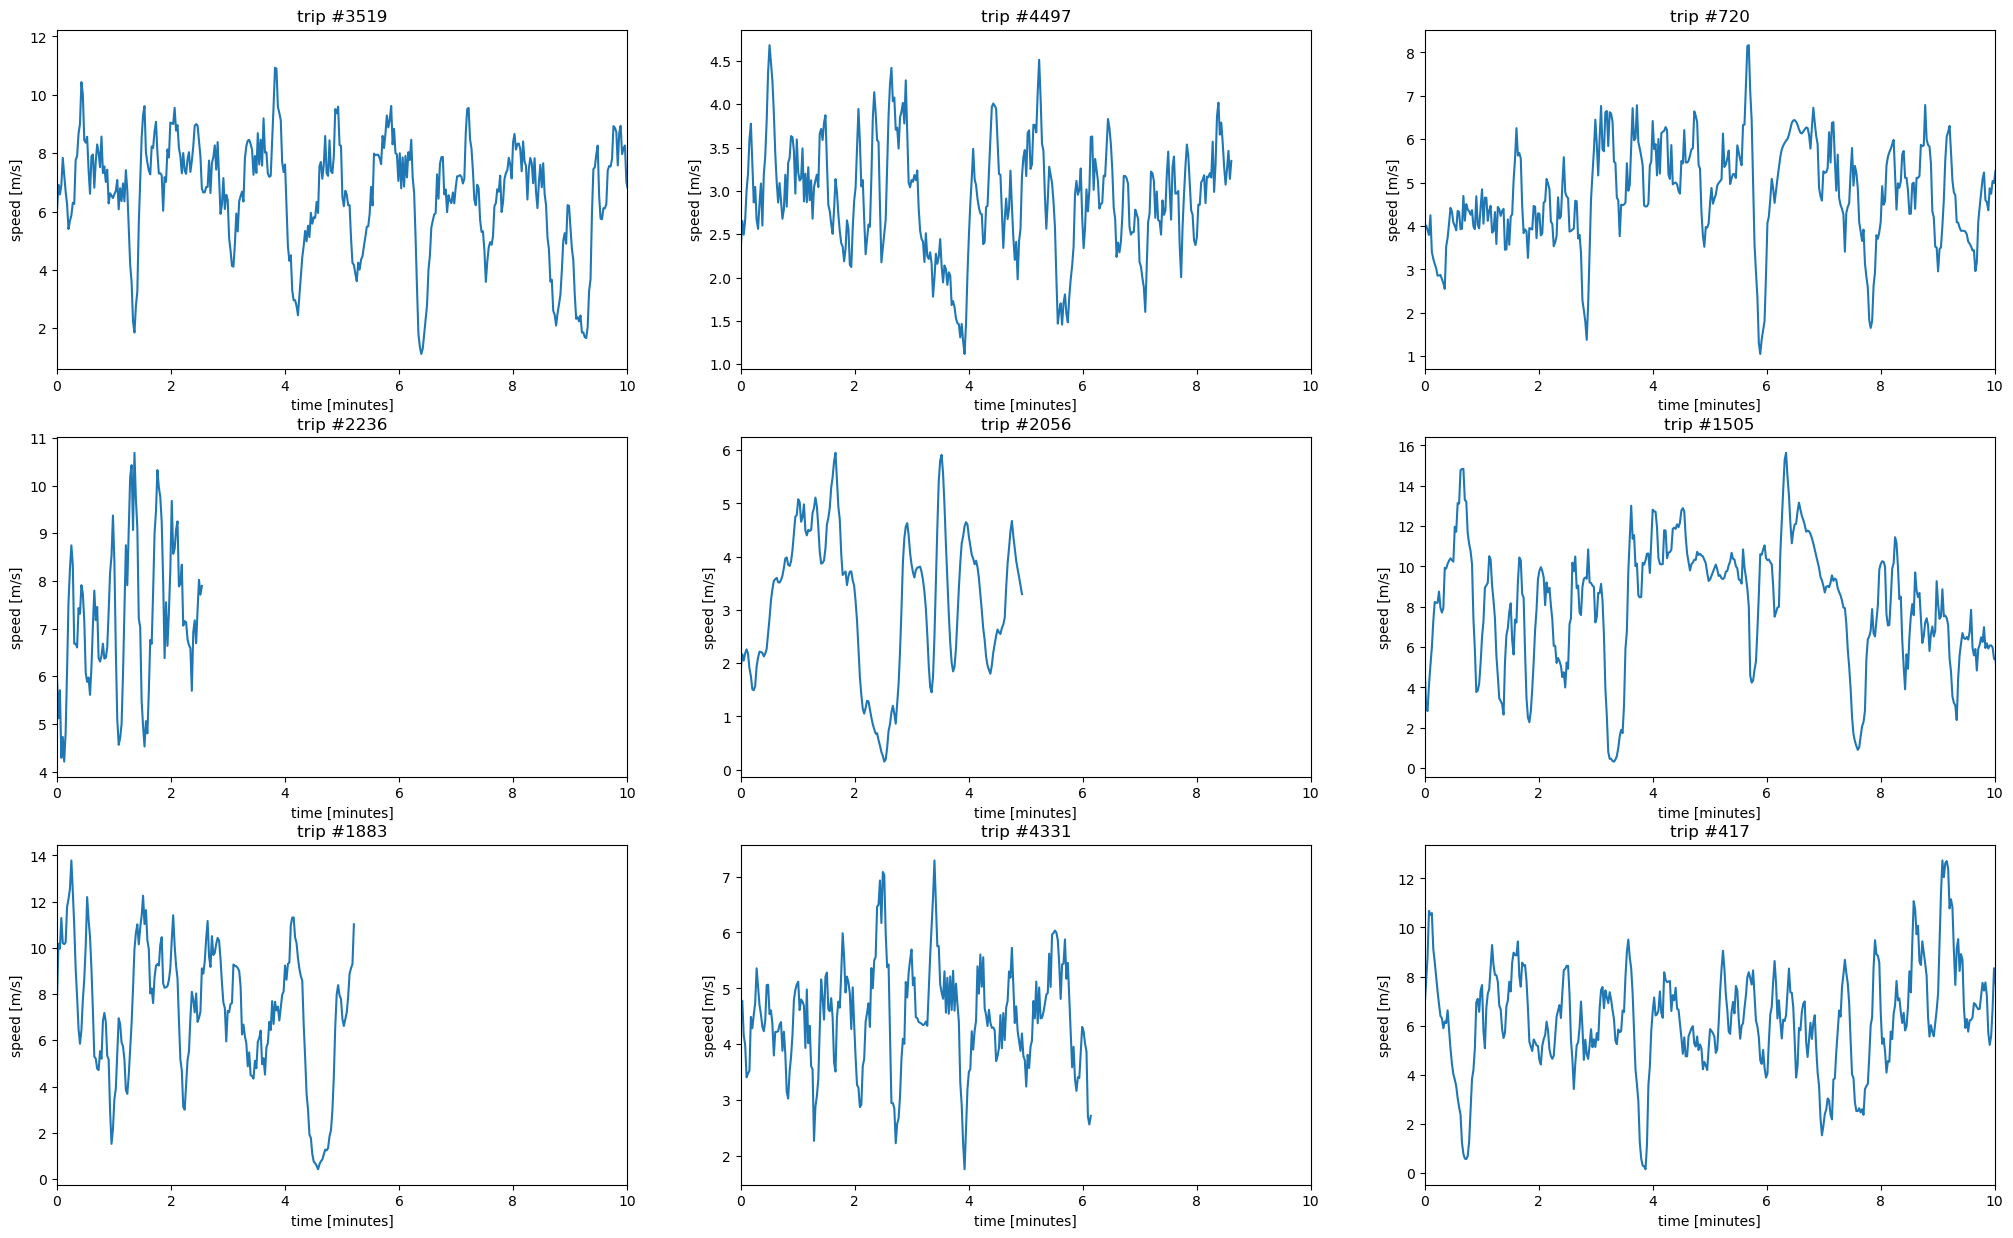

In [343]:
N = 9

trip_ids = GM.trip_id.unique().tolist()
trips = [random.randint(0,len(trip_ids)) for x in range(N)]

fig = plt.figure(figsize=(25, 5*round(N/3)))

for i in range(N):
    trip = trip_ids[trips[i]]
    times = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["time_sum"].tolist()
    vels = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["vel_smooth"]
    
    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("time [minutes]")
    plt.ylabel("speed [m/s]")
    plt.plot(times, vels, "-")
    #plt.plot([1,2,3], [1,2,3], "-")
    plt.xlim([0, 10])
    plt.title("trip #"+str(trip))

plt.show()

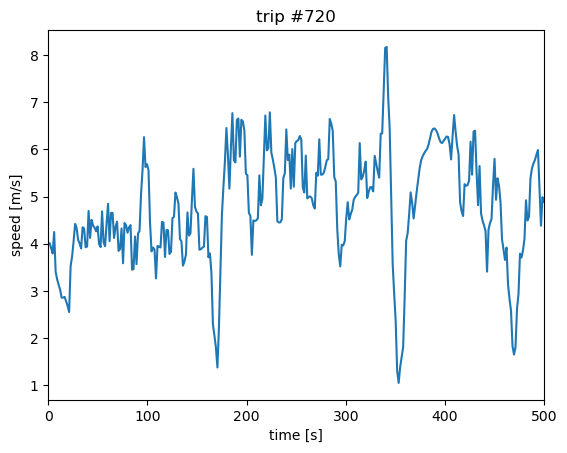

In [353]:
trip = 720
times = [x*60 for x in GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["time_sum"].tolist()]
vels = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["vel_smooth"]
    
plt.xlabel("time [s]")
plt.ylabel("speed [m/s]")
plt.plot(times, vels, "-")
    #plt.plot([1,2,3], [1,2,3], "-")
plt.xlim([0, 500])
plt.title("trip #"+str(trip))

plt.show()

<AxesSubplot:>

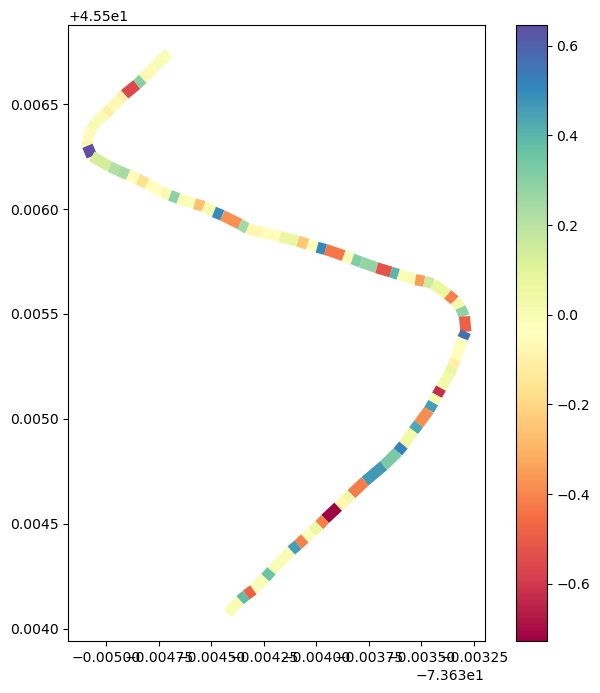

In [380]:
trip = 720

#GM.loc[(GM["trip_id"] == trip) &(GM["time_sum"]<= 10) & (GM["count"]>=0)].plot(column="vel_smooth", alpha=1, cmap="plasma", linewidth=8, figsize=(8, 8), legend=True)

GM.loc[(GM["trip_id"] == trip) & (GM["time_sum"]<= 2) & (GM["count"]>=0)].plot(column="acc_smooth", alpha=1, cmap="Spectral", linewidth=8, figsize=(8, 8), legend=True)


In [ ]:
sns.relplot(data=GM.loc[GM["trip_id"] == 720], x='Weight (kg)', y='Height (cm)', hue='Gender', hue_order=_genders, aspect=1.61)
plt.show()

In [359]:
import seaborn as sns

vel_bin
1      0.081262
2      0.087128
3      0.087635
4      0.095736
5      0.113579
         ...   
196    0.035999
197    0.006436
198    0.008745
199    0.004737
200    0.003866
Name: acc_smooth, Length: 200, dtype: float64

# Stops
find and plot all stops to get a better understanding of them

In [382]:
velocities = GM.loc[GM["count"] >= 0]["vel_smooth"].tolist()
stops = []
state = 0
one_stop = []

for i in range(1, len(velocities)):
    v = velocities[i]
    if state == 0 and v <= 1:
        one_stop.append(v)
        state = 0
    elif state == 0 and v > 1:
        one_stop.append(v)
        stops.append(one_stop)
        state = 1
    elif state == 1 and v <=1:
        one_stop = [velocities[i-1], v]
        state = 0
    else: #state = 1 v > 1
        state = 1
    

In [1498]:
#state 0 means we are in a "stop-period"
#state 1 means we are in a "drive-period"

max_vel = 1#limit for what is considered "stop"
velocities = GM.loc[GM["count"] >= 0]["vel"].tolist()
trip_idx = GM.loc[GM["count"] >= 0]["trip_id"].tolist()
stops = []    #list to save all stop-periods

state = 1     #we start in a drive-period (I know this because I know the data, might have to change if other data is used)
one_stop = [] #list to save all velocities for one stop-period
idx_stop = 0  #initial index
stops_idx = []#keep track of corresponding index to the stop

top_vel_list = []  #keep track of top recorded velocity between stops
top_vel = 0



for i in range(1, len(velocities)): 
    v = velocities[i]                  #current vel
    
    if state == 0 and v <= max_vel:    #we are in a stop-period and we stay there
        one_stop.append(v)             #keep adding "stop-period"-velocities, 
        #state = 0                     #stay in state
        
    elif state == 0 and v > max_vel:   #we are leaving a stop-period
        if idx_stop == trip_idx[i]:    #make sure we are still on the same trip
            top_vel = max(top_vel, v)
            stops_idx.append(idx_stop) #save index of trip corresponding to this stop
            one_stop.append(v)         #add vel *just after* stop-period
            stops.append(one_stop)     #save this stop
            top_vel_list.append(top_vel)#add highest vel between prev stop and this to list
            top_vel = 0                #re-set top vel
            state = 1                  #change state
        else:
            state = 1                  #if we changed trips, discard stop, change state
            
    elif state == 1 and v <=max_vel:   #we are entering a stop-period
        one_stop = [velocities[i-1], v]#add vel *just before* stop-period AND first vel *in* stop-period
        idx_stop = trip_idx[i]         #set idx for this stop, to compare with idx at the end of the stop (should match)

        state = 0
    else: #state = 1 v > 1
        top_vel = max(top_vel, v)
        state = 1

In [1499]:
print("NOT SMOOTHED max_vel = 1m/s:")
print("\nDuring", round(len(velocities)*1.51/60), "minutes,", len(stops), "(unique) stops take place, i.e.,", round(len(stops)/(len(velocities)*1.51/60),4), "stops per minute.")
print("\nSince we are currently working with 25 minutes we would expect to see, on average,\n", round(len(stops)/(len(velocities)*1.51/60)*25,2), "stops.")
print("\nThis does not include start and end points")

len_stops = []
for stop in stops:
    len_stops.append((len(stop)-2)*1.51)


print("\n\nThe average length of a stop is", round(np.mean(len_stops),2), "seconds, with std:", round(np.std(len_stops),2),"i.e., the total stoppage time should be", round(mean_len_stop*1.51*len(stops)/(len(velocities)*1.51/60)*25/60,2), "minutes")



NOT SMOOTHED max_vel = 1m/s:

During 107648 minutes, 82269 (unique) stops take place, i.e., 0.7642 stops per minute.

Since we are currently working with 25 minutes we would expect to see, on average,
 19.11 stops.

This does not include start and end points


The average length of a stop is 3.86 seconds, with std: 5.89 i.e., the total stoppage time should be 4.19 minutes


In [1482]:
print("NOT SMOOTHED:")
print("\nDuring", round(len(velocities)*1.51/60), "minutes,", len(stops), "(unique) stops take place, i.e.,", round(len(stops)/(len(velocities)*1.51/60),4), "stops per minute.")
print("\nSince we are currently working with 25 minutes we would expect to see, on average,\n", round(len(stops)/(len(velocities)*1.51/60)*25,2), "stops.")
print("\nThis does not include start and end points")

len_stops = []
for stop in stops:
    len_stops.append((len(stop)-2)*1.51)


print("\n\nThe average length of a stop is", round(np.mean(len_stops),2), "seconds, with std:", round(np.std(len_stops),2),"i.e., the total stoppage time should be", round(mean_len_stop*1.51*len(stops)/(len(velocities)*1.51/60)*25/60,2), "minutes")



NOT SMOOTHED:

During 107648 minutes, 135282 (unique) stops take place, i.e., 1.2567 stops per minute.

Since we are currently working with 25 minutes we would expect to see, on average,
 31.42 stops.

This does not include start and end points


The average length of a stop is 5.1 seconds, with std: 10.54 i.e., the total stoppage time should be 6.88 minutes


In [487]:
print("During", round(len(velocities)*1.51/60), "minutes,", len(stops), "(unique) stops take place, i.e.,", round(len(stops)/(len(velocities)*1.51/60),4), "stops per minute.")
print("\nSince we are currently working with 25 minutes we would expect to see, on average,\n", round(len(stops)/(len(velocities)*1.51/60)*25,2), "stops.")
print("\nThis does not include start and end points")

len_stops = []
for stop in stops:
    len_stops.append((len(stop)-2)*1.51)


print("\n\nThe average length of a stop is", round(np.mean(len_stops),2), "seconds, with std:", round(np.std(len_stops),2),"i.e., the total stoppage time should be", round(mean_len_stop*1.51*len(stops)/(len(velocities)*1.51/60)*25/60,2), "minutes")





During 107648 minutes, 38951 (unique) stops take place, i.e., 0.3618 stops per minute.

Since we are currently working with 25 minutes we would expect to see, on average,
 9.05 stops.

This does not include start and end points


The average length of a stop is 13.14 seconds, with std: 29.49 i.e., the total stoppage time should be 1.98 minutes


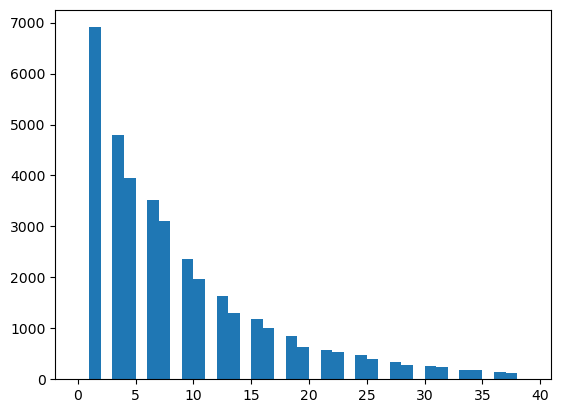

In [488]:
plt.hist(len_stops, bins=[x for x in range(40)]);

ModuleNotFoundError: No module named 'fitter'

This means that we want a constraint that we have to cross between 3 m/s and 2 m/s 9 times and the time spent below should be 2 minutes in total. We can also see that

In [474]:
mean_top_vel = sum(top_vel_list)/len(top_vel_list)

print("The average max vel between stops is", round(mean_top_vel,2), "m/s")

The average max vel between stops is 5.82 m/s


Which is higher than our mean velocity (5.0 m/s). The distribution of the max velocity reached between stops looks like this:

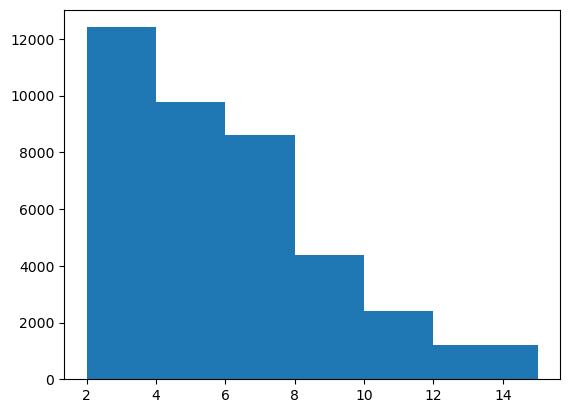

In [475]:
plt.hist(top_vel_list, bins=[2,4,6,8,10,12,15]);

So we could imagine implementing a constraint that it should reach mean vel between stops

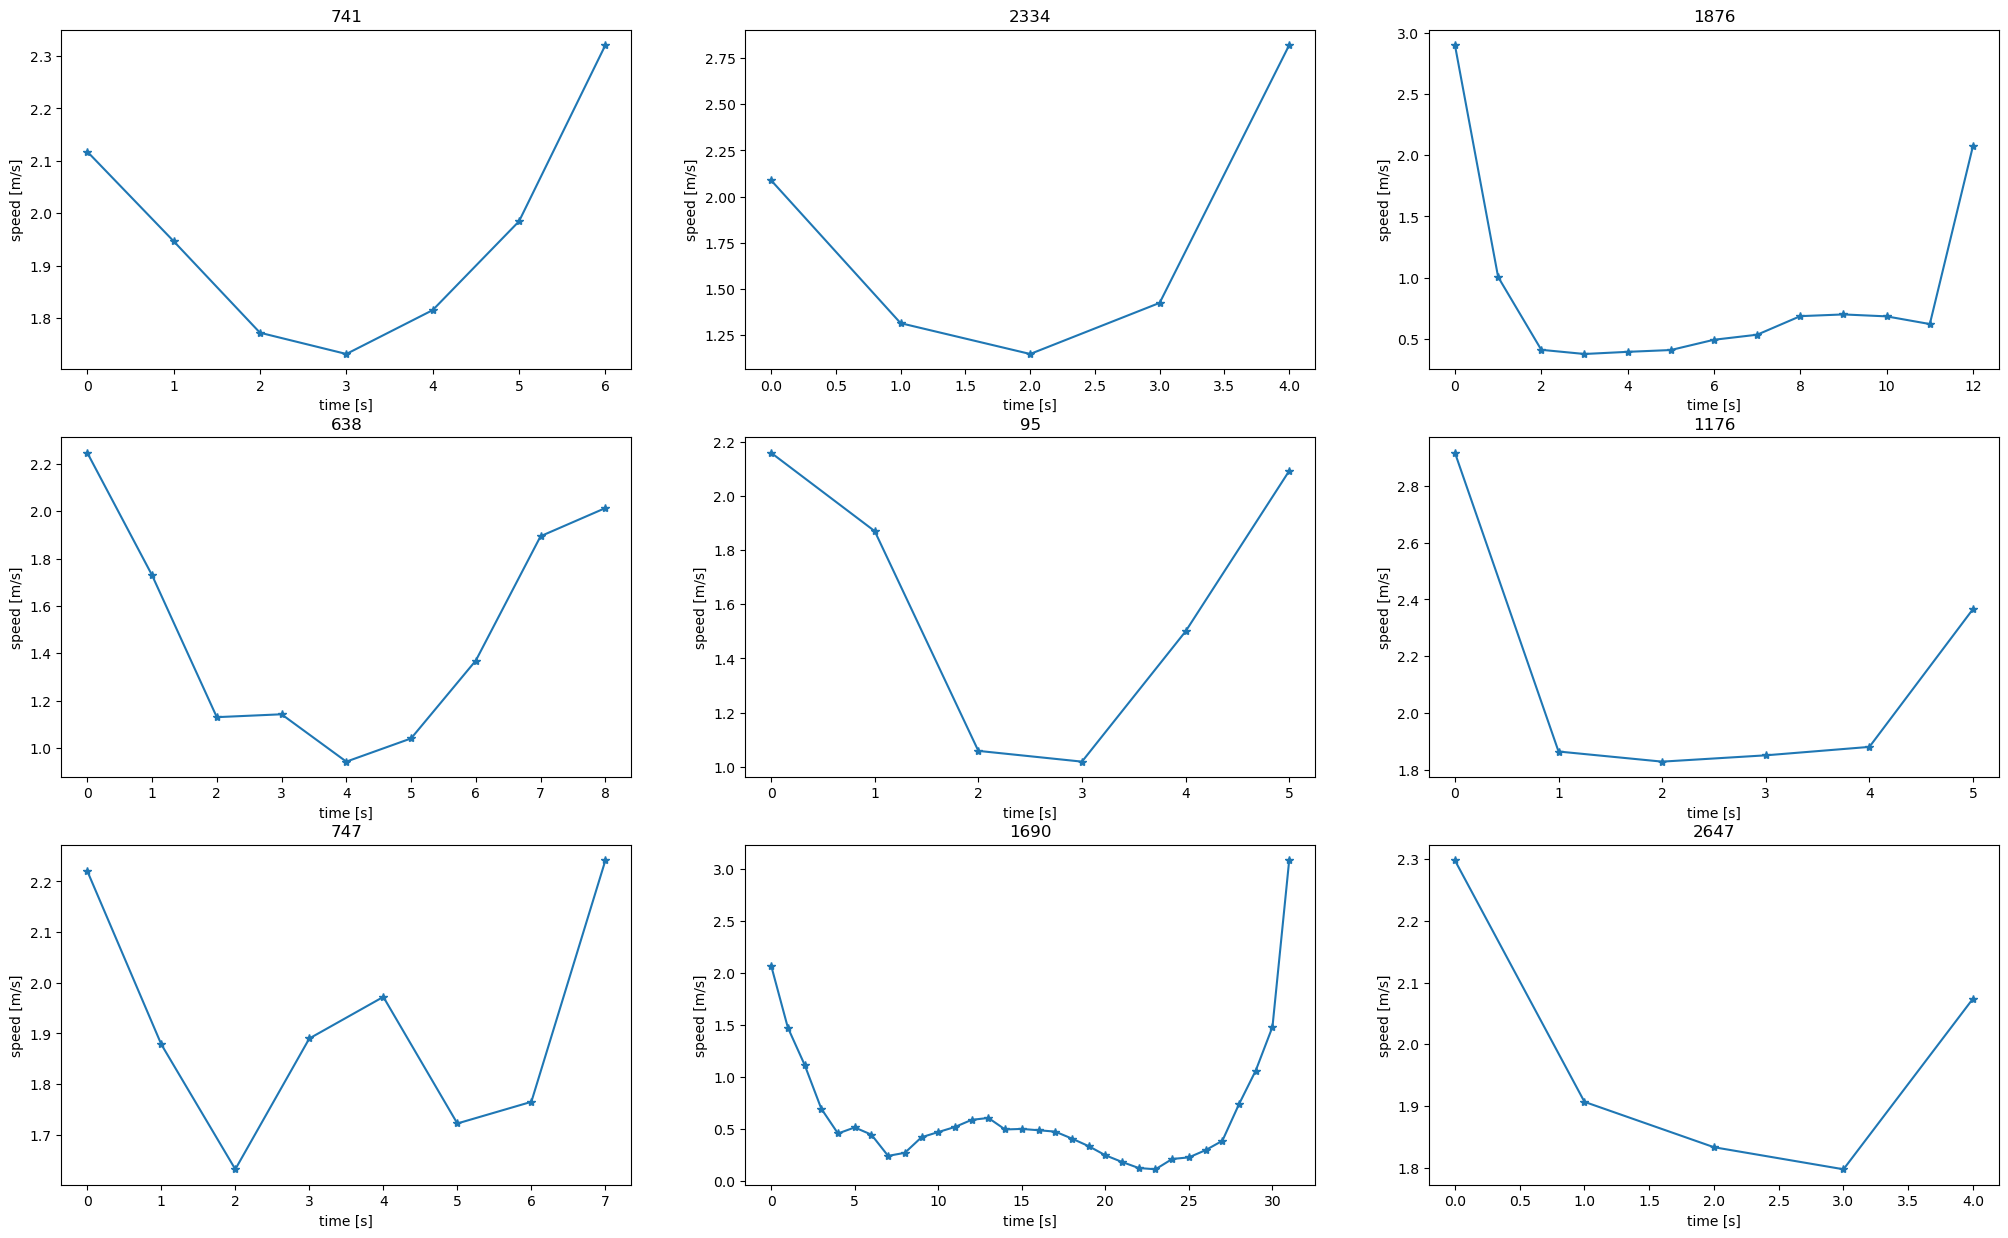

In [419]:
N = 9

stop_idx = [random.randint(0,len(stops)) for x in range(N)]

fig = plt.figure(figsize=(25, 5*round(N/3)))

for i in range(len(stop_idx)):
    one_stop = stops[stop_idx[i]]
    time = [x for x in range(len(stops[stop_idx[i]]))]

    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("time [s]")
    plt.ylabel("speed [m/s]")
    plt.plot(time, one_stop, "-*")
    #plt.plot([1,2,3], [1,2,3], "-")
    plt.title(str(stops_idx[stop_idx[i]]))

plt.show()

In [420]:
print("sooo prettty:", stop_idx[6])
print("with trip_id", stops_idx[23918])

sooo prettty: 7528
with trip_id 2376


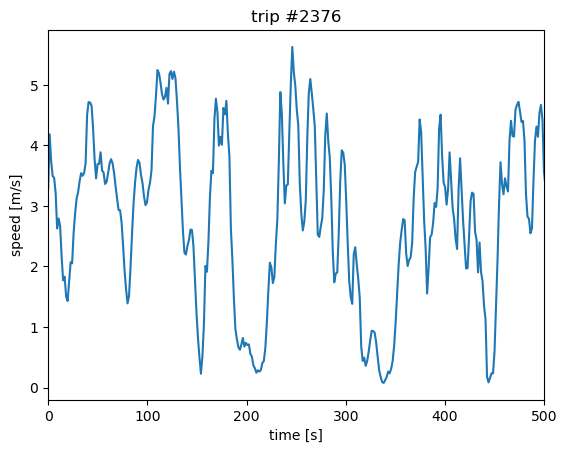

In [819]:
trip = 2376
times = [x*60 for x in GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["time_sum"].tolist()]
vels = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["vel_smooth"]
    
plt.xlabel("time [s]")
plt.ylabel("speed [m/s]")
plt.plot(times, vels, "-")
    #plt.plot([1,2,3], [1,2,3], "-")
plt.xlim([0, 500])
plt.title("trip #"+str(trip))

plt.show()

10.705039665220404


## Is this the dataframe you have been looking for?


When you want to access only some of the data, this is how you do it:
The main tool is .loc; Pandas DataFrame.loc attribute access a group of rows and columns by label(s) or a boolean array in the given Pandas DataFrame. (There also an attribute called .iloc which access based on index.) 

I named our DataFrame GM. We can print the first two rows of our dataframe using

In [1300]:
GM.head(2)

geo  trip_id     length  \
0  LINESTRING (-73.57748 45.50690, -73.57751 45.5...        0   4.164946   
1  LINESTRING (-73.57751 45.50692, -73.57757 45.5...        0  12.379816   

     vel_og  time  Z_val_20       vel  vel_smooth  count  total_time  acc  \
0  2.758243  1.51 -0.986791  2.758243    0.551649     -1       9.966  NaN   
1  8.198554  1.51  0.092033  8.198554    2.191359     -1       9.966  NaN   

   acc_smooth  
0         NaN  
1         NaN

If we only want to look at some specific columns we dont use loc (I keep using head, because otherwise this explanation becomes very long).

In [1304]:
GM[["vel", "acc"]].head(2)

vel  acc
0  2.758243  NaN
1  8.198554  NaN

But say we only want to look at rows 20-22, we can use loc to do this

In [1305]:
GM.loc[[20,21,22]]

geo  trip_id     length  \
20  LINESTRING (-73.57764 45.50840, -73.57752 45.5...        0  18.968759   
21  LINESTRING (-73.57752 45.50852, -73.57742 45.5...        0  15.342079   
22  LINESTRING (-73.57742 45.50862, -73.57738 45.5...        0   6.769205   

       vel_og  time  Z_val_20        vel  vel_smooth  count  total_time  \
20  12.562092  1.51  0.957330  12.562092   11.684895     15       9.966   
21  10.160318  1.51  0.481054  10.160318   11.049639     16       9.966   
22   4.482917  1.51 -0.644785   4.482917    9.335950     17       9.966   

         acc  acc_smooth  
20 -1.590579   -0.420699  
21 -3.759868   -1.134893  
22 -0.149987   -0.291434

But what's great is that .loc accepts boolean statements like: only show rows where the velocity is higher than 20

In [1306]:
GM.loc[GM["vel_og"]>=20].head(2)

geo  trip_id    length  \
244  LINESTRING (-73.57796 45.51163, -73.57822 45.5...        0  32.84394   
245  LINESTRING (-73.57822 45.51177, -73.57851 45.5...        0  35.98217   

        vel_og  time  Z_val_20        vel  vel_smooth  count  total_time  \
244  21.750953  1.51    1000.0  11.335664   10.257273    239       9.966   
245  23.829251  1.51    1000.0  11.919022   10.775697    240       9.966   

         acc  acc_smooth  
244  0.38633    0.343328  
245  0.38633    0.376002

And if we want we can use more than one boolean statement (note the parenthesis and & sign)

In [1307]:
GM.loc[(GM["vel_og"]>=20) & (GM["Z_val_20"]<=100)]

Empty GeoDataFrame
Columns: [geo, trip_id, length, vel_og, time, Z_val_20, vel, vel_smooth, count, total_time, acc, acc_smooth]
Index: []

Here we get an empty dataframe, which is what we expect since all og velocities over 20 got assigned a z-value of 1000, since they where not used in generating z-scores. 

In [202]:
GM.head(1)

geo  trip_id    length  time  \
0  LINESTRING (-73.57748 45.50690, -73.57751 45.5...        0  4.164946  1.51   

     vel_og  Z_val_20       vel  vel_smooth  count  total_time  acc  \
0  2.758243 -0.986791  2.758243    0.551649   -1.0       9.966  NaN   

   acc_smooth  vel_smooth_test  acc_smooth_test  acc_og  
0         NaN         2.758243              NaN     NaN

In [260]:
#We make a copy so that we do not need to subindex like crazy (we also exclude all start and end-points)
GM_acc = GM.loc[(GM["count"] >= 0) & (GM["acc_smooth"] >= 0)][["trip_id", "total_time", "vel_smooth", "count", "acc_smooth"]].copy()

In [261]:
GM_acc["time_sum"] = GM_acc["count"]*1.51/60
GM_acc.drop("count", axis = 1, inplace = True)
#We replace "count" with "time_sum" which is the time the row takes place - in MINUTES 
#(so if count = 10, then it is the 10:th reading in that trip - i.e takes place at the 15:th second -> time_stamp=0.25)

In [262]:
GM_acc.head(3)

trip_id  total_time  vel_smooth  acc_smooth  time_sum
11        0       9.966    5.683668    0.005125  0.151000
12        0       9.966    5.691407    0.357779  0.176167
13        0       9.966    6.231653    0.138131  0.201333

In [263]:
#Here we simply set the bin-sizes for which section of the trip a row belongs to
#(In the first five minutes,.. etc.)
variable = "time_sum"  
grouped_variable_name = "section"

#set the edges of the bins
bin_edges = [-np.inf, 5,10, 15, 20, 25, np.inf]

#name the bins (should be one less than bin_edges)
bin_labels = [5,10,15,20,25,30]

# This part does the grouping based on the input above
GM_acc[grouped_variable_name] = pd.cut(
    GM_acc[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

#We have now created an additional column which denotes which of the above bins each row belongs to
#i.e., if row i takes place during the first 10 minues of a trip, then row[i]["section"] = 10


In [264]:
#Here we simply set the bin-sizes for which section of the trip a row belongs to
#(In the first five minutes,.. etc.)
variable = "time_sum"  
grouped_variable_name = "section"

#set the edges of the bins
bin_edges = [x for x in range(50)] + [np.inf]
bin_edges[0] = -1
bin_labels = [x for x in range(50)]


# This part does the grouping based on the input above
GM_acc[grouped_variable_name] = pd.cut(
    GM_acc[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

#We have now created an additional column which denotes which of the above bins each row belongs to
#i.e., if row i takes place during the first 10 minues of a trip, then row[i]["section"] = 10

In [265]:
GM_acc.head(3)

trip_id  total_time  vel_smooth  acc_smooth  time_sum section
11        0       9.966    5.683668    0.005125  0.151000       0
12        0       9.966    5.691407    0.357779  0.176167       0
13        0       9.966    6.231653    0.138131  0.201333       0

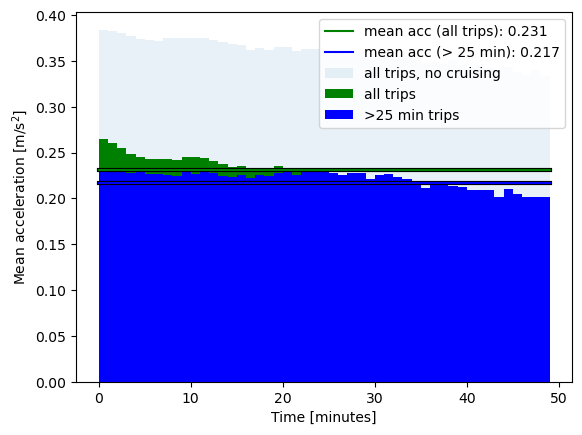

In [292]:
plt.bar([x +0.5 for x in bin_labels[0:-1]], GM_acc.loc[(GM_acc["total_time"] >= 0) & (GM_acc["acc_smooth"] > 0.1) & (GM_acc["vel_smooth"] <= 10)].groupby("section")["acc_smooth"].apply(lambda x: x.mean()).tolist()[0:-1], label="all trips, no cruising", width=1, alpha=0.1)
plt.bar([x +0.5 for x in bin_labels[0:-1]], GM_acc.groupby("section")["acc_smooth"].apply(lambda x: x.mean()).tolist()[0:-1], label="all trips", width=1, alpha = 1, color="green")
plt.bar([x +0.5 for x in bin_labels[0:-1]], GM_acc.loc[GM_acc["total_time"] >= 25].groupby("section")["acc_smooth"].apply(lambda x: x.mean()).tolist()[0:-1], label=">25 min trips", width=1, alpha=1, color="blue")
plt.plot([x for x in bin_labels], [GM_acc["acc_smooth"].mean() for x in bin_labels], color="black", linewidth="3")
plt.plot([x for x in bin_labels], [GM_acc["acc_smooth"].mean() for x in bin_labels], label= "mean acc (all trips): " +str(round(GM_acc["acc_smooth"].mean(),3)), color="green")
plt.plot([x for x in bin_labels], [GM_acc.loc[GM_acc["total_time"] >= 25]["acc_smooth"].mean() for x in bin_labels], color="black", linewidth=3)
plt.plot([x for x in bin_labels], [GM_acc.loc[GM_acc["total_time"] >= 25]["acc_smooth"].mean() for x in bin_labels], label= "mean acc (> 25 min): " +str(round(GM_acc.loc[GM_acc["total_time"] >= 25]["acc_smooth"].mean(),3)), color="blue")


plt.xlabel("Time [minutes]")
plt.ylabel("Mean acceleration [m/s$^2$]")
plt.legend()
plt.show()



In [185]:
#DONT RUN THIS; IT IS FOR INDIVIDUAL TRIPS AND TAKES FOREVER


trip_ids = GM_span.trip_id.unique().tolist() #get trip indexes
#GM_span["mean_vel"] = np.nan #create new empty column
                                                                 
comp = []

for trip_id in trip_ids:
    trip_comp = []
    overall_mean = GM_span.loc[(GM_span["trip_id"] == trip_id) & (GM_span["section"] <= bin_labels[-2])]["acc_smooth"].mean()
    trip_comp.append(overall_mean)  
    for section in bin_labels[0:-1]:
        section_mean = GM_span.loc[(GM_span["trip_id"] == trip_id) & (GM_span["section"]==section)]["acc_smooth"].mean()
        if str(section_mean) != "nan":
            trip_comp.append(section_mean)
        else:
            trip_comp.append(overall_mean)
            print(trip_id)
        #GM_span.loc[(GM_span["trip_id"] == trip_id) & (GM_span["section"]==section) , "mean_vel"] = GM_span.loc[(GM_span["trip_id"] == trip_id) & (GM_span["section"]==section)]["vel_smooth"].mean()
    comp.append(trip_comp)
    

per_comp = []
for trip_comp in comp:
    per_trip = []
    mean_trip = trip_comp[0]
    for elem in trip_comp[1::]:
        per_trip.append(elem/mean_trip)
        #per_trip.append(trip_comp[i] - mean_trip)
    per_comp.append(per_trip)

    
to_plot = []
for i in range(len(per_comp[0])):
    s = 0
    for per in per_comp:
        s+=per[i]
    to_plot.append(s)

k= sum(to_plot)
for i in range(len(per_comp[0])):
    to_plot[i] = to_plot[i]/k
    
print(to_plot)

[0.20392388687002452, 0.19934128193295167, 0.19767154088822736, 0.19736238795614694, 0.20170090235264948]


In [317]:
GM["time_sum"] = GM["count"]*1.51/60

In [318]:
#Here we simply set the bin-sizes for which section of the trip a row belongs to
#(In the first five minutes,.. etc.)
variable = "time_sum"  
grouped_variable_name = "section"

#set the edges of the bins
bin_edges = [x for x in range(50)] + [np.inf]
bin_edges[0] = -1
bin_labels = [x for x in range(50)]


# This part does the grouping based on the input above
GM[grouped_variable_name] = pd.cut(
    GM[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

#We have now created an additional column which denotes which of the above bins each row belongs to
#i.e., if row i takes place during the first 10 minues of a trip, then row[i]["section"] = 10

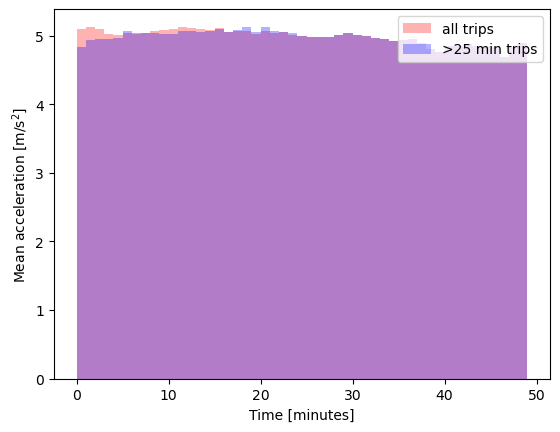

In [320]:
plt.bar([x +0.5 for x in bin_labels[0:-1]], GM.loc[(GM["count"] >= 0) & (GM["total_time"] >= 0)].groupby("section")["vel_smooth"].apply(lambda x: x.mean()).tolist()[0:-1], label="all trips", width=1, alpha=0.3, color="red")

#plt.bar([x +0.5 for x in bin_labels[0:-1]], GM.loc[(GM["count"] >= 0)].groupby("section")["vel_smooth"].apply(lambda x: x.mean()).tolist()[0:-1], label="all trips", width=1, alpha = 1, color="green")

plt.bar([x +0.5 for x in bin_labels[0:-1]], GM.loc[(GM["count"] >= 0) & (GM["total_time"] >= 25)].groupby("section")["vel_smooth"].apply(lambda x: x.mean()).tolist()[0:-1], label=">25 min trips", width=1, alpha=0.3, color="blue")


#plt.plot([x for x in bin_labels], [GM_acc["acc_smooth"].mean() for x in bin_labels], color="black", linewidth="3")
#plt.plot([x for x in bin_labels], [GM_acc["acc_smooth"].mean() for x in bin_labels], label= "mean acc (all trips): " +str(round(GM_acc["acc_smooth"].mean(),3)), color="green")
#plt.plot([x for x in bin_labels], [GM_acc.loc[GM_acc["total_time"] >= 25]["acc_smooth"].mean() for x in bin_labels], color="black", linewidth=3)
#plt.plot([x for x in bin_labels], [GM_acc.loc[GM_acc["total_time"] >= 25]["acc_smooth"].mean() for x in bin_labels], label= "mean acc (> 25 min): " +str(round(GM_acc.loc[GM_acc["total_time"] >= 25]["acc_smooth"].mean(),3)), color="blue")


plt.xlabel("Time [minutes]")
plt.ylabel("Mean velocity [m/s$^2$]")
plt.legend()
plt.show()

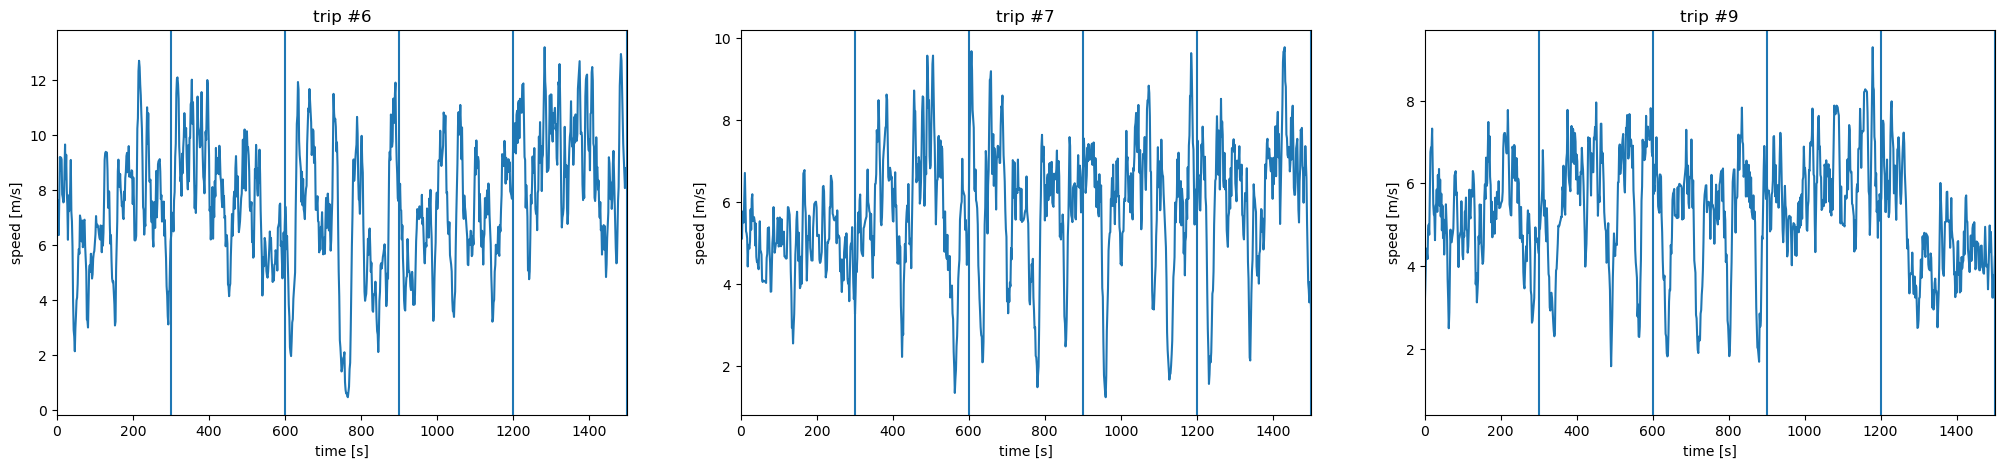

In [290]:
N = 3

#trip_ids = GM.trip_id.unique().tolist()
trips = [6,7,9]#[random.randint(0,len(trip_ids)) for x in range(N)]


#GM_span["time_sum"] = GM_span["count"]*1.51
fig = plt.figure(figsize=(25, 5*round(N/3)))

for i in range(N):
    trip = trips[i]
    times = [1.51*x for x in GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["count"].tolist()]
    vels = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["vel_smooth"]
    
    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("time [s]")
    plt.ylabel("speed [m/s]")
    plt.plot(times, vels, "-")
    for j in range(1,6):
        plt.axvline(x=j*5*60)
    #plt.plot([1,2,3], [1,2,3], "-")
    plt.xlim([0, 1500])
    plt.title("trip #"+str(trip))

plt.show()

In [300]:
GM.loc[(GM["trip_id"] == 6) & (GM["count"]>= 0)].head(3)# & (GM["count"] <= 15*60/1.5)  & (GM["count"] >= 10*60/1.5)].head(3)

geo  trip_id     length  \
2520  LINESTRING (-73.60618 45.53214, -73.60612 45.5...        6   6.515112   
2521  LINESTRING (-73.60612 45.53212, -73.60603 45.5...        6  12.588130   
2522  LINESTRING (-73.60603 45.53206, -73.60592 45.5...        6  13.520590   

      time    vel_og  Z_val_20       vel  vel_smooth  count  total_time  \
2520  1.51  4.314644 -0.984356  4.314644    6.749801    0.0   29.495333   
2521  1.51  8.336510  0.104078  8.336510    7.631306    1.0   29.495333   
2522  1.51  8.954033  0.271198  8.954033    7.393468    2.0   29.495333   

           acc  acc_smooth  vel_smooth_test  acc_smooth_test  
2520  2.663488    0.583778         5.630813         0.895926  
2521  0.408956   -0.157509         6.983661         0.652441  
2522 -2.220602   -0.685805         7.968847        -0.784080

In [305]:
GM_span.loc[(GM_span["trip_id"]==15) & (GM_span["section"] == 15)].head(10)

geo  trip_id    length  \
12206  LINESTRING (-73.59452 45.54560, -73.59452 45.5...       15  0.111195   

       time    vel_og  Z_val_20       vel  vel_smooth  count  total_time  \
12206  1.51  0.073639       0.0  0.073639     0.13784    8.0   41.952833   

            acc  acc_smooth  vel_smooth_test  acc_smooth_test  time_sum  \
12206  0.089168    0.005778         0.108336         0.033095     12.08   

      section  
12206      15

In [308]:
GM.head(3)

geo  trip_id     length  \
0  LINESTRING (-73.57748 45.50690, -73.57751 45.5...        0   4.164946   
1  LINESTRING (-73.57751 45.50692, -73.57757 45.5...        0  12.379816   
2  LINESTRING (-73.57757 45.50701, -73.57774 45.5...        0  19.563040   

   time     vel_og  Z_val_20        vel  vel_smooth  count  total_time  acc  \
0  1.51   2.758243 -0.986791   2.758243    0.551649   -1.0       9.966  NaN   
1  1.51   8.198554  0.092033   8.198554    2.191359   -1.0       9.966  NaN   
2  1.51  12.955656  1.035374  12.955656    4.782490   -1.0       9.966  NaN   

   acc_smooth  vel_smooth_test  acc_smooth_test  acc_og  
0         NaN         2.758243              NaN     NaN  
1         NaN         6.385117              NaN     NaN  
2         NaN        10.139710              NaN     NaN

In [313]:
GM.loc[(GM["count"]>= 0) & (GM["acc_smooth"]>0)]["acc_smooth"].mean()

0.23076310003194353

In [314]:
GM.loc[(GM["count"]>= 0) & (GM["acc"]>0)]["acc"].mean()

0.918752298127664

In [315]:
GM.loc[(GM["count"]>= 0) & (GM["acc_smooth_test"]>0)]["acc_smooth_test"].mean()

0.4370928145733857

geo  trip_id  \
5        LINESTRING (-73.57810 45.50729, -73.57827 45.5...        0   
6        LINESTRING (-73.57827 45.50740, -73.57836 45.5...        0   
7        LINESTRING (-73.57836 45.50745, -73.57843 45.5...        0   
8        LINESTRING (-73.57843 45.50748, -73.57847 45.5...        0   
9        LINESTRING (-73.57847 45.50752, -73.57845 45.5...        0   
...                                                    ...      ...   
4327023  LINESTRING (-73.54460 45.54177, -73.54463 45.5...     4880   
4327024  LINESTRING (-73.54463 45.54171, -73.54466 45.5...     4880   
4327025  LINESTRING (-73.54466 45.54166, -73.54468 45.5...     4880   
4327026  LINESTRING (-73.54468 45.54161, -73.54472 45.5...     4880   
4327027  LINESTRING (-73.54472 45.54157, -73.54475 45.5...     4880   

            length  time     vel_og  Z_val_20        vel  vel_smooth  count  \
5        22.361518  1.51  14.808952  1.402886  14.808952   13.545133    0.0   
6        11.144483  1.51   7.380453 -0.070198   7.380453   13.381513    1.0   
7         8.753379  1.51   5.796940 -0.384212   5.796940   11.949770    2.0   
8         6.223937  1.51   4.121812 -0.716392   4.121812    9.416160    3.0   
9         8.418565  1.51   5.575209 -0.428181   5.575209    7.536673    4.0   
...            ...   ...        ...       ...        ...         ...    ...   
4327023   6.876100  1.51   4.553709 -0.818228   4.553709    4.599923   44.0   
4327024   7.240115  1.51   4.794778 -0.669065   4.794778    4.715514   45.0   
4327025   5.673063  1.51   3.756995 -1.311200   3.756995    4.563075   46.0   
4327026   5.816702  1.51   3.852121 -1.252341   3.852121    4.332490   47.0   
4327027   7.518036  1.51   4.978832 -0.555181   4.978832    4.387287   48.0   

         total_time       acc  acc_smooth  vel_smooth_test  acc_smooth_test  \
5             9.966 -4.919536   -0.108358        13.545133        -2.403817   
6             9.966 -1.048684   -0.948174        13.381513        -1.714167   
7             9.966 -1.109356   -1.677887        11.949770        -1.407815   
8             9.966  0.962514   -1.244694         9.416160        -0.220116   
9             9.966  1.520466   -0.918919         7.536673         0.650708   
...             ...       ...         ...              ...              ...   
4327023       1.208  0.159648    0.076550         4.599923         0.033981   
4327024       1.208 -0.687273   -0.100953         4.715514        -0.326646   
4327025       1.208  0.062997   -0.152705         4.563075        -0.131825   
4327026       1.208  0.746166    0.036289         4.332490         0.307171   
4327027       1.208  0.371495    0.130607         4.387287         0.339333   

           acc_og  time_sum section  
5       -4.919536  0.000000       0  
6       -1.048684  0.025167       0  
7       -1.109356  0.050333       0  
8        0.962514  0.075500       0  
9        1.520466  0.100667       0  
...           ...       ...     ...  
4327023  0.159648  1.107333       1  
4327024 -0.687273  1.132500       1  
4327025  0.062997  1.157667       1  
4327026  0.746166  1.182833       1  
4327027  0.371495  1.208000       1  

[4277404 rows x 17 columns]

# AFTER OPT

In [498]:
import pickle

# Okay
The idea is to compare the results to some other stuff. The things to compare is
* OPT physics
* OPT constant
* OPT data

* Random
* best of five random trips



How to do this? 
* Should we use OG data or smoothed? Should we smooth after the fact? It feels wrong to not use OG data since we are using an acceleration function based on OG data. 
* Should we cut all histograms off over 10 m/s? Because otherwise they are hard to compare to each other. But then how to we compare that to the random trips we choose? Actually, this is not a problem for the 5 random trips choosen. But keep in mind.

## Plan
First issue, the trips have a timestep op 1.51 seconds. We would like to change this so that it is 2 seconds. OR we just scale the histograms so that

# this is the histogram we are working with!!!

OG data 

In [1329]:
H_scaled = [4.512743388441156, 4.273652521789638, 4.076151085825884, 4.050617109775722, 3.776513745661481, 3.751560087248823, 3.8283554546118106, 4.079439552438405, 4.4003552059779425, 4.422213836990581, 4.6798748680422175, 4.7874270701929005, 4.483534067353471, 4.657822797817078, 4.727654353530021, 4.802902207192999, 4.942371879406385, 5.279923305221028, 5.383219844696684, 5.770872026549146, 6.177287812014226, 6.458935305416015, 6.8469743656934785, 7.375450294246835, 7.64394392119854, 8.330266247152897, 8.749062142218058, 9.519143647185448, 10.012607078276082, 10.561394124142065, 11.172081718008444, 11.865174416400345, 12.09285236951429, 12.838173655281523, 13.359685772184836, 13.770163781112442, 14.083922183789435, 14.604273665417738, 15.27705524649701, 15.54477511659871, 15.851569707625659, 15.914050573263555, 15.973242972288931, 16.013478328489185, 16.06783474720203, 15.7792234421502, 15.812688425912912, 15.61866889577418, 15.558702739898798, 15.046282265983045, 14.85980686513186, 14.618975045567831, 13.858372062013002, 13.710777942874564, 13.332023964797159, 12.778400938618644, 12.2990585700406, 11.783349629512326, 11.448893231097701, 10.731040313505643, 10.260015831065152, 9.876425872675217, 9.318547183821673, 8.845201430831167, 8.550593510191797, 8.010124350463364, 7.583590886898157, 7.294786142633822, 6.818925679880801, 6.469574462103583, 6.128734569676418, 5.814202410149421, 5.542226877372694, 5.231176623670718, 4.926703303193785, 4.695156565829815, 4.529379160716262, 4.274619717852144, 4.242895687001942, 3.923527547162415, 3.7165475897861002, 3.6716696924858154, 3.510341389259791, 3.390602516721531, 3.1905863709952604, 3.174917794782661, 2.982058899918936]
vel = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6]

# Random

In [1129]:
random_route = []
vel_list = [round(x) for x in H_scaled]

for i in range(len(vel_list)):
    v_curr = vel[i]
    for j in range(vel_list[i]):
        random_route.append(v_curr)
random.shuffle(random_route)

rand_df = pd.DataFrame(random_route, columns=['vel'])
rand_df["time"] = [2*x for x in range(len(random_route))]
rand_df["vel_smooth"] = rand_df["vel"].rolling(5).mean()

v_use = ["vel", "vel_smooth"]
acc_name = ["acc", "acc_smooth"]
for i in range(2):
    rand_df[acc_name[i]] = -rand_df[v_use[i]].diff(periods=-1)
    rand_df[acc_name[i]] = rand_df.loc[:, (acc_name[i])]/2

rand_df.dropna(inplace = True)

variable = "vel_smooth"  
grouped_variable_name = "vel_smooth_bin"

rand_df[grouped_variable_name] = pd.cut(
    rand_df[variable],
    bins= vel + [np.inf],
    labels= [x for x in range(len(vel))],
    right=False) 

In [1134]:
rand_df.head(2)

vel  time  vel_smooth   acc  acc_smooth vel_smooth_bin
4  0.7     8        4.02  2.85        0.16             40
5  6.4    10        4.34 -1.80       -0.21             43

<BarContainer object of 87 artists>

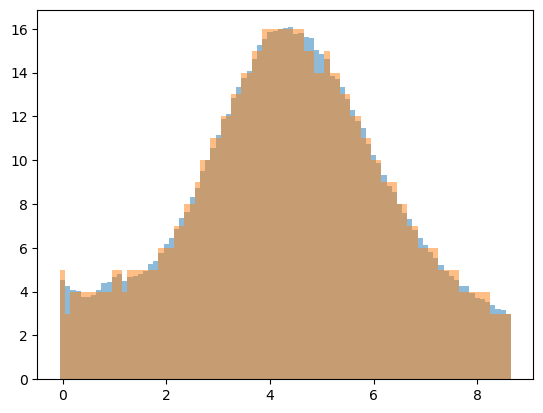

In [1457]:
plt.bar(vel, H_scaled,alpha=0.5,label="OG data", width=0.1)
plt.bar(vel, rand_df.groupby("vel")["vel"].count().tolist(), label="random", alpha=0.5, width=0.1)
#plt.bar(vel, rand_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist(), label="smooth", alpha=0.5, width=0.1)

# random trips

In [1095]:
trip_ids = GM.loc[GM["total_time"] >= 25].trip_id.unique().tolist()

In [1319]:
N_trip = 3
trips = [1011, 91, 915, 1390, 1192] #random

trips_df_list = []
for i in range(N_trip):
    trip = trips[i]
    trips_df = pd.DataFrame(GM.loc[(GM["trip_id"] == trip_ids[trip]) & (GM["count"]>=0) & (GM["time_sum"]<=25)]["time_sum"].tolist(), columns=['time_sum'])
    cols = ["vel", "acc", "vel_smooth", "acc_smooth", "vel_bin", "vel_OG_bin"]

    for col in cols:
        trips_df[col] = GM.loc[(GM["trip_id"] == trip_ids[trip]) & (GM["count"]>=0) & (GM["time_sum"]<=25)][col].tolist()

    trips_df.rename(columns={'vel_bin': 'vel_smooth_bin'}, inplace=True)
    trips_df.rename(columns={'vel_OG_bin': 'vel_bin'}, inplace=True)
    trips_df_list.append(trips_df)

In [1320]:
trips_df_list[0].head(3)

time_sum       vel       acc  vel_smooth  acc_smooth  vel_smooth_bin  \
0  0.000000  3.618448  0.091599    2.982183    0.252267              30   
1  0.025167  3.756762  2.153695    3.363106    0.549318              34   
2  0.050333  7.008841 -2.242281    4.192577    0.056646              42   

   vel_bin  
0       37  
1       38  
2       71

## Compare the three trips here

we need to scale the histogram so that it matches sum(H_trips) instead of 750

In [1321]:
c = 994/750
H_trips = [x*c for x in H_scaled]

In [1466]:
tr = 2
trips_df = trips_df_list[tr]

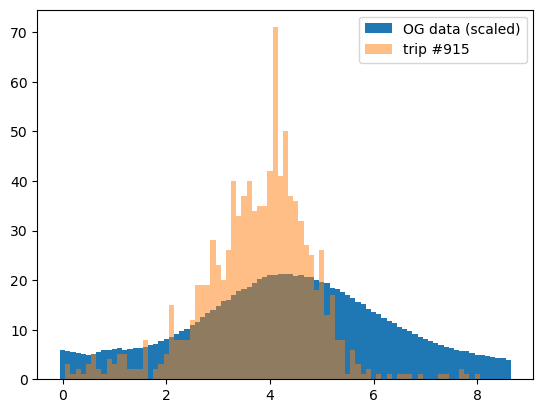

In [1470]:
plt.bar([x for x in vel], H_trips,alpha=1,label="OG data (scaled)", width=0.1)
#trips_df.groupby("vel_bin")["vel_bin"].count().hist(label="OG", width=1)
#trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().hist(label="smooth")
plt.bar([x/10 for x in trips_df.groupby("vel_bin")["vel_bin"].count().index.tolist()], [x for x in trips_df.groupby("vel_bin")["vel_bin"].count().tolist()], label="trip #"+str(trips[tr]), width=0.1, alpha = 0.5)
#plt.bar([x/10 for x in trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().index.tolist()], [x for x in trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist()], label="smooth", width=0.1, alpha=0.5)

plt.legend()
plt.show()
#plt.bar([x/10 for x in range(max(trips_df["vel_bin"].tolist()) + 1)], trips_df.groupby("vel_bin")["vel"].count().tolist(), label="random", alpha=0.5, width=0.1)
#plt.bar(vel, trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist(), label="smooth", alpha=0.5, width=0.1)

We can combine their velocities into one histogram (and scale it to 750)

In [1503]:
comb_H = [0 for x in range(100)]

for trips_df in trips_df_list:
    h = trips_df.groupby("vel_bin")["vel_bin"].count().reindex([x for x in range(100)], fill_value=0)
    for i in range(100):
        comb_H[i] += h[i]/N_trip

c = 750/sum(comb_H)
comb_H = [x*c for x in comb_H]
print("scaled:", round(sum(comb_H)), round(sum(H_scaled)))

scaled: 750 750


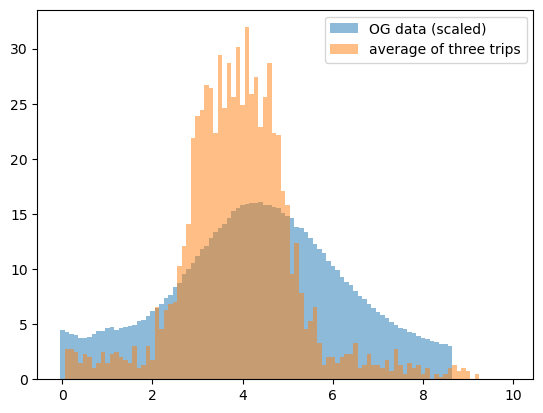

In [1471]:
plt.bar(vel, H_scaled,alpha=0.5,label="OG data (scaled)", width=0.1)
plt.bar([x/10 for x in range(100)], comb_H, label="average of three trips", alpha=0.5, width=0.1)
plt.legend()
plt.show()

# optimized trip

In [1516]:
#runs = ["phys_wStops", "phys_noStops", "phys_wStops_OG", "const_cut_87_OG"]
runs = ["OPT_physics", "OPT_constant", "OPT_data"]
#runs = ["phys_wStops_OG", "const_cut_87_OG", "dist_cut_87_OG"]
#runs = ["OPT_physics", "phys_wStops_OG"]
opt_df_list = []

for name in runs:
    with open(name+".pickle", 'rb') as handle: #open
        x_val_dic = pickle.load(handle)

    x_val = x_val_dic[0][1::] #the first elem in list is opt-val - not a velocity
    opt_df = pd.DataFrame(x_val, columns=['vel'])
    opt_df["time"] = [2*x for x in range(len(x_val))]


    opt_df["vel_smooth"] = opt_df["vel"].rolling(5).mean()

    v_use = ["vel", "vel_smooth"]
    acc_name = ["acc", "acc_smooth"]
    for i in range(2):
        opt_df[acc_name[i]] = -opt_df[v_use[i]].diff(periods=-1)
        opt_df[acc_name[i]] = opt_df.loc[:, (acc_name[i])]/2

    opt_df.dropna(inplace = True)

    variable = "vel_smooth"  
    grouped_variable_name = "vel_smooth_bin"

    opt_df[grouped_variable_name] = pd.cut(
        opt_df[variable],
        bins= vel + [np.inf],
        labels= [x for x in range(len(vel))],
        right=False) 
    opt_df_list.append(opt_df)

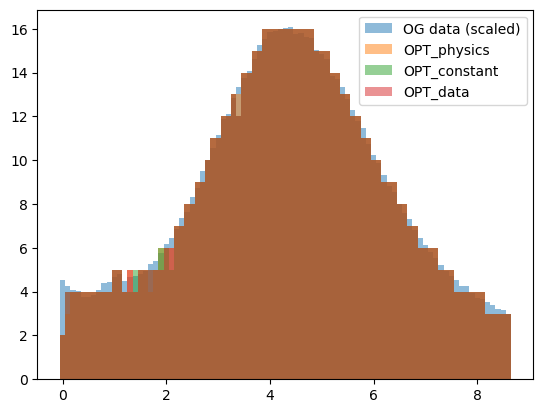

In [1517]:
plt.bar(vel, H_scaled,alpha=0.5,label="OG data (scaled)", width=0.1)
for i in range(len(runs)):
    opt_df = opt_df_list[i]
    lab = runs[i]
    plt.bar(vel, opt_df.groupby("vel")["vel"].count().tolist(), label=lab,alpha=0.5,width=0.1)
plt.legend()
plt.show()


# Compare

# Not smoothed

In [1519]:
print("mean velocity:")
print("OG data:", round(GM.loc[GM["vel"]<=8.6]["vel"].mean(),2))
for i in range(len(runs)):
    print(runs[i], round(opt_df_list[i]["vel"].mean(),2))
print("random:", round(rand_df["vel"].mean(),2))
print("three trips:", round((trips_df_list[0]["vel"].mean() + trips_df_list[1]["vel"].mean() + trips_df_list[2]["vel"].mean())/3,2))


mean velocity:
OG data: 4.37
OPT_physics 4.37
OPT_constant 4.37
OPT_data 4.37
random: 4.35
three trips: 3.86


In [1521]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]
acc_time = []
dec_time = []
cruise_time = []

for frame in list_name:
    if len(frame) > N_trip:
        frame_len = len(frame)
        acc_time.append(len(frame.loc[(frame["acc"] > 0.100001)])/frame_len)
        dec_time.append((len(frame.loc[frame["acc"] < -0.100001]))/frame_len)
    else:
        acc_sub = 0
        dec_sub = 0
        for sub_frame in frame:
                    frame_len = len(sub_frame)
                    acc_sub += len(sub_frame.loc[(sub_frame["acc"] > 0.100001)])/frame_len
                    dec_sub +=(len(sub_frame.loc[sub_frame["acc"] < -0.100001]))/frame_len
        acc_time.append(acc_sub/N_trip)
        dec_time.append(dec_sub/N_trip)
            

In [1522]:
print("time spent accelerating:")
for i in range(len(list_name)):
    print(names[i], round(acc_time[i]*100,2), "%")

        
print("\ntime spent decelerating:")
for i in range(len(list_name)):
    print(names[i], round(dec_time[i]*100,2), "%")

print("\ntime spent cruising:")
for i in range(len(list_name)):
    print(names[i], round((1-acc_time[i]-dec_time[i])*100,2), "%")

time spent accelerating:
OPT_physics 46.31 %
OPT_constant 53.83 %
OPT_data 50.2 %
OG 41.93 %
RANDOM 46.73 %
three trips 31.79 %

time spent decelerating:
OPT_physics 30.47 %
OPT_constant 33.29 %
OPT_data 36.91 %
OG 36.24 %
RANDOM 46.06 %
three trips 31.12 %

time spent cruising:
OPT_physics 23.22 %
OPT_constant 12.89 %
OPT_data 12.89 %
OG 21.83 %
RANDOM 7.21 %
three trips 37.09 %


## number of stops
Since I've all but dropped "smoothed" data, the number of stops should now instead be defined from the OG data. So the number of stops *should* be 31.. (we could also check whether the smoothed OPT is close to 9 stops?)

In [1511]:
#state 0 means we are in a "stop-period"
#state 1 means we are in a "drive-period"

max_vel = 2#limit for what is considered "stop"
velocities = opt_df_list[0]["vel"].tolist()
stops = []    #list to save all stop-periods

state = 1     #we start in a drive-period (I know this because I know the data, might have to change if other data is used)
one_stop = [] #list to save all velocities for one stop-period




for i in range(1, len(velocities)): 
    v = velocities[i]                  #current vel
    
    if state == 0 and v < max_vel:    #we are in a stop-period and we stay there
        one_stop.append(v)             #keep adding "stop-period"-velocities, 
        #state = 0                     #stay in state
        
    elif state == 0 and v >= max_vel:   #we are leaving a stop-period
        one_stop.append(v)         #add vel *just after* stop-period
        stops.append(one_stop)     #save this stop
        state = 1                  #change state
            
    elif state == 1 and v < max_vel:   #we are entering a stop-period
        one_stop = [velocities[i-1], v]#add vel *just before* stop-period AND first vel *in* stop-period
        state = 0
    else: #state = 1 v > 1
        state = 1
print(len(stops))

31


##  stops
* All OPTs has (predictably) 31 stops
* random has 82
* trip 1: 13, trip 2: 16, trip 3: 18

# anything else to compare?

* speed vs acceleration?

In [1512]:
opt_df

vel  time  vel_smooth   acc  acc_smooth vel_smooth_bin
4    2.7     8        1.94  0.40        0.35             19
5    3.5    10        2.64  0.45        0.29             26
6    4.4    12        3.22  0.40        0.30             32
7    5.2    14        3.82  0.15        0.22             38
8    5.5    16        4.26 -1.75       -0.07             42
..   ...   ...         ...   ...         ...            ...
744  3.6  1488        3.48  0.40        0.01             34
745  4.4  1490        3.50 -0.25        0.06             35
746  3.9  1492        3.62 -0.15        0.07             36
747  3.6  1494        3.76  0.20        0.07             37
748  4.0  1496        3.90 -2.00       -0.36             39

[745 rows x 6 columns]

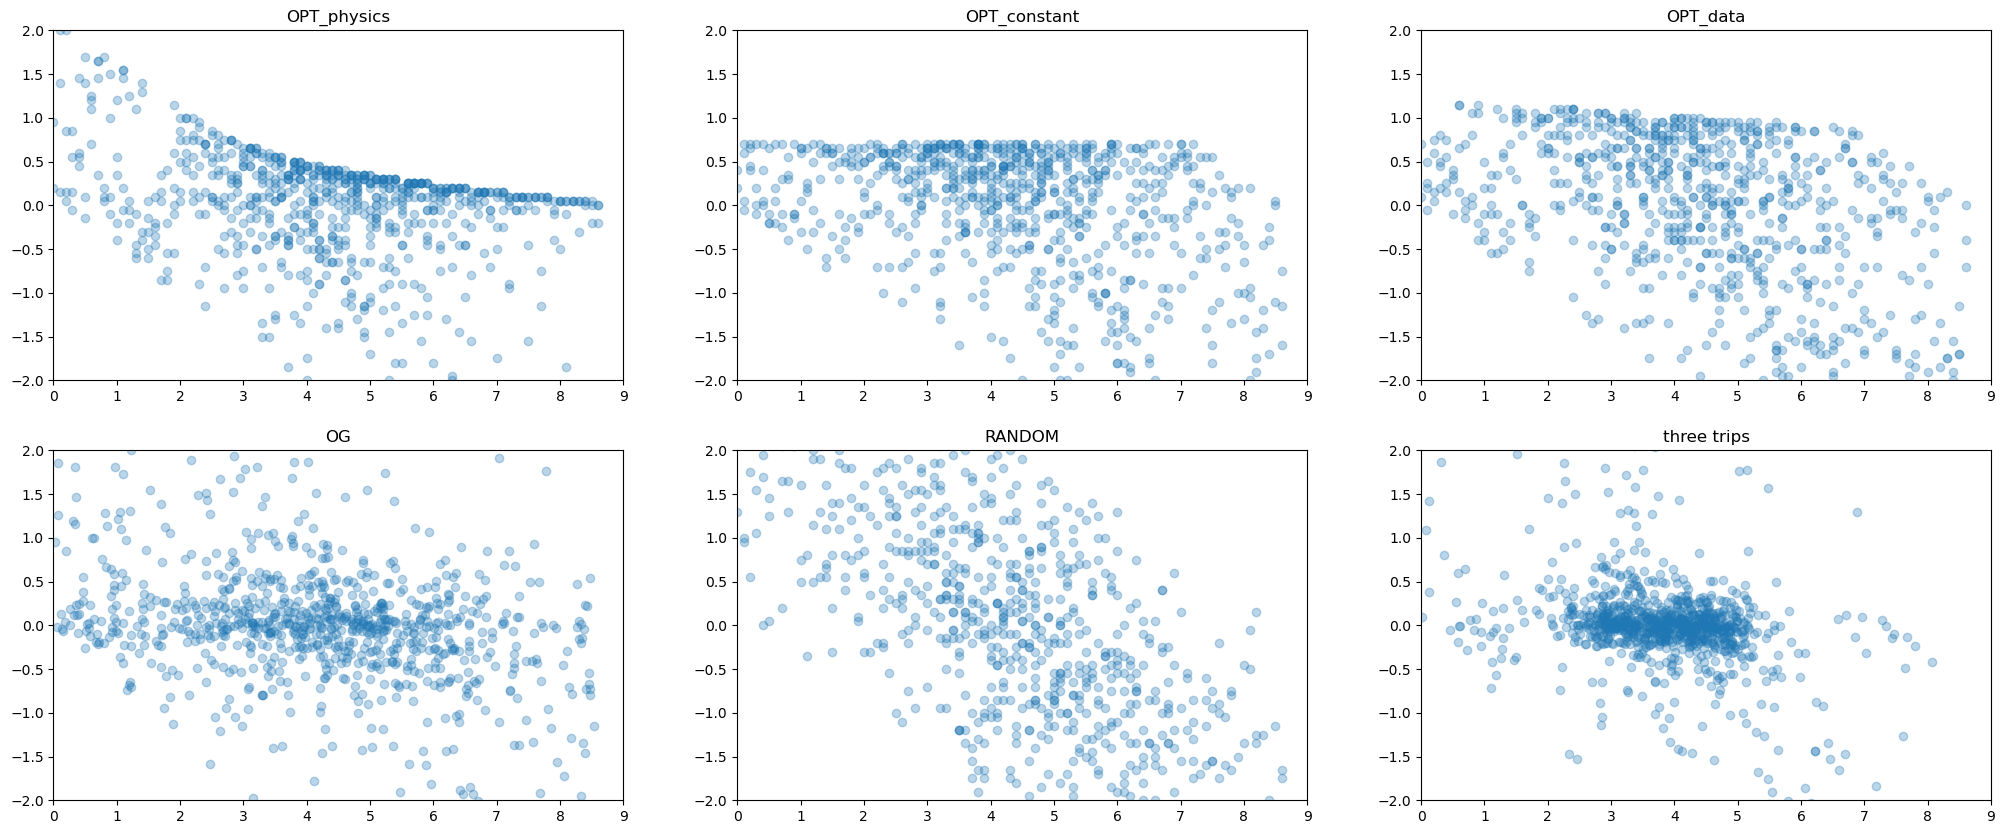

In [1536]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]
size = 1000
fig = plt.figure(figsize=(25, 5*round(2)))


for i in range(len(list_name)):
    frame = list_name[i]
    if len(frame) > N_trip:
        if len(frame) > size:
            frame = frame.sample(n=size)
        plt.subplot(2,3,i+1)
        plt.scatter(
           x=frame['vel'], 
           y=frame['acc'], alpha=0.3)
        plt.title(names[i])
        plt.ylim([-2,2])
        plt.xlim([0,9])
    else:
        for sub_frame in frame:
            sub_frame = sub_frame.sample(n=333)
            plt.subplot(2,3,i+1)
            plt.scatter(
                x=sub_frame["vel"],
                y=sub_frame["acc"], alpha=0.3, color='tab:blue')
            plt.title(names[i])
            plt.ylim([-2,2])
            plt.xlim([0,9])

plt.show()

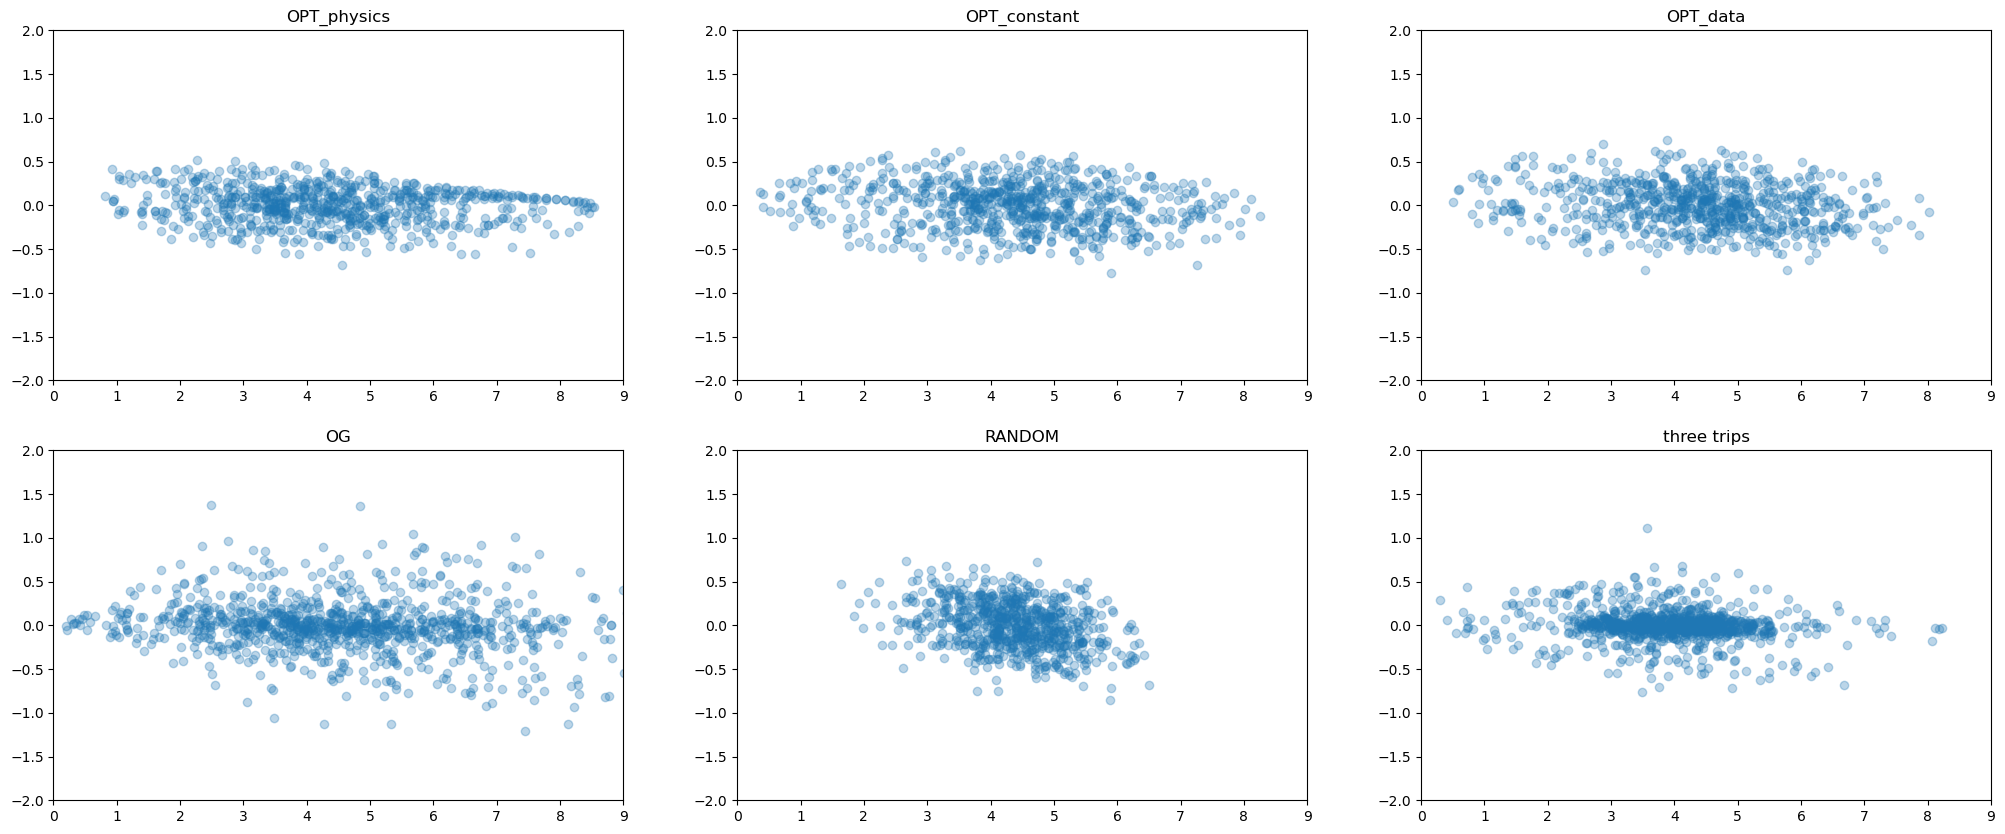

In [1535]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]
size = 1000
fig = plt.figure(figsize=(25, 5*round(2)))


for i in range(len(list_name)):
    frame = list_name[i]
    if len(frame) > N_trip:
        if len(frame) > size:
            frame = frame.sample(n=size)
        plt.subplot(2,3,i+1)
        plt.scatter(
           x=frame['vel_smooth'], 
           y=frame['acc_smooth'], alpha=0.3)
        plt.title(names[i])
        plt.ylim([-2,2])
        plt.xlim([0,9])
    else:
        for sub_frame in frame:
            sub_frame = sub_frame.sample(n=333)
            plt.subplot(2,3,i+1)
            plt.scatter(
                x=sub_frame["vel_smooth"],
                y=sub_frame["acc_smooth"], alpha=0.3, color='tab:blue')
            plt.title(names[i])
            plt.ylim([-2,2])
            plt.xlim([0,9])


plt.show()

# SMOOTH (not now)

In [1326]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]




In [1546]:
compare_H = H_scaled + [0 for x in range(len(comb_H)-len(H_scaled))]
comb_H = comb_H
opt_H = opt_df_list[2].groupby("vel_smooth_bin")["vel_smooth_bin"].count().reindex([x for x in range(100)], fill_value=0).tolist()
rand_H = rand_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().reindex([x for x in range(100)], fill_value=0).tolist()
comb_abs = 0
opt_abs = 0
rand_abs = 0
for i in range(len(comb_H)):
    x = compare_H[i]
    comb_abs += abs(x-comb_H[i])
    opt_abs += abs(x-opt_H[i])
    rand_abs += abs(x-rand_H[i])
print(comb_abs)
print(opt_abs)
print(rand_abs)

In [1549]:
print("mean velocity:")
print("OG data:", round(GM.loc[GM["vel_smooth"]<=8.6]["vel_smooth"].mean(),2))
for i in range(len(runs)):
    print(runs[i], round(opt_df_list[i]["vel_smooth"].mean(),2))
print("random:", round(rand_df["vel_smooth"].mean(),2))
print("three trips:", round((trips_df_list[0]["vel_smooth"].mean() + trips_df_list[1]["vel_smooth"].mean() + trips_df_list[2]["vel_smooth"].mean())/3,2))


mean velocity:
OG data: 4.64
OPT_physics 4.37
OPT_constant 4.37
OPT_data 4.37
random: 4.36
three trips: 3.86


In [1552]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]
acc_time = []
dec_time = []
cruise_time = []

for frame in list_name:
    if len(frame) > N_trip:
        frame_len = len(frame)
        acc_time.append(len(frame.loc[(frame["acc_smooth"] > 0.100001)])/frame_len)
        dec_time.append((len(frame.loc[frame["acc_smooth"] < -0.100001]))/frame_len)
    else:
        acc_sub = 0
        dec_sub = 0
        for sub_frame in frame:
                    frame_len = len(sub_frame)
                    acc_sub += len(sub_frame.loc[(sub_frame["acc_smooth"] > 0.100001)])/frame_len
                    dec_sub +=(len(sub_frame.loc[sub_frame["acc_smooth"] < -0.100001]))/frame_len
        acc_time.append(acc_sub/N_trip)
        dec_time.append(dec_sub/N_trip)

In [1553]:
print("time spent accelerating:")
for i in range(len(list_name)):
    print(names[i], round(acc_time[i]*100,2), "%")

        
print("\ntime spent decelerating:")
for i in range(len(list_name)):
    print(names[i], round(dec_time[i]*100,2), "%")

print("\ntime spent cruising:")
for i in range(len(list_name)):
    print(names[i], round((1-acc_time[i]-dec_time[i])*100,2), "%")

time spent accelerating:
OPT_physics 31.41 %
OPT_constant 36.38 %
OPT_data 33.42 %
OG 27.6 %
RANDOM 34.98 %
three trips 18.48 %

time spent decelerating:
OPT_physics 29.26 %
OPT_constant 35.03 %
OPT_data 34.36 %
OG 28.27 %
RANDOM 36.18 %
three trips 18.21 %

time spent cruising:
OPT_physics 39.33 %
OPT_constant 28.59 %
OPT_data 32.21 %
OG 44.12 %
RANDOM 28.84 %
three trips 63.31 %


In [ ]:
plt.bar([x for x in vel], H_trips,alpha=1,label="OG data", width=0.1)
#trips_df.groupby("vel_bin")["vel_bin"].count().hist(label="OG", width=1)
#trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().hist(label="smooth")
plt.bar([x/10 for x in trips_df.groupby("vel_bin")["vel_bin"].count().index.tolist()], [x for x in trips_df.groupby("vel_bin")["vel_bin"].count().tolist()], label="OG", width=0.1, alpha = 0.5)
plt.bar([x/10 for x in trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().index.tolist()], [x for x in trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist()], label="smooth", width=0.1, alpha=0.5)

plt.legend()
plt.show()
#plt.bar([x/10 for x in range(max(trips_df["vel_bin"].tolist()) + 1)], trips_df.groupby("vel_bin")["vel"].count().tolist(), label="random", alpha=0.5, width=0.1)
#plt.bar(vel, trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist(), label="smooth", alpha=0.5, width=0.1)

In [ ]:
plt.bar([x for x in vel], H_scaled,alpha=1,label="OG data", width=0.1)
plt.bar([x/10 for x in range(100)], comb_H,alpha=0.5,label="all three smooth", width=0.1)
plt.bar(vel, opt_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist(), label="opt",alpha=0.5,width=0.1)

plt.legend()
plt.show()

# print histogram for optimization

In [500]:
#Here we simply set the bin-sizes for the average speed
variable = "vel_smooth"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM[grouped_variable_name] = pd.cut(
    GM[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [508]:
print(GM.loc[GM["count"] >= 0].groupby("vel_bin").agg("count")["vel_smooth"].tolist())

[2149, 6224, 9633, 12088, 13415, 14307, 15337, 16386, 17707, 19375, 21132, 21745, 22161, 22247, 22408, 23176, 24059, 25243, 26197, 27766, 28993, 30777, 32613, 34957, 36928, 39642, 42006, 44817, 47718, 51213, 54232, 57785, 59514, 62659, 65328, 68640, 70717, 73579, 75932, 77241, 80358, 81265, 82114, 83863, 83796, 84531, 85071, 85456, 85464, 85222, 84738, 82974, 81362, 80259, 78360, 76227, 74562, 72387, 69313, 66875, 64236, 62247, 59279, 56424, 54279, 52163, 49665, 46739, 44796, 43031, 40726, 38623, 36444, 35107, 32939, 31423, 29808, 28078, 26760, 25337, 23835, 22442, 21219, 20133, 19173, 18229, 17391, 16308, 15103, 14669, 13822, 12932, 12056, 11450, 10843, 10043, 9477, 8830, 8288, 7954, 7327, 6944, 6433, 5955, 5753, 5249, 4876, 4530, 4292, 3964, 3632, 3424, 3205, 2925, 2699, 2415, 2218, 2058, 1904, 1911, 1694, 1579, 1397, 1237, 1113, 1073, 1006, 921, 860, 799, 736, 662, 620, 569, 527, 516, 416, 383, 367, 320, 292, 294, 266, 199, 202, 175, 163, 142, 142, 122, 108, 105, 94, 82, 99, 94, 82,

OG data

In [977]:
#Here we simply set the bin-sizes for the average speed
variable = "vel"  
grouped_variable_name = "vel_OG_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM[grouped_variable_name] = pd.cut(
    GM[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [978]:
print(GM.loc[GM["count"] >= 0].groupby("vel_OG_bin").agg("count")["vel"].tolist())

[23329, 22093, 21072, 20940, 19523, 19394, 19791, 21089, 22748, 22861, 24193, 24749, 23178, 24079, 24440, 24829, 25550, 27295, 27829, 29833, 31934, 33390, 35396, 38128, 39516, 43064, 45229, 49210, 51761, 54598, 57755, 61338, 62515, 66368, 69064, 71186, 72808, 75498, 78976, 80360, 81946, 82269, 82575, 82783, 83064, 81572, 81745, 80742, 80432, 77783, 76819, 75574, 71642, 70879, 68921, 66059, 63581, 60915, 59186, 55475, 53040, 51057, 48173, 45726, 44203, 41409, 39204, 37711, 35251, 33445, 31683, 30057, 28651, 27043, 25469, 24272, 23415, 22098, 21934, 20283, 19213, 18981, 18147, 17528, 16494, 16413, 15416, 14443, 14583, 13872, 13642, 12876, 12715, 12046, 11315, 11560, 11098, 10765, 10631, 10317, 9907, 9715, 9631, 9218, 8668, 8573, 8587, 8261, 8003, 7927, 7415, 7206, 6962, 6597, 6219, 6345, 5881, 5935, 5300, 5307, 5242, 4754, 4645, 4357, 4117, 3980, 3849, 3643, 3423, 3259, 2992, 2903, 2714, 2544, 2449, 2336, 2161, 2007, 1851, 1846, 1714, 1636, 1517, 1418, 1242, 1182, 1122, 1005, 992, 905, 8

# PP plots

In [2]:
import matplotlib.colors as colors
from mycolorpy import colorlist as mcp

In [16]:
color1=mcp.gen_color(cmap="viridis",n=4)

In [17]:
color2=mcp.gen_color(cmap="viridis",n=5)

In [54]:
blue = mcp.gen_color(cmap="PuBu",n=10)[8]

In [55]:
blue

'#045687'

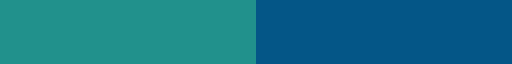

In [56]:
colors.ListedColormap([color2[2]]+[blue])

In [57]:
order_list = [3,0,2,5,1,6,4]

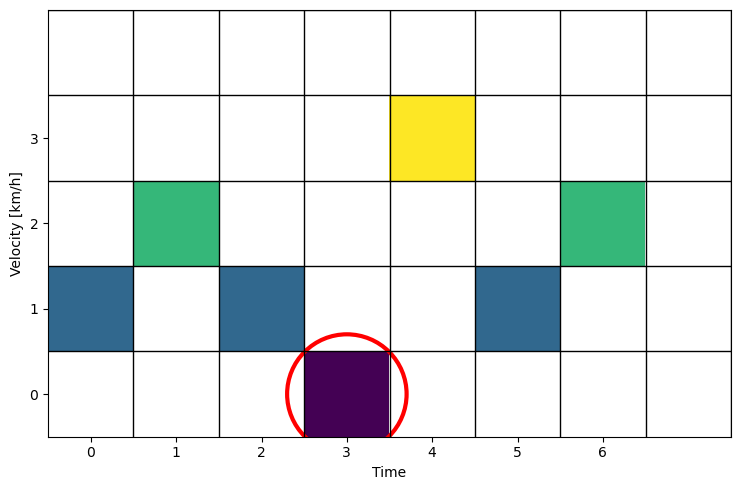

In [130]:
N = 8 #x-ax
M = 5 #y-ax
# make an empty data set
data = np.ones((M, N)) * np.nan
# fill in some fake data
data2 = np.ones((M,N))*np.nan
data3 = np.ones((M,N))*np.nan

def trip_1(order_list):
    data[0][order_list[0]] = 0 #[y][x]
    data[1][order_list[1]] = 1 #[y][x]
    data[1][order_list[2]] = 1 #[y][x]
    data[1][order_list[3]] = 1 #[y][x]
    data[2][order_list[4]] = 2 #[y][x]
    data[2][order_list[5]] = 2 #[y][x]
    data[3][order_list[6]] = 3 #[y][x]
    sss = 3

    
def const_bin(data2,data3):
    data2[2][1] = 4
    data3[2][1] = 4
    
def const1(data):
    for i in range(M):
        data[i][1] = 4
        
def const2(data):
    for i in range(N):
        data[2][i] = 4

def start(data):
    data[0][0] = 4
    data[0][7] = 4

def acc(data):
    data[0][2] = 4
    data[1][2] = 4
    data[2][2] = 4
    data[3][2] = 4


    
#order_list = [0,1,2,3,4,5,6]
#random.shuffle(order_list)

#a = const_bin(data2,data3)
#a = const1(data3)
#a = const2(data3)
#a = start(data3)
#a = acc(data3)

trip_1(order_list)




# make a figure + axes
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10,5))
# make color map
my_cmap = colors.ListedColormap(mcp.gen_color(cmap="viridis",n=4)[0:4])
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)


my_cmap2 = colors.ListedColormap([color2[2]])#colors.ListedColormap(mcp.gen_color(cmap="hsv",n=1))
my_cmap3 = colors.ListedColormap(["red"])#colors.ListedColormap(mcp.gen_color(cmap="hsv",n=1))
# set the 'bad' values (nan) to be white and transparent
my_cmap2.set_bad(color='w', alpha=0)
# draw the grid
for x in range(N + 1):
    ax.axhline(x+0.5, lw=1, color='k', zorder=5)
    ax.axvline(x+0.5, lw=1, color='k', zorder=5)
# draw the boxes

plt.xticks(np.arange(0, N-1, dtype=np.int64))
plt.yticks(np.arange(0, M-1, dtype=np.int64))
plt.xlabel("Time")
plt.ylabel("Velocity [km/h]")

#Drawing_colored_circle = plt.Circle(( 1 , 2 ), 0.4, color=color1[2] )
#ax.add_artist( Drawing_colored_circle)

Drawing_uncolored_circle = plt.Circle( (3, 0 ),
                                      0.7 , color="red",
                                      fill = False ,linewidth=3)
 
ax.add_artist( Drawing_uncolored_circle )


#Drawing_colored_circle = plt.Circle(( 6 , 2 ), 0.4, color=color1[2] )
#ax.add_artist( Drawing_colored_circle)

#Drawing_uncolored_circle = plt.Circle( (6, 2 ),
#                                      0.4 , color=blue,
#                                      fill = False ,linewidth=3)
# 
#ax.add_artist( Drawing_uncolored_circle )

#ax.imshow(data3, interpolation='none', cmap=my_cmap3, zorder=0, origin='lower', alpha = 1);
ax.imshow(data, interpolation='none', cmap=my_cmap, zorder=0, origin='lower', alpha=1);
ax.imshow(data2, interpolation='none', cmap=my_cmap2, zorder=0, origin='lower', alpha = 1);
#ax.imshow(data, interpolation='none', cmap=my_cmap, zorder=0, origin='lower', alpha=1);
ax.imshow(data3, interpolation='none', cmap=my_cmap3, zorder=0, origin='lower', alpha = 1);
ax.imshow(data, interpolation='none', cmap=my_cmap, zorder=0, origin='lower', alpha=0.4);


# turn off the axis labels
#ax.axis('off')2046135 3025164

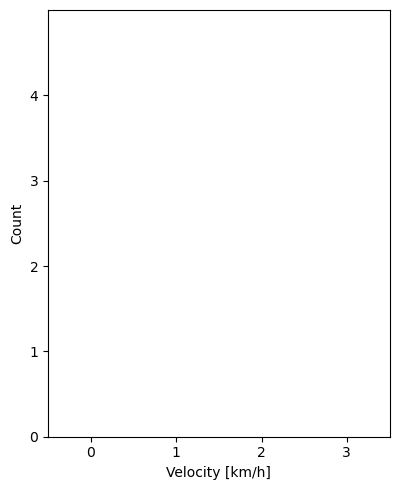

In [817]:
N = 4 #x-ax
M = 5 #y-ax
# make an empty data set
data = np.ones((M, N)) * np.nan
# fill in some fake data


# make a figure + axes
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(5,5))
# make color map
my_cmap = colors.ListedColormap(mcp.gen_color(cmap="viridis",n=4)[3:4])
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)
# draw the grid
#for x in range(N + 1):
#    ax.axhline(x+0.5, lw=1, color='k', zorder=5)
#    ax.axvline(x+0.5, lw=1, color='k', zorder=5)
# draw the boxes

plt.xticks(np.arange(0, N, dtype=np.int64))
plt.yticks(np.arange(0, M, dtype=np.int64))


def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-0.5, y), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect


#data[0][0]=0
#highlight_cell(0,0, color="black", linewidth=1)

#data[0][1]=1
#highlight_cell(1,0, color="black", linewidth=1)

#data[1][1]=1
#highlight_cell(1,1, color="black", linewidth=1)

#data[2][1]=1
#highlight_cell(1,2, color="black", linewidth=1)

#data[0][2]=2
#highlight_cell(2,0, color="black", linewidth=1)

#data[1][2]=2
#highlight_cell(2,1, color="black", linewidth=1)

#data[0][3]=3
#highlight_cell(3,0, color="black", linewidth=1)

ax.imshow(data, interpolation='none', cmap=my_cmap,extent=[-0.5,N-0.5,0,M], zorder=0, origin='lower')
plt.xlabel("Velocity [km/h]")
plt.ylabel("Count")

plt.show()
# turn off the axis labels
#ax.axis('off')

AttributeError: 'list' object has no attribute 'imshow'

In [676]:
order_list = [0,1,2,3,4,5,6]



None


In [700]:
#Here we simply set the bin-sizes for the average speed
variable = "vel_smooth"  
grouped_variable_name = "plt_vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(1))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM[grouped_variable_name] = pd.cut(
    GM[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

H_tilf = GM.loc[GM["count"] >= 0].groupby("plt_vel_bin").agg("count")["vel_smooth"].tolist()

In [25]:
#H_tilf = [2149, 6224, 9633, 12088, 13415, 14307, 15337, 16386, 17707, 19375, 21132, 21745, 22161, 22247, 22408, 23176, 24059, 25243, 26197, 27766, 28993, 30777, 32613, 34957, 36928, 39642, 42006, 44817, 47718, 51213, 54232, 57785, 59514, 62659, 65328, 68640, 70717, 73579, 75932, 77241, 80358, 81265, 82114, 83863, 83796, 84531, 85071, 85456, 85464, 85222, 84738, 82974, 81362, 80259, 78360, 76227, 74562, 72387, 69313, 66875, 64236, 62247, 59279, 56424, 54279, 52163, 49665, 46739, 44796, 43031, 40726, 38623, 36444, 35107, 32939, 31423, 29808, 28078, 26760, 25337, 23835, 22442, 21219, 20133, 19173, 18229, 17391, 16308, 15103, 14669, 13822, 12932, 12056, 11450, 10843, 10043, 9477, 8830, 8288, 7954, 7327, 6944, 6433, 5955, 5753, 5249, 4876, 4530, 4292, 3964, 3632, 3424, 3205, 2925, 2699, 2415, 2218, 2058, 1904, 1911, 1694, 1579, 1397, 1237, 1113, 1073, 1006, 921, 860, 799, 736, 662, 620, 569, 527, 516, 416, 383, 367, 320, 292, 294, 266, 199, 202, 175, 163, 142, 142, 122, 108, 105, 94, 82, 99, 94, 82, 62, 52, 57, 36, 50, 37, 29, 27, 33, 28, 22, 28, 19, 24, 28, 14, 24, 20, 16, 22, 16, 16, 20, 14, 34, 24, 22, 19, 23, 38, 33, 30, 40, 45, 59, 73, 68, 74, 55, 140, 131, 85, 3]
H_scaled = [round(x/sum(H_tilf)*25) for x in H_tilf][0:10]



NameError: name 'H_tilf' is not defined

In [727]:
print(H_scaled)

[1, 1, 2, 4, 5, 4, 3, 2, 1, 1]


In [27]:
H_scaled=[1, 1, 2, 4, 5, 4, 3, 2, 1, 1]

In [28]:
color1=mcp.gen_color(cmap="viridis",n=len(H_scaled))
print(color1)

['#440154', '#482878', '#3e4989', '#31688e', '#26828e', '#1f9e89', '#35b779', '#6ece58', '#b5de2b', '#fde725']


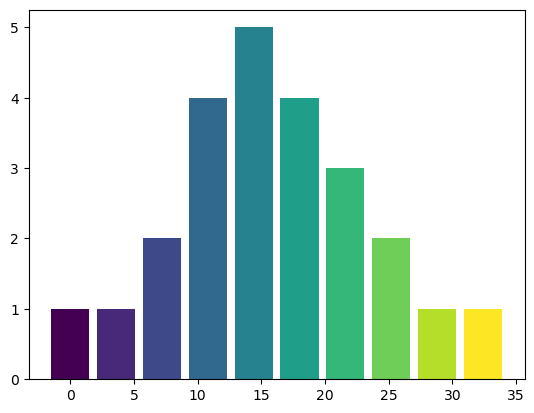

In [32]:
H_scaled=[1, 1, 2, 4, 5, 4, 3, 2, 1, 1]
vel_km = [round(x/1*60*60/1000,2) for x in range(len(H_scaled))]
plt.bar(vel_km,H_scaled, color=color1, width=3)
plt.show()

In [51]:
order_list = [x for x in range(25)]
random.shuffle(order_list)

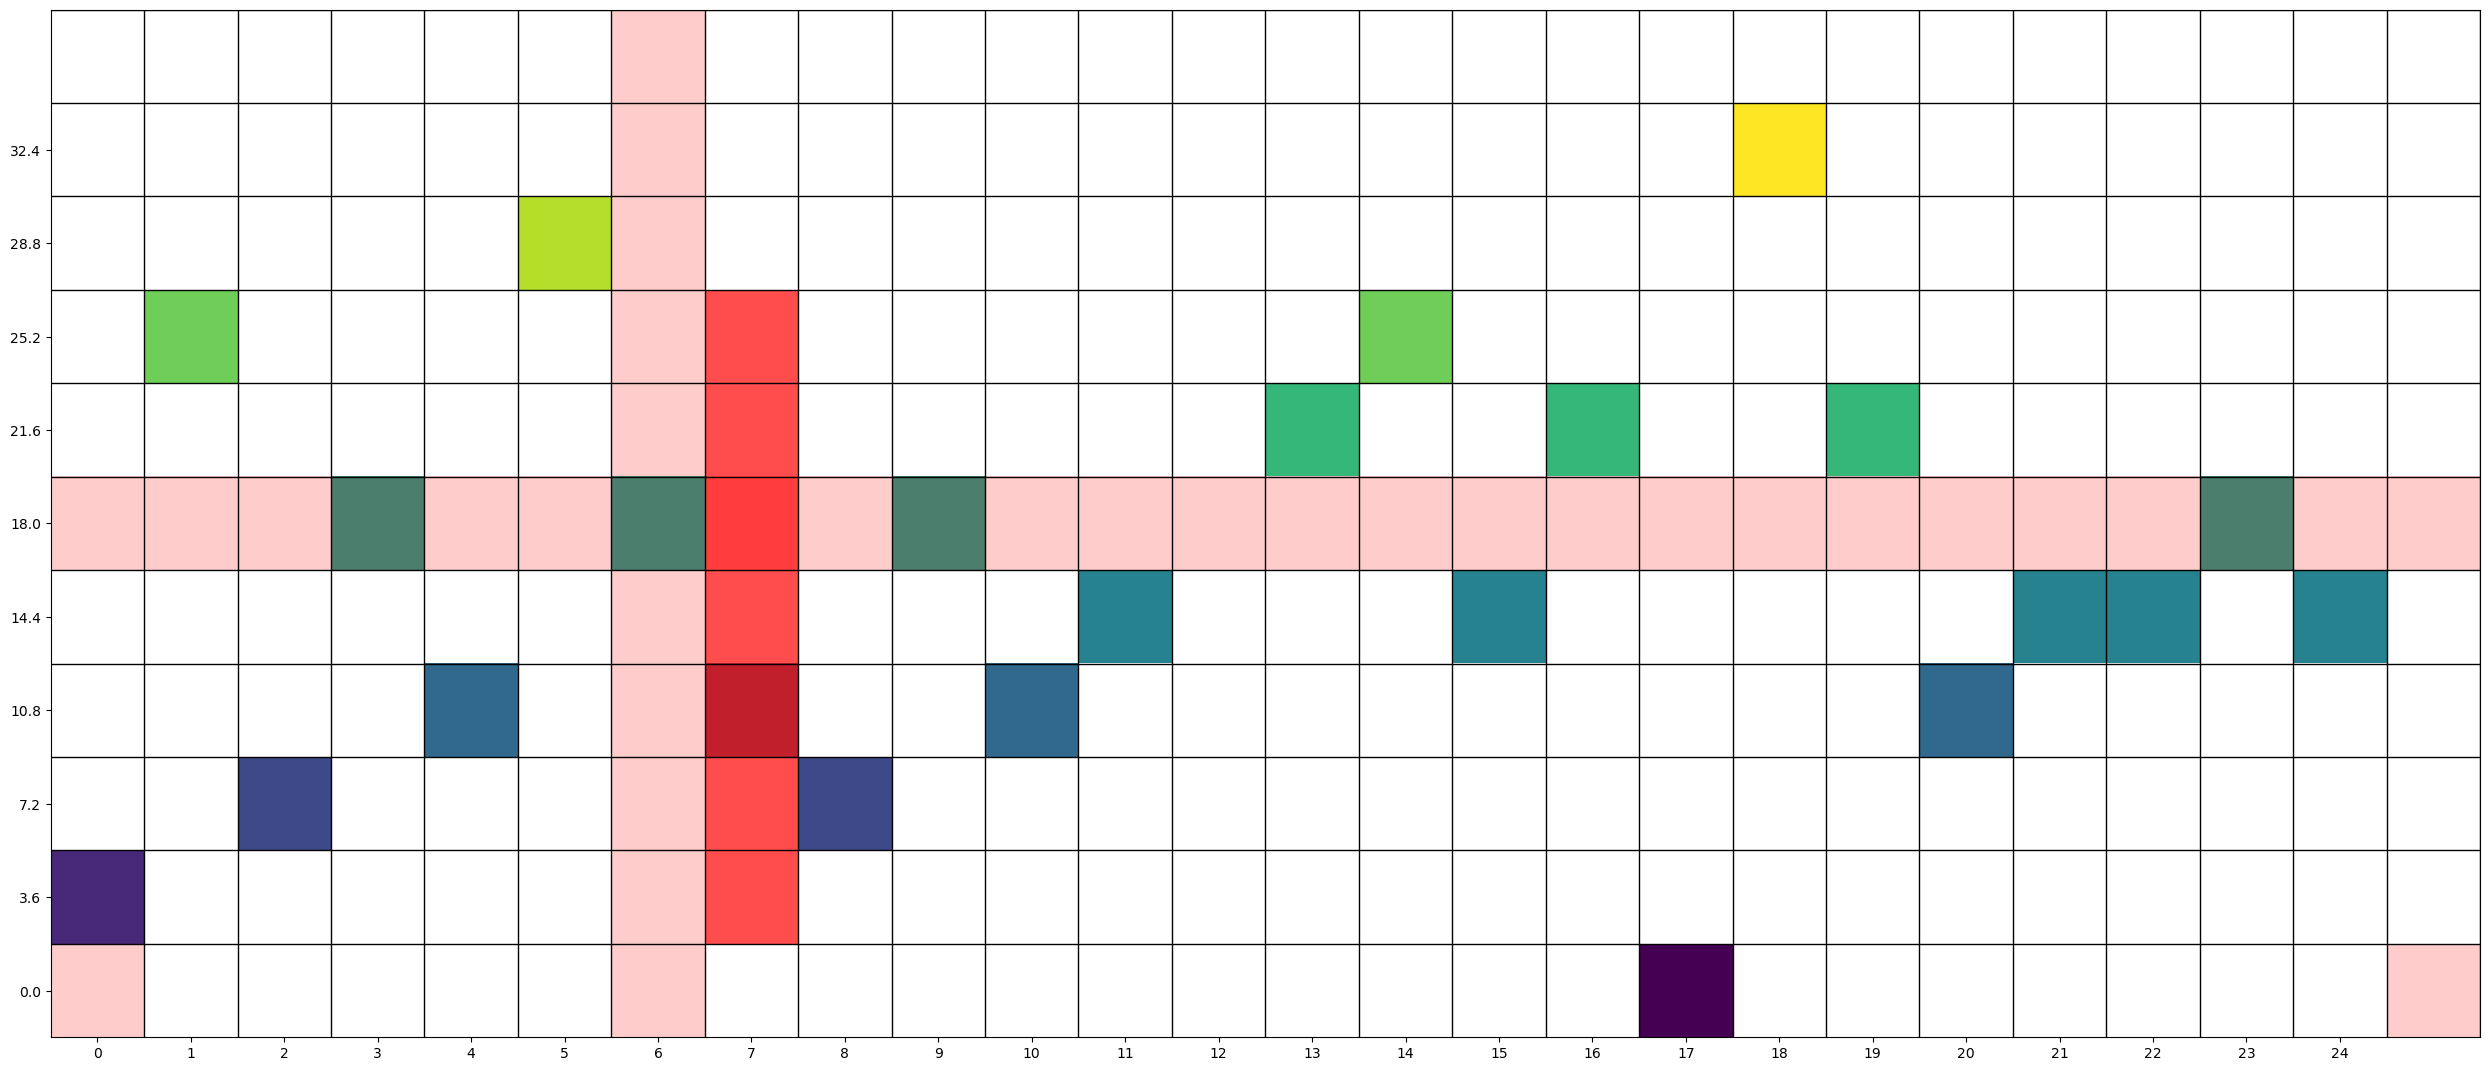

In [88]:
N = 26 #x-ax
M = 11 #y-ax
# make an empty data set
data = np.ones((M, N)) * np.nan
# fill in some fake data
data3 = np.ones((M, N)) * np.nan
data2 = np.ones((M,N))*np.nan


def trip_1(order_list):
    idx = 0
    for h in range(len(H_scaled)):
        for i in range(H_scaled[h]):
            data[h][order_list[idx]] = h
            idx += 1       

def const_bin(data):
    data[5][6] = 4
    
def const1(data):
    for i in range(M):
        data[i][6] = 4
        
def const2(data):
    for i in range(N):
        data[5][i] = 4

def start(data):
    data[0][0] = 4
    data[0][25] = 4

def acc(data):
    data[5][7] = 4
    data[4][7] = 4
    data[6][7] = 4
    data[7][7] = 4
    data[3][7] = 4
    data[2][7] = 4
    data[1][7] = 4

    
#order_list = [0,1,2,3,4,5,6]
#random.shuffle(order_list)

a = const_bin(data3)
a = const1(data3)
a = const2(data3)
a = start(data3)
a = acc(data2)



trip_1(order_list)


#order_list = [x for x in range(25)]
#random.shuffle(order_list)

#trip_1(order_list)

# make a figure + axes
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(25,25))
# make color map
my_cmap = colors.ListedColormap(color1)
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)
# draw the grid


my_cmap2 = colors.ListedColormap(mcp.gen_color(cmap="autumn",n=1))
# set the 'bad' values (nan) to be white and transparent
my_cmap2.set_bad(color='w', alpha=0)
# draw the grid

for x in range(N + 1):
    ax.axhline(x+0.5, lw=1, color='k', zorder=5)
    ax.axvline(x+0.5, lw=1, color='k', zorder=5)
# draw the boxes

plt.xticks(np.arange(0, N-1, dtype=np.int64))
plt.yticks(np.arange(0, M-1, dtype=np.int64))
ax.set_yticklabels(vel_km)

ax.imshow(data, interpolation='none', cmap=my_cmap, zorder=0, origin='lower');
ax.imshow(data2, interpolation='none', cmap=my_cmap2, zorder=0, origin='lower', alpha = 0.7);
ax.imshow(data3, interpolation='none', cmap=my_cmap2, zorder=0, origin='lower', alpha = 0.2);
# turn off the axis labels
#ax.axis('off')




In [76]:
data3 = np.ones((M, N)) * np.nan

In [79]:
order_list

[17,
 0,
 8,
 2,
 7,
 4,
 20,
 10,
 22,
 11,
 24,
 21,
 15,
 3,
 9,
 6,
 23,
 13,
 19,
 16,
 1,
 14,
 5,
 18,
 12]

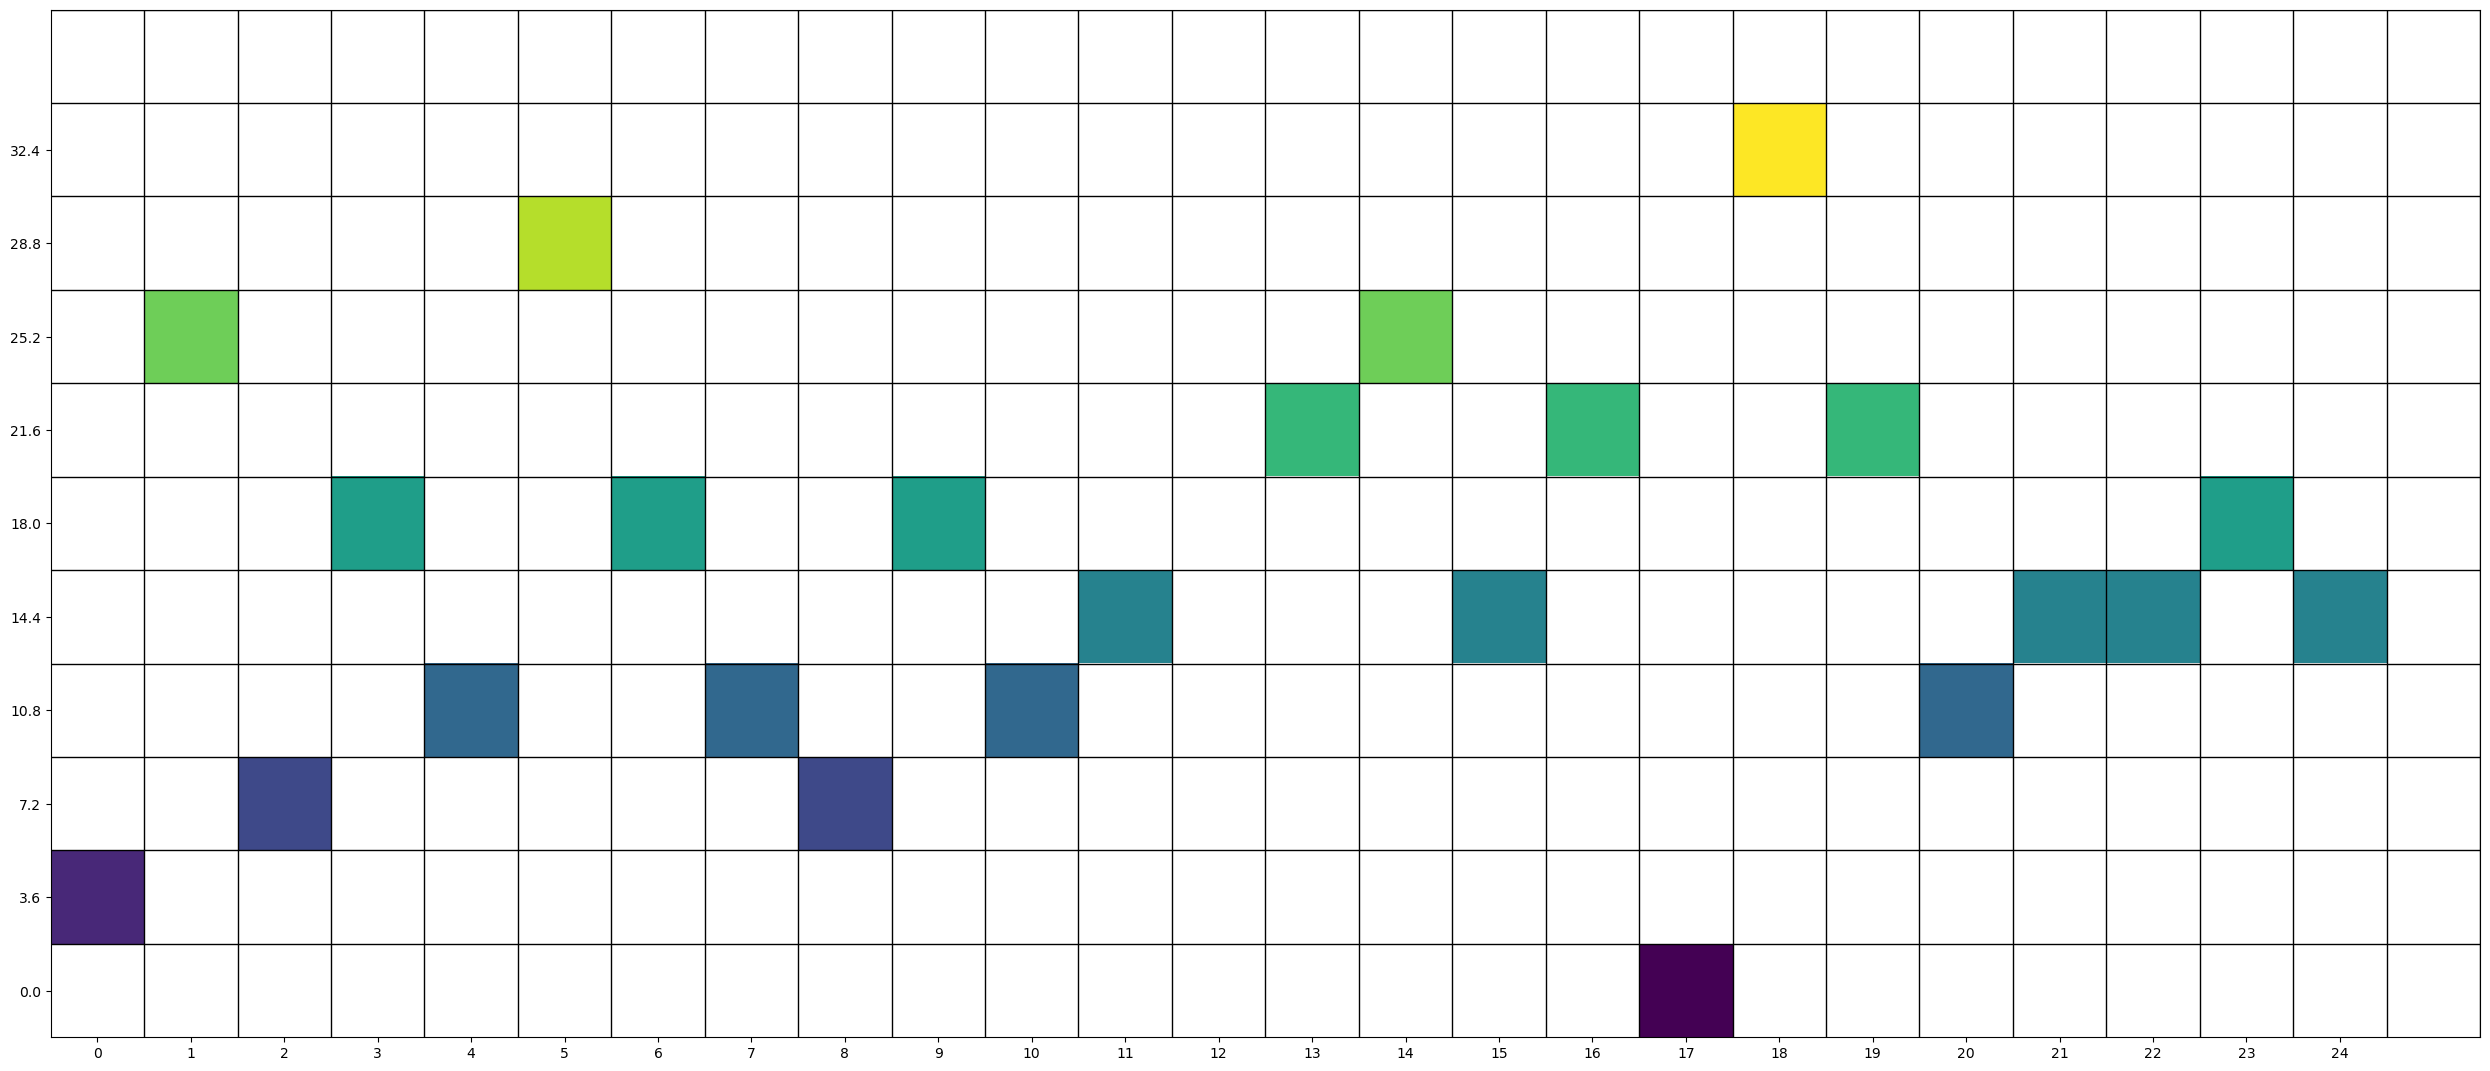

In [73]:
N = 26 #x-ax
M = 11 #y-ax
# make an empty data set
data = np.ones((M, N)) * np.nan
# fill in some fake data

data2 = np.ones((M,N))*np.nan

def trip_1(order_list):
    idx = 0
    for h in range(len(H_scaled)):
        for i in range(H_scaled[h]):
            data[h][order_list[idx]] = h
            idx += 1


#order_list = [x for x in range(25)]
#random.shuffle(order_list)

trip_1(order_list)

# make a figure + axes
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(25,25))
# make color map
my_cmap = colors.ListedColormap(color1)
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)
# draw the grid
for x in range(N + 1):
    ax.axhline(x+0.5, lw=1, color='k', zorder=5)
    ax.axvline(x+0.5, lw=1, color='k', zorder=5)
# draw the boxes

plt.xticks(np.arange(0, N-1, dtype=np.int64))
plt.yticks(np.arange(0, M-1, dtype=np.int64))
ax.set_yticklabels(vel_km)

ax.imshow(data, interpolation='none', cmap=my_cmap, zorder=0, origin='lower')
plt.show()
# turn off the axis labels
#ax.axis('off')

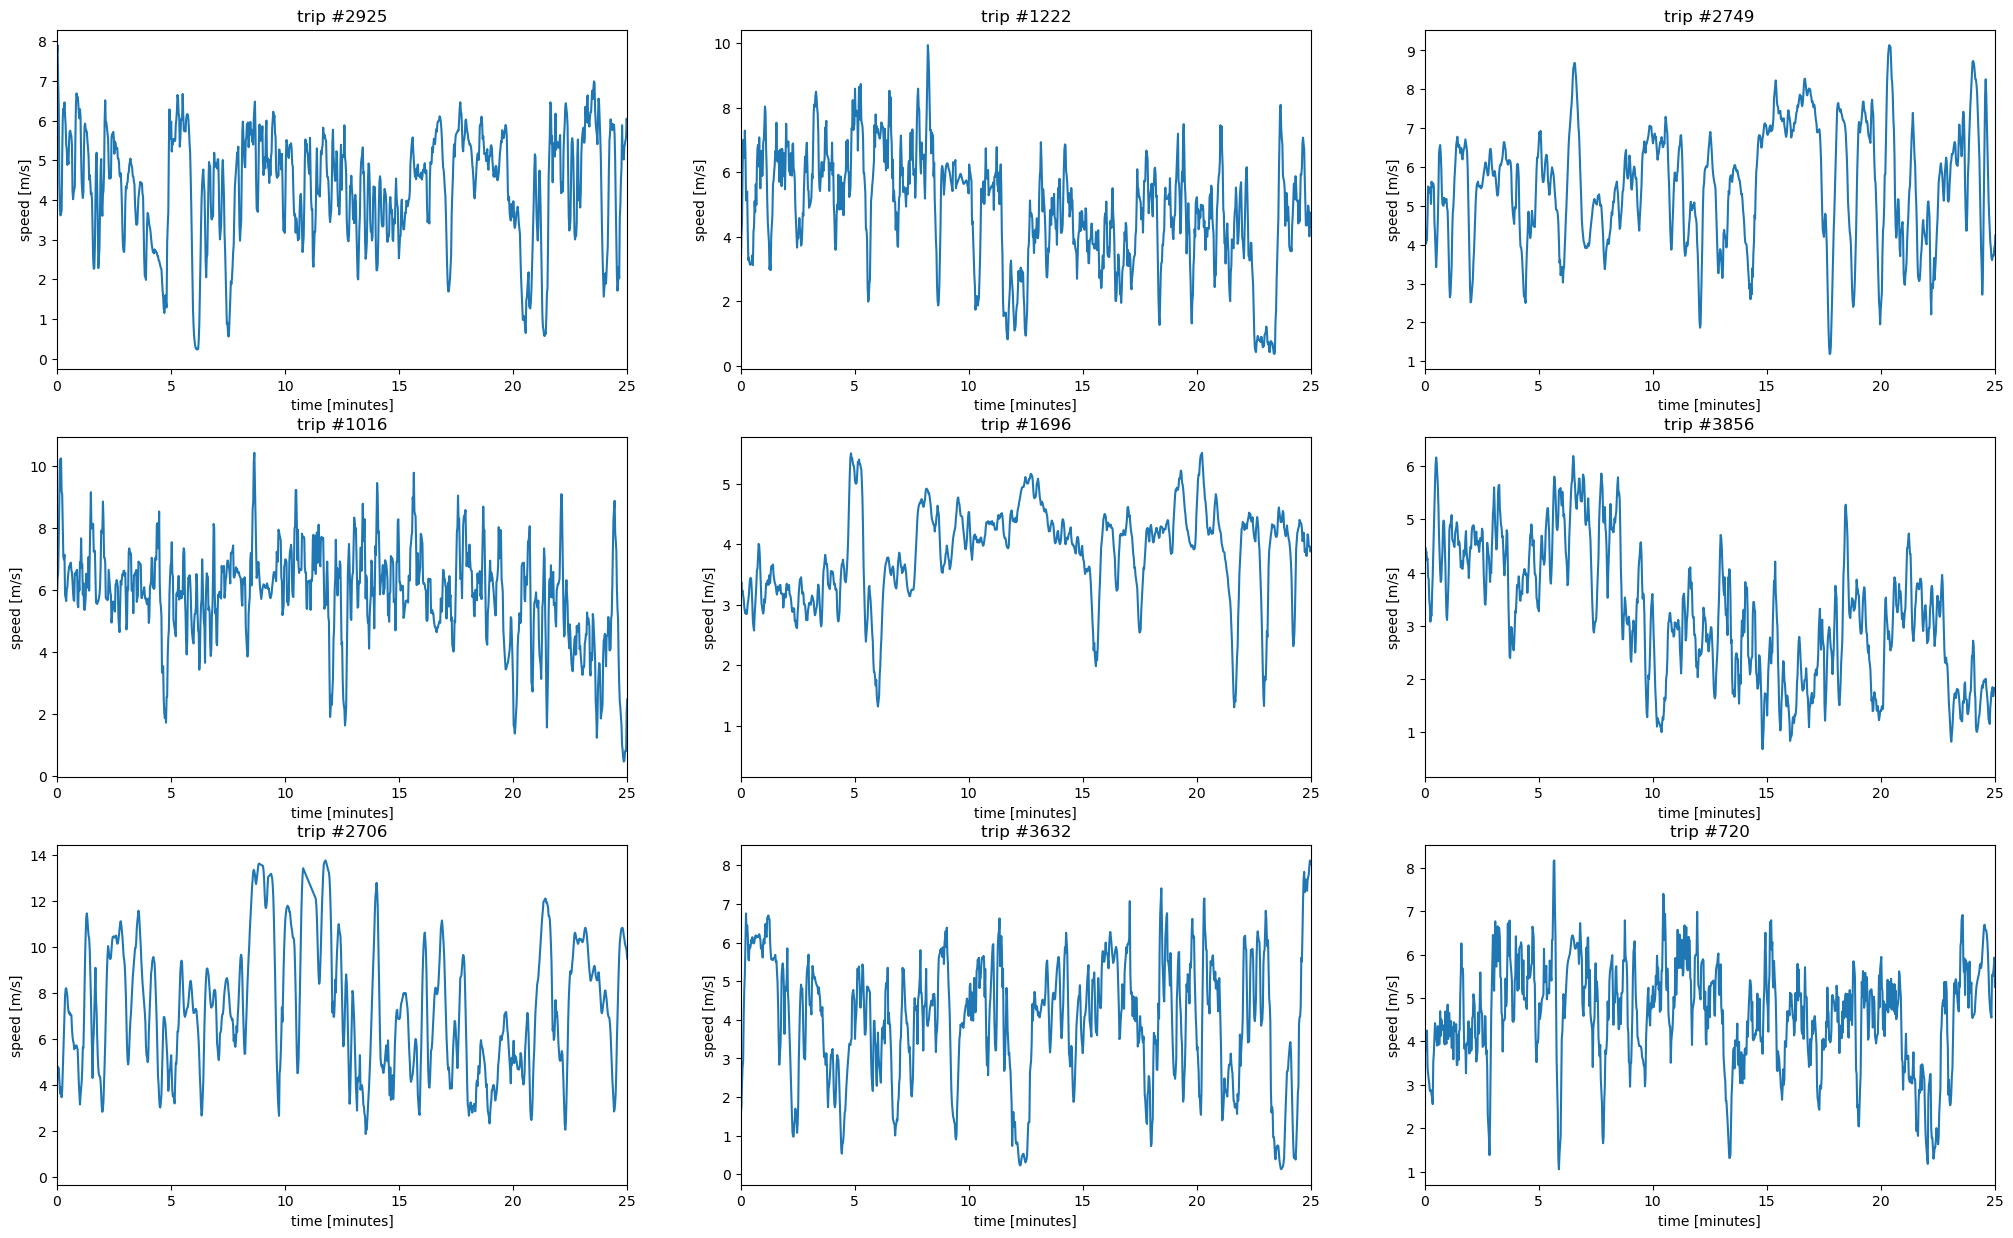

In [1042]:
N = 9

trip_ids = GM.loc[GM["total_time"] >= 25].trip_id.unique().tolist()
trips = [random.randint(0,len(trip_ids)) for x in range(N)]

fig = plt.figure(figsize=(25, 5*round(N/3)))

for i in range(N):
    trip = trip_ids[trips[i]]
    times = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["time_sum"].tolist()
    vels = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["vel_smooth"]
    
    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("time [minutes]")
    plt.ylabel("speed [m/s]")
    plt.plot(times, vels, "-")
    #plt.plot([1,2,3], [1,2,3], "-")
    plt.xlim([0, 25])
    plt.title("trip #"+str(trip))

plt.show()

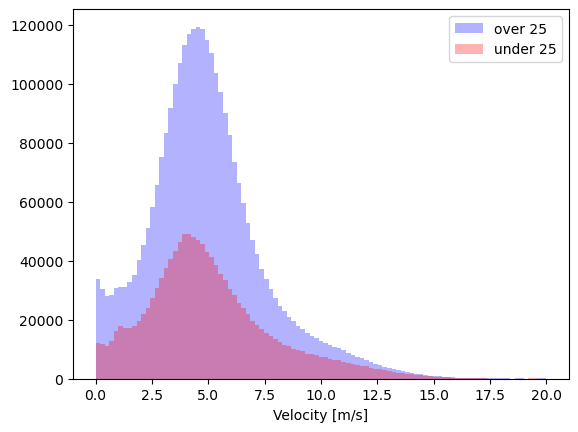

In [1183]:
bins = np.linspace(0, 20, 100) 
plt.hist(GM.loc[(GM["count"]>=0) & (GM["total_time"]>=25)]["vel"], label='over 25', bins=bins, alpha=0.3, color='blue')
plt.hist(GM.loc[(GM["count"]>=0) & (GM["total_time"]<=25)]["vel"], label='under 25', bins=bins, alpha=0.3, color='red')

plt.xlabel("Velocity [m/s]")
plt.legend()
 
plt.show()

# discarded: 
cruising band

In [ ]:
V = opt_df["vel_smooth"].tolist()
cale = []
idx_cale = []

for i in range(len(V)):
    v_list = []
    idx_li = []
    v = V[i]
    for j in range(i,len(V)):
        u = V[j]
        if u < v*1.07 and u > v*0.93:
            v_list.append(u)
            idx_li.append(j)
        else:
            if len(v_list) >= 5:
                cale.append(v_list)
                idx_cale.append(idx_li)
                #for el in idx_li:
                #    if el != idx_cale:
                #        idx_cale.append(el)
            break
            
idx_uni = []
col_idx = [0 for x in range(len(opt_df))]


for i in range(len(cale)):
    for el in idx_cale[i]:
        if el not in idx_uni:
            idx_uni.append(el)
            col_idx[el] = 1

In [620]:
print("hallo world")

hallo world


In [623]:
number_list = []
nr_list = []
n_list = [x for x in range(10)]

for number in range(10):
    number_list.append(number)
    nr_list += [number]
    
    
print(number_list)
print(nr_list)
print(n_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [1148]:
gm

trip_id    idx  time_sum  time        vel       acc   pos_acc  \
        idx                                                                    
4       1            0      1       1.5   1.5  11.209224  1.617473  1.617473   
5       1            0      1       3.0   1.5  13.635434 -0.109807       NaN   
6       1            0      1       4.5   1.5  13.470723 -0.960859       NaN   
7       1            0      1       6.0   1.5  12.029435 -1.700333       NaN   
8       1            0      1       7.5   1.5   9.478935 -1.261345       NaN   
...                ...    ...       ...   ...        ...       ...       ...   
4326815 16836     4879  16836     294.0   1.5   2.862731 -0.134117       NaN   
4326816 16836     4879  16836     295.5   1.5   2.661555  0.353716  0.353716   
4326817 16836     4879  16836     297.0   1.5   3.192129 -0.215075       NaN   
4326818 16836     4879  16836     298.5   1.5   2.869517  0.196172  0.196172   
4326819 16836     4879  16836     300.0   1.5   3.163774 -0.329132       NaN   

                neg_acc  cruise  acc_time       dev  
        idx                                          
4       1           NaN       0         1  5.890200  
5       1     -0.109807       0         0  5.890200  
6       1     -0.960859       0         0  5.890200  
7       1     -1.700333       0         0  5.890200  
8       1     -1.261345       0         0  5.890200  
...                 ...     ...       ...       ...  
4326815 16836 -0.134117       0         0  8.938085  
4326816 16836       NaN       0         1  8.938085  
4326817 16836 -0.215075       0         0  8.938085  
4326818 16836       NaN       0         1  8.938085  
4326819 16836 -0.329132       0         0  8.938085  

[2680000 rows x 11 columns]

In [1147]:
gdf["id_origine"].max()

28942

In [1141]:
len(gdf["liste_segments_jsonb"][1])

17

In [1142]:
len(gdf["points"][1])

77

In [1143]:
len(gdf)

4881

In [1146]:
gdf["id_origine"].nunique()

4881

In [3]:
x, y = np.array([-2, 0, 4]), np.array([-2, 0, 2, 5])

def ff(x, y):
    #elevation = df_el.loc[(df_el["lat"]==x) & (df_el["long"]==y)]
    return x**2 + y**2


xg, yg = np.meshgrid(x, y, indexing='ij')
data = ff(xg, yg)
interp = RegularGridInterpolator((x, y), data,
                                 bounds_error=False, fill_value=None)

In [19]:
np.array([[1,2],[3,2]])

array([[1, 2],
       [3, 2]])

In [20]:
(x,y)

(array([-2,  0,  4]), array([-2,  0,  2,  5]))

In [7]:
data

array([[ 8,  4,  8, 29],
       [ 4,  0,  4, 25],
       [20, 16, 20, 41]])

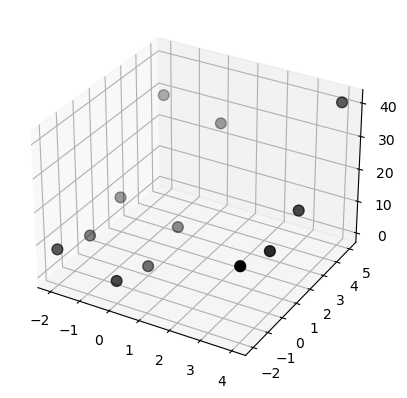

In [4]:
fig = plt.figure()

ax = fig.add_subplot(projection='3d')

ax.scatter(xg.ravel(), yg.ravel(), data.ravel(),

           s=60, c='k', label='data')

In [2]:
x = [0,0,0,1,1,1,2,2,2]
y = [0,1,2,0,1,2,0,1,2]
z = [1,2,3,2,5,2,3,0,1]
interp = RegularGridInterpolator((x, y), z, bounds_error=False, fill_value=None)

ValueError: There are 2 point arrays, but values has 1 dimensions